In [1]:
!nvidia-smi

Fri Mar  1 01:39:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P5              20W / 215W |    687MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
sr = 16000
data_dir = '../data/data_preprocessed/iemocap/preprocessing/'
data_x = np.load(f'{data_dir}iemocap.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}iemocap.label4.npy', allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3948
Test: 988


In [8]:
y_train[0]

'ang'

In [9]:
np.unique(y_train)

array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

In [11]:
def label_to_index(word):
    return labels.index(word)
label_to_index(y_train[0])

0

In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 8

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
import traceback

In [15]:
from IConNet.nn.model import M13 as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                | 0.0016233766233766235/10 [00:00<56:58, 341.90s/it]

Train Epoch: 1 [0/3948 (0%)]	Loss: 1.458207
Mem before-during-after: 1820160 2731018752 44953088


  1%|▏                                 | 0.06818181818181819/10 [00:12<27:16, 164.79s/it]

Train Epoch: 1 [320/3948 (8%)]	Loss: 1.540056
Mem before-during-after: 45241856 2743960576 45155840


  1%|▍                                 | 0.13311688311688308/10 [00:23<26:48, 163.01s/it]

Train Epoch: 1 [640/3948 (16%)]	Loss: 2.034926
Mem before-during-after: 44953088 2742851584 44953088


  2%|▋                                 | 0.19805194805194748/10 [00:34<26:40, 163.26s/it]

Train Epoch: 1 [960/3948 (24%)]	Loss: 1.994130
Mem before-during-after: 45352448 2743984128 45179392


  3%|▉                                  | 0.2629870129870121/10 [00:45<27:10, 167.47s/it]

Train Epoch: 1 [1280/3948 (32%)]	Loss: 1.589399
Mem before-during-after: 44929536 2744479744 44929536


  3%|█▏                                 | 0.3279220779220776/10 [00:56<26:33, 164.80s/it]

Train Epoch: 1 [1600/3948 (41%)]	Loss: 1.180406
Mem before-during-after: 44929536 2744479744 44929536


  4%|█▍                                 | 0.3928571428571431/10 [01:07<26:17, 164.22s/it]

Train Epoch: 1 [1920/3948 (49%)]	Loss: 1.286668
Mem before-during-after: 44929536 2743488000 44977152


  5%|█▌                                | 0.45779220779220864/10 [01:18<25:52, 162.74s/it]

Train Epoch: 1 [2240/3948 (57%)]	Loss: 1.882671
Mem before-during-after: 45155840 2744479744 44929536


  5%|█▊                                 | 0.5227272727272742/10 [01:29<25:47, 163.30s/it]

Train Epoch: 1 [2560/3948 (65%)]	Loss: 1.082477
Mem before-during-after: 44929536 2744479744 44929536


  6%|██                                 | 0.5876623376623397/10 [01:40<26:27, 168.63s/it]

Train Epoch: 1 [2880/3948 (73%)]	Loss: 1.022141
Mem before-during-after: 45604864 2742991872 45155840


  7%|██▎                                | 0.6525974025974052/10 [01:51<25:50, 165.87s/it]

Train Epoch: 1 [3200/3948 (81%)]	Loss: 0.895902
Mem before-during-after: 45181952 2725331456 45352448


  7%|██▌                                 | 0.715909090909094/10 [02:02<29:09, 188.45s/it]

Train Epoch: 1 [3520/3948 (89%)]	Loss: 1.736857
Mem before-during-after: 45945344 2745081856 44953088


  8%|██▋                                | 0.7824675324675362/10 [02:13<24:30, 159.49s/it]

Train Epoch: 1 [3840/3948 (97%)]	Loss: 0.915871
Mem before-during-after: 45179392 2742812672 44976640


 10%|███▌                               | 1.0000000000000056/10 [02:37<15:49, 105.55s/it]


Test Epoch: 1	Accuracy: 467/984 (47%)



 10%|███▌                               | 1.0032467532467588/10 [02:38<18:19, 122.21s/it]

Train Epoch: 2 [0/3948 (0%)]	Loss: 1.802498
Mem before-during-after: 45198336 2743718912 44953088


 11%|███▋                               | 1.0681818181818243/10 [02:49<24:52, 167.11s/it]

Train Epoch: 2 [320/3948 (8%)]	Loss: 1.247873
Mem before-during-after: 45166592 2743962624 44953088


 11%|███▉                               | 1.1331168831168899/10 [03:00<24:57, 168.91s/it]

Train Epoch: 2 [640/3948 (16%)]	Loss: 0.821220
Mem before-during-after: 45937152 2743639552 45143040


 12%|████▏                              | 1.1980519480519554/10 [03:11<24:32, 167.31s/it]

Train Epoch: 2 [960/3948 (24%)]	Loss: 1.151987
Mem before-during-after: 44953088 2743986688 45190144


 13%|████▍                              | 1.2613636363636442/10 [03:22<26:57, 185.06s/it]

Train Epoch: 2 [1280/3948 (32%)]	Loss: 1.989977
Mem before-during-after: 44929536 2742765568 44929536


 13%|████▋                              | 1.3279220779220864/10 [03:33<23:57, 165.80s/it]

Train Epoch: 2 [1600/3948 (41%)]	Loss: 1.173222
Mem before-during-after: 45155840 2742994432 45158400


 14%|████▊                              | 1.3912337662337753/10 [03:44<26:32, 184.94s/it]

Train Epoch: 2 [1920/3948 (49%)]	Loss: 1.083538
Mem before-during-after: 45158400 2743915520 44929536


 15%|█████                              | 1.4577922077922174/10 [03:55<23:05, 162.17s/it]

Train Epoch: 2 [2240/3948 (57%)]	Loss: 1.875090
Mem before-during-after: 44929536 2744407040 45960704


 15%|█████▍                              | 1.522727272727283/10 [04:06<23:14, 164.50s/it]

Train Epoch: 2 [2560/3948 (65%)]	Loss: 1.769876
Mem before-during-after: 45158400 2743915520 44929536


 16%|█████▌                             | 1.5876623376623484/10 [04:17<22:53, 163.27s/it]

Train Epoch: 2 [2880/3948 (73%)]	Loss: 1.480679
Mem before-during-after: 45158400 2742991872 45155840


 17%|█████▊                             | 1.6509740259740373/10 [04:28<26:05, 187.49s/it]

Train Epoch: 2 [3200/3948 (81%)]	Loss: 1.264259
Mem before-during-after: 44953088 2726362624 46336512


 17%|██████                             | 1.7175324675324795/10 [04:40<23:03, 167.02s/it]

Train Epoch: 2 [3520/3948 (89%)]	Loss: 1.433568
Mem before-during-after: 44929536 2726268928 45352448


 18%|██████▍                             | 1.782467532467545/10 [04:51<23:12, 169.42s/it]

Train Epoch: 2 [3840/3948 (97%)]	Loss: 1.051964
Mem before-during-after: 45921792 2744765440 45921792


 20%|███████▏                            | 2.000000000000014/10 [05:15<15:16, 114.50s/it]


Test Epoch: 2	Accuracy: 484/984 (49%)



 20%|███████▏                            | 2.003246753246767/10 [05:16<16:29, 123.71s/it]

Train Epoch: 3 [0/3948 (0%)]	Loss: 1.103142
Mem before-during-after: 44922368 2743442944 44929536


 21%|███████▏                           | 2.0681818181818237/10 [05:26<21:09, 160.01s/it]

Train Epoch: 3 [320/3948 (8%)]	Loss: 1.200924
Mem before-during-after: 44929536 2742789120 44953088


 21%|███████▋                            | 2.131493506493504/10 [05:37<23:44, 181.07s/it]

Train Epoch: 3 [640/3948 (16%)]	Loss: 0.932302
Mem before-during-after: 45166592 2742789120 44953088


 22%|███████▋                           | 2.1964285714285605/10 [05:48<23:35, 181.37s/it]

Train Epoch: 3 [960/3948 (24%)]	Loss: 0.972042
Mem before-during-after: 44929536 2744200192 45395456


 23%|███████▉                           | 2.2629870129869936/10 [05:59<20:29, 158.92s/it]

Train Epoch: 3 [1280/3948 (32%)]	Loss: 1.242694
Mem before-during-after: 45087232 2744549376 45945344


 23%|████████▌                            | 2.32792207792205/10 [06:10<20:57, 163.86s/it]

Train Epoch: 3 [1600/3948 (41%)]	Loss: 1.166376
Mem before-during-after: 45190144 2742812160 44953088


 24%|████████▌                           | 2.392857142857107/10 [06:20<19:38, 154.87s/it]

Train Epoch: 3 [1920/3948 (49%)]	Loss: 1.482285
Mem before-during-after: 45775360 2743508992 45382144


 25%|████████▌                          | 2.4577922077921635/10 [06:31<20:32, 163.39s/it]

Train Epoch: 3 [2240/3948 (57%)]	Loss: 1.111263
Mem before-during-after: 45382144 2743885312 45382144


 25%|█████████▎                           | 2.52272727272722/10 [06:42<20:58, 168.35s/it]

Train Epoch: 3 [2560/3948 (65%)]	Loss: 1.392061
Mem before-during-after: 45382144 2743885312 45382144


 26%|█████████                          | 2.5876623376622767/10 [06:53<19:45, 159.99s/it]

Train Epoch: 3 [2880/3948 (73%)]	Loss: 1.496755
Mem before-during-after: 45382144 2744495616 45382144


 27%|█████████▎                         | 2.6525974025973333/10 [07:03<19:48, 161.71s/it]

Train Epoch: 3 [3200/3948 (81%)]	Loss: 1.023342
Mem before-during-after: 45382144 2727076864 45775360


 27%|█████████▌                         | 2.7159090909090136/10 [07:14<21:40, 178.57s/it]

Train Epoch: 3 [3520/3948 (89%)]	Loss: 1.022483
Mem before-during-after: 45382144 2727076864 45775360


 28%|██████████▎                          | 2.78084415584407/10 [07:24<21:33, 179.14s/it]

Train Epoch: 3 [3840/3948 (97%)]	Loss: 1.090107
Mem before-during-after: 45179392 2743306240 45179392


 30%|██████████▍                        | 2.9999999999998863/10 [07:49<12:22, 106.03s/it]


Test Epoch: 3	Accuracy: 481/984 (49%)



 30%|██████████▌                        | 3.0016233766232627/10 [07:49<14:20, 122.97s/it]

Train Epoch: 4 [0/3948 (0%)]	Loss: 1.036431
Mem before-during-after: 45198336 2743466496 44953088


 31%|██████████▋                        | 3.0681818181816958/10 [08:00<19:36, 169.65s/it]

Train Epoch: 4 [320/3948 (8%)]	Loss: 0.735737
Mem before-during-after: 44944896 2743399424 44953088


 31%|██████████▉                        | 3.1331168831167524/10 [08:11<18:43, 163.60s/it]

Train Epoch: 4 [640/3948 (16%)]	Loss: 0.955047
Mem before-during-after: 44953088 2742789120 44953088


 32%|███████████▏                       | 3.1964285714284326/10 [08:22<21:12, 187.03s/it]

Train Epoch: 4 [960/3948 (24%)]	Loss: 1.078486
Mem before-during-after: 44929536 2743422976 44953088


 33%|███████████▍                       | 3.2629870129868657/10 [08:33<18:29, 164.66s/it]

Train Epoch: 4 [1280/3948 (32%)]	Loss: 1.422110
Mem before-during-after: 44953088 2742812672 44929536


 33%|███████████▋                       | 3.3279220779219223/10 [08:44<18:02, 162.30s/it]

Train Epoch: 4 [1600/3948 (41%)]	Loss: 1.252922
Mem before-during-after: 45731840 2743781376 45190144


 34%|████████████▏                       | 3.392857142856979/10 [08:55<18:01, 163.72s/it]

Train Epoch: 4 [1920/3948 (49%)]	Loss: 1.193390
Mem before-during-after: 44929536 2743820288 45865472


 35%|████████████                       | 3.4577922077920356/10 [09:06<17:59, 165.04s/it]

Train Epoch: 4 [2240/3948 (57%)]	Loss: 1.504542
Mem before-during-after: 45376000 2743975936 45179392


 35%|████████████▋                       | 3.522727272727092/10 [09:17<17:25, 161.34s/it]

Train Epoch: 4 [2560/3948 (65%)]	Loss: 1.210091
Mem before-during-after: 44953088 2742812672 44929536


 36%|████████████▌                      | 3.5860389610387724/10 [09:28<19:34, 183.16s/it]

Train Epoch: 4 [2880/3948 (73%)]	Loss: 0.735021
Mem before-during-after: 45843968 2743454720 45155840


 37%|████████████▊                      | 3.6525974025972054/10 [09:39<17:01, 160.94s/it]

Train Epoch: 4 [3200/3948 (81%)]	Loss: 0.977684
Mem before-during-after: 44976640 2725950464 45376000


 37%|█████████████                      | 3.7159090909088857/10 [09:50<18:57, 180.95s/it]

Train Epoch: 4 [3520/3948 (89%)]	Loss: 0.888977
Mem before-during-after: 45905920 2744359936 44929536


 38%|█████████████▏                     | 3.7824675324673187/10 [10:01<16:32, 159.68s/it]

Train Epoch: 4 [3840/3948 (97%)]	Loss: 1.034104
Mem before-during-after: 44929536 2743375872 44929536


 40%|█████████████▉                     | 3.9999999999997584/10 [10:25<10:31, 105.20s/it]


Test Epoch: 4	Accuracy: 434/984 (44%)



 40%|██████████████▍                     | 4.003246753246511/10 [10:26<12:11, 121.97s/it]

Train Epoch: 5 [0/3948 (0%)]	Loss: 1.768764
Mem before-during-after: 45174784 2743718912 44953088


 41%|██████████████▋                     | 4.068181818181568/10 [10:37<16:10, 163.69s/it]

Train Epoch: 5 [320/3948 (8%)]	Loss: 1.313018
Mem before-during-after: 45166592 2743962624 44953088


 41%|██████████████▍                    | 4.1331168831166245/10 [10:47<15:51, 162.12s/it]

Train Epoch: 5 [640/3948 (16%)]	Loss: 0.998565
Mem before-during-after: 45382144 2726605824 45775360


 42%|███████████████                     | 4.196428571428305/10 [10:58<17:26, 180.33s/it]

Train Epoch: 5 [960/3948 (24%)]	Loss: 1.026942
Mem before-during-after: 45382144 2743664128 45382144


 43%|███████████████▎                    | 4.262987012986738/10 [11:09<15:53, 166.26s/it]

Train Epoch: 5 [1280/3948 (32%)]	Loss: 0.991729
Mem before-during-after: 45775360 2743664128 45382144


 43%|███████████████▌                    | 4.326298701298418/10 [11:20<17:38, 186.57s/it]

Train Epoch: 5 [1600/3948 (41%)]	Loss: 1.083664
Mem before-during-after: 45382144 2743664128 45382144


 44%|███████████████▊                    | 4.391233766233475/10 [11:31<17:03, 182.40s/it]

Train Epoch: 5 [1920/3948 (49%)]	Loss: 0.910839
Mem before-during-after: 45382144 2743664128 45382144


 45%|████████████████                    | 4.456168831168531/10 [11:42<16:34, 179.45s/it]

Train Epoch: 5 [2240/3948 (57%)]	Loss: 1.461183
Mem before-during-after: 45382144 2726605824 45775360


 45%|████████████████▎                   | 4.522727272726964/10 [11:53<14:51, 162.77s/it]

Train Epoch: 5 [2560/3948 (65%)]	Loss: 0.959758
Mem before-during-after: 45382144 2743664128 45382144


 46%|████████████████▌                   | 4.587662337662021/10 [12:04<14:48, 164.25s/it]

Train Epoch: 5 [2880/3948 (73%)]	Loss: 1.094696
Mem before-during-after: 45382144 2743664128 45382144


 47%|████████████████▎                  | 4.6525974025970775/10 [12:15<15:02, 168.86s/it]

Train Epoch: 5 [3200/3948 (81%)]	Loss: 1.102515
Mem before-during-after: 45382144 2743782912 45382144


 47%|████████████████▉                   | 4.717532467532134/10 [12:26<14:27, 164.25s/it]

Train Epoch: 5 [3520/3948 (89%)]	Loss: 0.846855
Mem before-during-after: 45382144 2743664128 45382144


 48%|█████████████████▏                  | 4.782467532467191/10 [12:37<13:48, 158.88s/it]

Train Epoch: 5 [3840/3948 (97%)]	Loss: 1.497619
Mem before-during-after: 45382144 2744421888 45382144


 50%|█████████████████▍                 | 4.9999999999996305/10 [13:01<08:47, 105.41s/it]


Test Epoch: 5	Accuracy: 494/984 (50%)



 50%|██████████████████                  | 5.001623376623007/10 [13:01<10:19, 123.84s/it]

Train Epoch: 6 [0/3948 (0%)]	Loss: 1.754696
Mem before-during-after: 45174784 2743718912 44953088


 51%|██████████████████▊                  | 5.06818181818144/10 [13:12<13:39, 166.14s/it]

Train Epoch: 6 [320/3948 (8%)]	Loss: 1.075603
Mem before-during-after: 45190144 2743915520 45158400


 51%|██████████████████▍                 | 5.133116883116497/10 [13:23<13:37, 167.88s/it]

Train Epoch: 6 [640/3948 (16%)]	Loss: 1.063717
Mem before-during-after: 45274624 2742789120 44953088


 52%|██████████████████▋                 | 5.198051948051553/10 [13:34<13:34, 169.64s/it]

Train Epoch: 6 [960/3948 (24%)]	Loss: 1.126987
Mem before-during-after: 45179392 2743015424 45179392


 53%|███████████████████▍                 | 5.26298701298661/10 [13:45<12:45, 161.61s/it]

Train Epoch: 6 [1280/3948 (32%)]	Loss: 0.979058
Mem before-during-after: 45842432 2725974528 45352448


 53%|██████████████████▋                | 5.3279220779216665/10 [13:56<12:39, 162.57s/it]

Train Epoch: 6 [1600/3948 (41%)]	Loss: 0.919597
Mem before-during-after: 44929536 2743375872 44929536


 54%|███████████████████▍                | 5.391233766233347/10 [14:07<14:13, 185.19s/it]

Train Epoch: 6 [1920/3948 (49%)]	Loss: 2.053173
Mem before-during-after: 44929536 2744200192 45395456


 55%|███████████████████▋                | 5.456168831168403/10 [14:18<14:50, 196.05s/it]

Train Epoch: 6 [2240/3948 (57%)]	Loss: 1.088093
Mem before-during-after: 45155840 2742994432 45158400


 55%|███████████████████▉                | 5.522727272726836/10 [14:29<12:24, 166.21s/it]

Train Epoch: 6 [2560/3948 (65%)]	Loss: 1.146996
Mem before-during-after: 45158400 2742991872 45155840


 56%|████████████████████                | 5.587662337661893/10 [14:40<11:59, 163.11s/it]

Train Epoch: 6 [2880/3948 (73%)]	Loss: 0.856574
Mem before-during-after: 44929536 2744200192 45395456


 57%|████████████████████▉                | 5.65259740259695/10 [14:51<12:08, 167.68s/it]

Train Epoch: 6 [3200/3948 (81%)]	Loss: 1.025334
Mem before-during-after: 44929536 2744200192 45395456


 57%|████████████████████▌               | 5.717532467532006/10 [15:02<11:41, 163.81s/it]

Train Epoch: 6 [3520/3948 (89%)]	Loss: 1.117639
Mem before-during-after: 45395456 2742789120 44929536


 58%|████████████████████▊               | 5.782467532467063/10 [15:13<11:25, 162.60s/it]

Train Epoch: 6 [3840/3948 (97%)]	Loss: 1.143085
Mem before-during-after: 44929536 2743740928 45904896


 60%|█████████████████████▌              | 5.999999999999503/10 [15:38<06:56, 104.15s/it]


Test Epoch: 6	Accuracy: 458/984 (46%)



 60%|█████████████████████              | 6.0032467532462555/10 [15:38<07:48, 117.25s/it]

Train Epoch: 7 [0/3948 (0%)]	Loss: 0.918420
Mem before-during-after: 44922368 2743442944 44929536


 61%|█████████████████████▊              | 6.066558441557936/10 [15:49<12:02, 183.63s/it]

Train Epoch: 7 [320/3948 (8%)]	Loss: 1.009593
Mem before-during-after: 44953088 2742812672 44929536


 61%|██████████████████████              | 6.131493506492992/10 [16:00<11:53, 184.32s/it]

Train Epoch: 7 [640/3948 (16%)]	Loss: 0.998714
Mem before-during-after: 46001664 2744074752 45190144


 62%|██████████████████████▎             | 6.198051948051425/10 [16:11<10:25, 164.50s/it]

Train Epoch: 7 [960/3948 (24%)]	Loss: 0.913144
Mem before-during-after: 45827072 2742780928 44944896


 63%|██████████████████████▌             | 6.262987012986482/10 [16:22<10:17, 165.31s/it]

Train Epoch: 7 [1280/3948 (32%)]	Loss: 1.346221
Mem before-during-after: 45376000 2743015424 45179392


 63%|██████████████████████▊             | 6.326298701298162/10 [16:33<11:15, 183.94s/it]

Train Epoch: 7 [1600/3948 (41%)]	Loss: 0.945329
Mem before-during-after: 45179392 2742812672 44976640


 64%|███████████████████████             | 6.392857142856595/10 [16:44<09:54, 164.69s/it]

Train Epoch: 7 [1920/3948 (49%)]	Loss: 0.773343
Mem before-during-after: 44953088 2744359936 45842432


 65%|███████████████████████▏            | 6.457792207791652/10 [16:55<09:36, 162.76s/it]

Train Epoch: 7 [2240/3948 (57%)]	Loss: 1.055555
Mem before-during-after: 44953088 2743702016 45158400


 65%|██████████████████████▊            | 6.5227272727267085/10 [17:06<09:31, 164.36s/it]

Train Epoch: 7 [2560/3948 (65%)]	Loss: 0.884259
Mem before-during-after: 45190144 2743878144 44976640


 66%|███████████████████████▋            | 6.587662337661765/10 [17:17<09:32, 167.85s/it]

Train Epoch: 7 [2880/3948 (73%)]	Loss: 0.950018
Mem before-during-after: 44976640 2743496704 44953088


 67%|███████████████████████▉            | 6.652597402596822/10 [17:28<09:19, 167.19s/it]

Train Epoch: 7 [3200/3948 (81%)]	Loss: 1.008726
Mem before-during-after: 44929536 2744383488 45937152


 67%|████████████████████████▏           | 6.717532467531878/10 [17:39<09:13, 168.55s/it]

Train Epoch: 7 [3520/3948 (89%)]	Loss: 1.108155
Mem before-during-after: 45155840 2742804480 44968448


 68%|████████████████████████▍           | 6.780844155843559/10 [17:50<09:57, 185.59s/it]

Train Epoch: 7 [3840/3948 (97%)]	Loss: 1.239655
Mem before-during-after: 44929536 2742765568 44929536


 70%|█████████████████████████▏          | 6.999999999999375/10 [18:15<05:08, 102.93s/it]


Test Epoch: 7	Accuracy: 499/984 (51%)



 70%|████████████████████████▌          | 7.0032467532461276/10 [18:15<06:03, 121.42s/it]

Train Epoch: 8 [0/3948 (0%)]	Loss: 0.832994
Mem before-during-after: 44945920 2743695360 44929536


 71%|█████████████████████████▍          | 7.066558441557808/10 [18:26<09:06, 186.21s/it]

Train Epoch: 8 [320/3948 (8%)]	Loss: 0.976349
Mem before-during-after: 45905408 2743026176 45190144


 71%|█████████████████████████▋          | 7.133116883116241/10 [18:37<08:09, 170.58s/it]

Train Epoch: 8 [640/3948 (16%)]	Loss: 1.016390
Mem before-during-after: 44929536 2743915520 45158400


 72%|█████████████████████████▉          | 7.198051948051297/10 [18:48<07:34, 162.09s/it]

Train Epoch: 8 [960/3948 (24%)]	Loss: 1.401410
Mem before-during-after: 44953088 2744335872 44953088


 73%|██████████████████████████▏         | 7.261363636362978/10 [18:58<08:27, 185.42s/it]

Train Epoch: 8 [1280/3948 (32%)]	Loss: 1.028967
Mem before-during-after: 46001664 2744074752 45190144


 73%|██████████████████████████▎         | 7.326298701298034/10 [19:09<08:11, 183.64s/it]

Train Epoch: 8 [1600/3948 (41%)]	Loss: 1.088736
Mem before-during-after: 44929536 2742765568 44929536


 74%|██████████████████████████▌         | 7.392857142856467/10 [19:20<07:00, 161.26s/it]

Train Epoch: 8 [1920/3948 (49%)]	Loss: 1.116502
Mem before-during-after: 45376000 2743015424 45179392


 75%|██████████████████████████▊         | 7.457792207791524/10 [19:31<06:48, 160.83s/it]

Train Epoch: 8 [2240/3948 (57%)]	Loss: 0.936593
Mem before-during-after: 44929536 2725331456 45352448


 75%|███████████████████████████         | 7.522727272726581/10 [19:42<06:35, 159.69s/it]

Train Epoch: 8 [2560/3948 (65%)]	Loss: 1.207960
Mem before-during-after: 45087744 2743218176 45179392


 76%|███████████████████████████▎        | 7.587662337661637/10 [19:52<06:28, 160.93s/it]

Train Epoch: 8 [2880/3948 (73%)]	Loss: 1.490071
Mem before-during-after: 44953088 2743986688 45166592


 77%|███████████████████████████▌        | 7.652597402596694/10 [20:03<06:17, 160.77s/it]

Train Epoch: 8 [3200/3948 (81%)]	Loss: 0.849264
Mem before-during-after: 45181952 2743725568 44944896


 77%|███████████████████████████        | 7.7175324675317505/10 [20:14<06:07, 161.14s/it]

Train Epoch: 8 [3520/3948 (89%)]	Loss: 0.856515
Mem before-during-after: 45158400 2743607296 44953088


 78%|████████████████████████████        | 7.782467532466807/10 [20:25<05:51, 158.46s/it]

Train Epoch: 8 [3840/3948 (97%)]	Loss: 0.919799
Mem before-during-after: 45865472 2742765568 44929536


 80%|████████████████████████████▊       | 7.999999999999247/10 [20:49<03:31, 106.00s/it]


Test Epoch: 8	Accuracy: 502/984 (51%)



 80%|███████████████████████████████▏       | 8.003246753246/10 [20:49<04:00, 120.54s/it]

Train Epoch: 9 [0/3948 (0%)]	Loss: 0.834656
Mem before-during-after: 45198336 2743528960 44953088


 81%|█████████████████████████████       | 8.068181818181056/10 [21:00<05:11, 161.02s/it]

Train Epoch: 9 [320/3948 (8%)]	Loss: 0.886710
Mem before-during-after: 44953088 2743399424 44953088


 81%|█████████████████████████████▎      | 8.133116883116113/10 [21:11<05:09, 165.62s/it]

Train Epoch: 9 [640/3948 (16%)]	Loss: 0.735673
Mem before-during-after: 44929536 2742765568 44929536


 82%|█████████████████████████████▌      | 8.196428571427793/10 [21:22<05:30, 183.52s/it]

Train Epoch: 9 [960/3948 (24%)]	Loss: 1.114787
Mem before-during-after: 45179392 2742812672 44976640


 83%|█████████████████████████████▋      | 8.262987012986226/10 [21:32<04:39, 160.66s/it]

Train Epoch: 9 [1280/3948 (32%)]	Loss: 1.156897
Mem before-during-after: 45190144 2743915520 45158400


 83%|█████████████████████████████▉      | 8.326298701297906/10 [21:43<05:25, 194.68s/it]

Train Epoch: 9 [1600/3948 (41%)]	Loss: 1.303243
Mem before-during-after: 44953088 2742789120 44953088


 84%|██████████████████████████████▏     | 8.391233766232963/10 [21:54<05:00, 186.81s/it]

Train Epoch: 9 [1920/3948 (49%)]	Loss: 0.958299
Mem before-during-after: 45155840 2743017984 44929536


 85%|██████████████████████████████▍     | 8.457792207791396/10 [22:06<04:39, 181.51s/it]

Train Epoch: 9 [2240/3948 (57%)]	Loss: 1.019686
Mem before-during-after: 44929536 2744359936 45842432


 85%|██████████████████████████████▋     | 8.522727272726453/10 [22:16<03:51, 156.45s/it]

Train Epoch: 9 [2560/3948 (65%)]	Loss: 0.813616
Mem before-during-after: 45352448 2743054336 45179392


 86%|███████████████████████████████▊     | 8.58766233766151/10 [22:27<03:41, 156.67s/it]

Train Epoch: 9 [2880/3948 (73%)]	Loss: 0.931625
Mem before-during-after: 44929536 2743797248 44929536


 87%|███████████████████████████████▏    | 8.652597402596566/10 [22:37<03:31, 156.81s/it]

Train Epoch: 9 [3200/3948 (81%)]	Loss: 1.453670
Mem before-during-after: 45158400 2743607296 44929536


 87%|███████████████████████████████▍    | 8.717532467531623/10 [22:48<03:23, 159.01s/it]

Train Epoch: 9 [3520/3948 (89%)]	Loss: 1.101980
Mem before-during-after: 44953088 2742812672 44953088


 88%|████████████████████████████████▍    | 8.78246753246668/10 [22:58<03:09, 155.73s/it]

Train Epoch: 9 [3840/3948 (97%)]	Loss: 1.286130
Mem before-during-after: 44953088 2745163776 45179392


 90%|████████████████████████████████▍   | 8.999999999999119/10 [23:22<01:43, 103.13s/it]


Test Epoch: 9	Accuracy: 483/984 (49%)



 90%|████████████████████████████████▍   | 9.003246753245872/10 [23:22<01:57, 118.26s/it]

Train Epoch: 10 [0/3948 (0%)]	Loss: 1.033283
Mem before-during-after: 44922368 2743609344 45095936


 91%|████████████████████████████████▋   | 9.066558441557552/10 [23:33<02:46, 178.24s/it]

Train Epoch: 10 [320/3948 (8%)]	Loss: 1.127466
Mem before-during-after: 45155840 2743015424 45179392


 91%|████████████████████████████████▉   | 9.133116883115985/10 [23:43<02:18, 159.37s/it]

Train Epoch: 10 [640/3948 (16%)]	Loss: 1.041956
Mem before-during-after: 45376000 2743038976 45155840


 92%|█████████████████████████████████   | 9.198051948051042/10 [23:54<02:09, 161.09s/it]

Train Epoch: 10 [960/3948 (24%)]	Loss: 0.695098
Mem before-during-after: 45937152 2744750080 45929984


 93%|█████████████████████████████████▎  | 9.262987012986098/10 [24:04<01:58, 160.73s/it]

Train Epoch: 10 [1280/3948 (32%)]	Loss: 0.774853
Mem before-during-after: 45179392 2742812672 44976640


 93%|█████████████████████████████████▌  | 9.327922077921155/10 [24:15<01:47, 160.45s/it]

Train Epoch: 10 [1600/3948 (41%)]	Loss: 1.067399
Mem before-during-after: 45166592 2727277568 46265856


 94%|█████████████████████████████████▊  | 9.392857142856212/10 [24:25<01:35, 157.51s/it]

Train Epoch: 10 [1920/3948 (49%)]	Loss: 1.441348
Mem before-during-after: 45155840 2742789120 44953088


 95%|██████████████████████████████████  | 9.457792207791268/10 [24:36<01:26, 158.76s/it]

Train Epoch: 10 [2240/3948 (57%)]	Loss: 1.160249
Mem before-during-after: 45179392 2743026176 45190144


 95%|██████████████████████████████████▎ | 9.522727272726325/10 [24:46<01:18, 163.53s/it]

Train Epoch: 10 [2560/3948 (65%)]	Loss: 1.248275
Mem before-during-after: 44929536 2743757824 45921792


 96%|██████████████████████████████████▌ | 9.587662337661381/10 [24:57<01:04, 156.96s/it]

Train Epoch: 10 [2880/3948 (73%)]	Loss: 1.218190
Mem before-during-after: 44953088 2742789120 44953088


 97%|██████████████████████████████████▋ | 9.652597402596438/10 [25:07<00:54, 157.64s/it]

Train Epoch: 10 [3200/3948 (81%)]	Loss: 1.058154
Mem before-during-after: 45937152 2744750080 45929984


 97%|██████████████████████████████████▉ | 9.717532467531495/10 [25:18<00:44, 158.09s/it]

Train Epoch: 10 [3520/3948 (89%)]	Loss: 1.189065
Mem before-during-after: 45731840 2743781376 45190144


 98%|███████████████████████████████████▏| 9.782467532466551/10 [25:28<00:34, 160.20s/it]

Train Epoch: 10 [3840/3948 (97%)]	Loss: 1.095051
Mem before-during-after: 44953088 2743194624 45155840


100%|███████████████████████████████████▉| 9.999999999998991/10 [25:52<00:00, 155.25s/it]


Test Epoch: 10	Accuracy: 497/984 (50%)



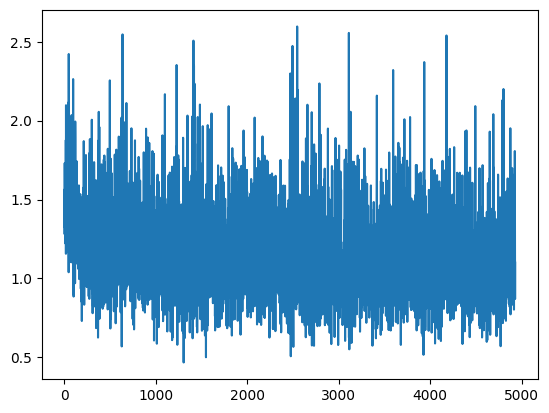

In [19]:
plt.plot(train_losses)

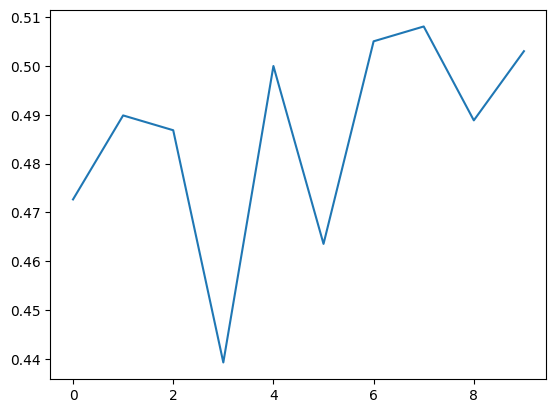

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 497/984 (0.5051)
{'acc_detail': tensor([0.5339, 0.7302, 0.6019, 0.0000], device='cuda:0'),
 'acc_unweighted': tensor(0.4665, device='cuda:0'),
 'acc_weighted': tensor(0.5051, device='cuda:0'),
 'f1s_detail': tensor([0.5476, 0.5533, 0.6032, 0.0000], device='cuda:0'),
 'f1s_unweighted': tensor(0.4260, device='cuda:0'),
 'f1s_weighted': tensor(0.4472, device='cuda:0'),
 'precision_detail': tensor([0.5619, 0.4454, 0.6047, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.5339, 0.7302, 0.6019, 0.0000], device='cuda:0'),
 'rocauc': tensor(0.7632, device='cuda:0'),
 'rocauc_detail': tensor([0.8142, 0.6844, 0.8369, 0.7171], device='cuda:0'),
 'uar': tensor(0.4665, device='cuda:0'),
 'wap': tensor(0.4133, device='cuda:0')}


tensor([[118,  95,   8,   0],
        [ 21, 249,  71,   0],
        [  6,  80, 130,   0],
        [ 65, 135,   6,   0]], device='cuda:0')

In [23]:
model_path = '../models_iemocap4/iemocap4_m13ser_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003246753246753247/50 [00:00<1:57:40, 141.23s/it]

Train Epoch: 11 [0/3948 (0%)]	Loss: 0.907462
Mem before-during-after: 41739264 2724039680 45502976


  0%|                                | 0.06818181818181819/50 [00:11<2:19:47, 167.98s/it]

Train Epoch: 11 [320/3948 (8%)]	Loss: 1.140581
Mem before-during-after: 45135360 2742939648 45103616


  0%|                                | 0.13311688311688308/50 [00:22<2:20:50, 169.45s/it]

Train Epoch: 11 [640/3948 (16%)]	Loss: 1.016430
Mem before-during-after: 45103616 2742939648 45103616


  0%|▏                               | 0.19805194805194748/50 [00:34<2:20:36, 169.40s/it]

Train Epoch: 11 [960/3948 (24%)]	Loss: 0.998812
Mem before-during-after: 45103616 2742963200 45080064


  1%|▏                               | 0.26136363636363547/50 [00:45<2:37:31, 190.02s/it]

Train Epoch: 11 [1280/3948 (32%)]	Loss: 0.919106
Mem before-during-after: 45080064 2743597056 45103616


  1%|▏                                 | 0.326298701298701/50 [00:56<2:36:34, 189.13s/it]

Train Epoch: 11 [1600/3948 (41%)]	Loss: 0.850421
Mem before-during-after: 45545984 2742939648 45080064


  1%|▎                                | 0.3928571428571431/50 [01:07<2:19:39, 168.91s/it]

Train Epoch: 11 [1920/3948 (49%)]	Loss: 0.935097
Mem before-during-after: 45306368 2742978560 45103616


  1%|▎                                 | 0.456168831168832/50 [01:18<2:35:19, 188.11s/it]

Train Epoch: 11 [2240/3948 (57%)]	Loss: 0.696770
Mem before-during-after: 45127168 2743741952 45103616


  1%|▎                                | 0.5227272727272742/50 [01:30<2:19:36, 169.31s/it]

Train Epoch: 11 [2560/3948 (65%)]	Loss: 1.207732
Mem before-during-after: 45103616 2743970816 45992448


  1%|▍                                | 0.5876623376623397/50 [01:41<2:19:05, 168.90s/it]

Train Epoch: 11 [2880/3948 (73%)]	Loss: 1.145583
Mem before-during-after: 45526528 2743165952 45329920


  1%|▍                                | 0.6509740259740285/50 [01:52<2:36:41, 190.51s/it]

Train Epoch: 11 [3200/3948 (81%)]	Loss: 0.984355
Mem before-during-after: 45545984 2742939648 45080064


  1%|▍                                | 0.7175324675324707/50 [02:03<2:24:44, 176.22s/it]

Train Epoch: 11 [3520/3948 (89%)]	Loss: 1.640490
Mem before-during-after: 45502976 2743181312 45306368


  2%|▌                                | 0.7824675324675362/50 [02:15<2:19:16, 169.79s/it]

Train Epoch: 11 [3840/3948 (97%)]	Loss: 1.012565
Mem before-during-after: 45103616 2743825920 45332480


  2%|▋                                | 1.0000000000000056/50 [02:40<1:32:19, 113.05s/it]


Test Epoch: 11	Accuracy: 513/984 (52%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_11epoch.pt


  2%|▋                                | 1.0032467532467588/50 [02:41<1:42:26, 125.45s/it]

Train Epoch: 12 [0/3948 (0%)]	Loss: 1.117584
Mem before-during-after: 45182464 2743916544 45103616


  2%|▋                                | 1.0681818181818243/50 [02:52<2:15:50, 166.57s/it]

Train Epoch: 12 [320/3948 (8%)]	Loss: 0.941630
Mem before-during-after: 45977600 2725505536 45526528


  2%|▋                                | 1.1331168831168899/50 [03:03<2:15:44, 166.67s/it]

Train Epoch: 12 [640/3948 (16%)]	Loss: 0.650986
Mem before-during-after: 45317120 2742939648 45103616


  2%|▊                                | 1.1964285714285787/50 [03:14<2:32:26, 187.42s/it]

Train Epoch: 12 [960/3948 (24%)]	Loss: 1.044972
Mem before-during-after: 45483008 2744160768 45459456


  3%|▊                                | 1.2613636363636442/50 [03:25<2:34:07, 189.75s/it]

Train Epoch: 12 [1280/3948 (32%)]	Loss: 1.074564
Mem before-during-after: 45317120 2743908352 45080064


  3%|▉                                | 1.3262987012987097/50 [03:37<2:33:19, 189.00s/it]

Train Epoch: 12 [1600/3948 (41%)]	Loss: 1.150257
Mem before-during-after: 45306368 2742916096 45080064


  3%|▉                                 | 1.392857142857152/50 [03:48<2:16:47, 168.86s/it]

Train Epoch: 12 [1920/3948 (49%)]	Loss: 0.693879
Mem before-during-after: 45306368 2743261696 45337600


  3%|▉                                | 1.4577922077922174/50 [03:59<2:15:36, 167.62s/it]

Train Epoch: 12 [2240/3948 (57%)]	Loss: 1.007076
Mem before-during-after: 45532672 2744462848 45532672


  3%|█                                | 1.5211038961039063/50 [04:10<2:31:42, 187.76s/it]

Train Epoch: 12 [2560/3948 (65%)]	Loss: 1.116584
Mem before-during-after: 45532672 2744462848 45532672


  3%|█                                | 1.5860389610389718/50 [04:21<2:30:52, 186.98s/it]

Train Epoch: 12 [2880/3948 (73%)]	Loss: 0.784184
Mem before-during-after: 45532672 2744462848 45532672


  3%|█                                 | 1.652597402597414/50 [04:33<2:15:05, 167.65s/it]

Train Epoch: 12 [3200/3948 (81%)]	Loss: 1.190476
Mem before-during-after: 45925888 2743814656 45532672


  3%|█▏                               | 1.7175324675324795/50 [04:44<2:19:00, 172.75s/it]

Train Epoch: 12 [3520/3948 (89%)]	Loss: 0.827189
Mem before-during-after: 45532672 2744462848 45532672


  4%|█▏                                | 1.782467532467545/50 [04:55<2:13:47, 166.49s/it]

Train Epoch: 12 [3840/3948 (97%)]	Loss: 0.960477
Mem before-during-after: 45532672 2744581632 45532672


  4%|█▎                                | 2.000000000000014/50 [05:21<1:29:09, 111.45s/it]


Test Epoch: 12	Accuracy: 519/984 (53%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_12epoch.pt


  4%|█▎                                | 2.003246753246767/50 [05:21<1:39:22, 124.23s/it]

Train Epoch: 13 [0/3948 (0%)]	Loss: 1.035138
Mem before-during-after: 45325312 2743869440 45103616


  4%|█▎                               | 2.0665584415584473/50 [05:32<2:27:38, 184.80s/it]

Train Epoch: 13 [320/3948 (8%)]	Loss: 1.094460
Mem before-during-after: 45080064 2725481984 45502976


  4%|█▍                                | 2.131493506493504/50 [05:43<2:31:16, 189.62s/it]

Train Epoch: 13 [640/3948 (16%)]	Loss: 1.290065
Mem before-during-after: 45329920 2727264256 45526528


  4%|█▍                                | 2.198051948051937/50 [05:54<2:12:53, 166.79s/it]

Train Epoch: 13 [960/3948 (24%)]	Loss: 0.982551
Mem before-during-after: 45740032 2743355904 45306368


  5%|█▍                               | 2.2629870129869936/50 [06:06<2:13:58, 168.40s/it]

Train Epoch: 13 [1280/3948 (32%)]	Loss: 1.079089
Mem before-during-after: 45502976 2743394816 45356032


  5%|█▌                               | 2.3262987012986738/50 [06:17<2:28:09, 186.47s/it]

Train Epoch: 13 [1600/3948 (41%)]	Loss: 1.106905
Mem before-during-after: 45329920 2742916096 45080064


  5%|█▌                               | 2.3912337662337304/50 [06:28<2:30:29, 189.66s/it]

Train Epoch: 13 [1920/3948 (49%)]	Loss: 0.761677
Mem before-during-after: 45103616 2743168512 45103616


  5%|█▌                               | 2.4577922077921635/50 [06:39<2:12:30, 167.22s/it]

Train Epoch: 13 [2240/3948 (57%)]	Loss: 0.678455
Mem before-during-after: 45340672 2744510464 46064128


  5%|█▊                                 | 2.52272727272722/50 [06:50<2:17:57, 174.34s/it]

Train Epoch: 13 [2560/3948 (65%)]	Loss: 1.215265
Mem before-during-after: 45317120 2743908352 45080064


  5%|█▋                               | 2.5876623376622767/50 [07:01<2:13:25, 168.85s/it]

Train Epoch: 13 [2880/3948 (73%)]	Loss: 1.219740
Mem before-during-after: 45502976 2743142400 45306368


  5%|█▊                               | 2.6525974025973333/50 [07:13<2:13:03, 168.62s/it]

Train Epoch: 13 [3200/3948 (81%)]	Loss: 0.846843
Mem before-during-after: 45545984 2742939648 45080064


  5%|█▊                               | 2.7159090909090136/50 [07:24<2:27:36, 187.30s/it]

Train Epoch: 13 [3520/3948 (89%)]	Loss: 1.711835
Mem before-during-after: 45080064 2725481984 45502976


  6%|█▊                               | 2.7824675324674466/50 [07:35<2:13:22, 169.49s/it]

Train Epoch: 13 [3840/3948 (97%)]	Loss: 1.326521
Mem before-during-after: 45080064 2744350720 45545984


  6%|█▉                               | 2.9999999999998863/50 [08:01<1:27:18, 111.46s/it]


Test Epoch: 13	Accuracy: 511/984 (52%)



  6%|██                                | 3.003246753246639/50 [08:01<1:38:40, 125.98s/it]

Train Epoch: 14 [0/3948 (0%)]	Loss: 0.735234
Mem before-during-after: 45120000 2743655936 45095424


  6%|██                               | 3.0681818181816958/50 [08:13<2:11:16, 167.82s/it]

Train Epoch: 14 [320/3948 (8%)]	Loss: 1.226951
Mem before-during-after: 45103616 2743994880 45229568


  6%|██▏                               | 3.131493506493376/50 [08:24<2:28:10, 189.70s/it]

Train Epoch: 14 [640/3948 (16%)]	Loss: 1.155037
Mem before-during-after: 45118976 2743239168 45118976


  6%|██▏                               | 3.198051948051809/50 [08:35<2:09:38, 166.19s/it]

Train Epoch: 14 [960/3948 (24%)]	Loss: 0.837446
Mem before-during-after: 45103616 2744957440 45329920


  7%|██▏                              | 3.2629870129868657/50 [08:46<2:09:48, 166.65s/it]

Train Epoch: 14 [1280/3948 (32%)]	Loss: 1.138612
Mem before-during-after: 45532672 2743876096 45532672


  7%|██▏                              | 3.3279220779219223/50 [08:57<2:10:55, 168.31s/it]

Train Epoch: 14 [1600/3948 (41%)]	Loss: 1.072632
Mem before-during-after: 45532672 2743659520 45532672


  7%|██▎                               | 3.392857142856979/50 [09:09<2:10:31, 168.03s/it]

Train Epoch: 14 [1920/3948 (49%)]	Loss: 1.067637
Mem before-during-after: 45532672 2743659520 45532672


  7%|██▎                              | 3.4577922077920356/50 [09:20<2:08:33, 165.74s/it]

Train Epoch: 14 [2240/3948 (57%)]	Loss: 0.525075
Mem before-during-after: 45532672 2726527488 45925888


  7%|██▍                               | 3.522727272727092/50 [09:31<2:10:51, 168.92s/it]

Train Epoch: 14 [2560/3948 (65%)]	Loss: 1.189265
Mem before-during-after: 45532672 2743778304 45532672


  7%|██▍                               | 3.587662337662149/50 [09:42<2:09:48, 167.81s/it]

Train Epoch: 14 [2880/3948 (73%)]	Loss: 1.006807
Mem before-during-after: 45532672 2743659520 45532672


  7%|██▍                              | 3.6525974025972054/50 [09:53<2:10:25, 168.85s/it]

Train Epoch: 14 [3200/3948 (81%)]	Loss: 1.285827
Mem before-during-after: 45532672 2743659520 45532672


  7%|██▌                               | 3.717532467532262/50 [10:05<2:12:01, 171.16s/it]

Train Epoch: 14 [3520/3948 (89%)]	Loss: 0.803094
Mem before-during-after: 45532672 2743778304 45532672


  8%|██▍                              | 3.7824675324673187/50 [10:16<2:07:52, 166.02s/it]

Train Epoch: 14 [3840/3948 (97%)]	Loss: 0.953177
Mem before-during-after: 45532672 2743844864 45329920


  8%|██▋                              | 3.9999999999997584/50 [10:41<1:26:29, 112.81s/it]


Test Epoch: 14	Accuracy: 518/984 (52%)



  8%|██▋                               | 4.003246753246511/50 [10:42<1:37:33, 127.27s/it]

Train Epoch: 15 [0/3948 (0%)]	Loss: 1.160689
Mem before-during-after: 45072896 2743593472 45080064


  8%|██▊                               | 4.068181818181568/50 [10:53<2:10:05, 169.94s/it]

Train Epoch: 15 [320/3948 (8%)]	Loss: 0.885805
Mem before-during-after: 45306368 2743230464 45306368


  8%|██▋                              | 4.1331168831166245/50 [11:04<2:08:34, 168.20s/it]

Train Epoch: 15 [640/3948 (16%)]	Loss: 0.870619
Mem before-during-after: 45306368 2743230464 45306368


  8%|██▊                               | 4.196428571428305/50 [11:15<2:23:34, 188.09s/it]

Train Epoch: 15 [960/3948 (24%)]	Loss: 1.267159
Mem before-during-after: 45306368 2743230464 45306368


  9%|██▉                               | 4.261363636363361/50 [11:26<2:23:15, 187.92s/it]

Train Epoch: 15 [1280/3948 (32%)]	Loss: 1.050420
Mem before-during-after: 45306368 2743433216 45306368


  9%|██▉                               | 4.327922077921794/50 [11:38<2:14:26, 176.62s/it]

Train Epoch: 15 [1600/3948 (41%)]	Loss: 0.906021
Mem before-during-after: 45532672 2744540672 46413824


  9%|██▉                               | 4.392857142856851/50 [11:49<2:08:12, 168.66s/it]

Train Epoch: 15 [1920/3948 (49%)]	Loss: 1.067499
Mem before-during-after: 45532672 2743814656 45532672


  9%|███                               | 4.457792207791908/50 [12:00<2:09:46, 170.97s/it]

Train Epoch: 15 [2240/3948 (57%)]	Loss: 1.129576
Mem before-during-after: 45532672 2743814656 45532672


  9%|███                               | 4.522727272726964/50 [12:11<2:08:08, 169.06s/it]

Train Epoch: 15 [2560/3948 (65%)]	Loss: 1.619575
Mem before-during-after: 46327296 2743814656 45532672


  9%|███                               | 4.587662337662021/50 [12:23<2:08:05, 169.25s/it]

Train Epoch: 15 [2880/3948 (73%)]	Loss: 1.049895
Mem before-during-after: 45532672 2743814656 45532672


  9%|███                              | 4.6525974025970775/50 [12:34<2:07:33, 168.77s/it]

Train Epoch: 15 [3200/3948 (81%)]	Loss: 0.980241
Mem before-during-after: 45532672 2743814656 45532672


  9%|███▏                              | 4.717532467532134/50 [12:45<2:07:03, 168.35s/it]

Train Epoch: 15 [3520/3948 (89%)]	Loss: 0.818271
Mem before-during-after: 45532672 2743659520 45532672


 10%|███▎                              | 4.782467532467191/50 [12:56<2:08:42, 170.78s/it]

Train Epoch: 15 [3840/3948 (97%)]	Loss: 0.862847
Mem before-during-after: 45532672 2743814656 45532672


 10%|███▎                             | 4.9999999999996305/50 [13:22<1:24:13, 112.30s/it]


Test Epoch: 15	Accuracy: 521/984 (53%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_15epoch.pt


 10%|███▍                              | 5.003246753246383/50 [13:23<1:34:32, 126.06s/it]

Train Epoch: 16 [0/3948 (0%)]	Loss: 0.888249
Mem before-during-after: 45072896 2744609280 45103616


 10%|███▌                               | 5.06818181818144/50 [13:34<2:05:09, 167.14s/it]

Train Epoch: 16 [320/3948 (8%)]	Loss: 0.810683
Mem before-during-after: 45306368 2743588352 45306368


 10%|███▌                               | 5.13149350649312/50 [13:45<2:20:46, 188.26s/it]

Train Epoch: 16 [640/3948 (16%)]	Loss: 1.353631
Mem before-during-after: 45306368 2726280192 45502976


 10%|███▌                              | 5.196428571428177/50 [13:56<2:20:45, 188.50s/it]

Train Epoch: 16 [960/3948 (24%)]	Loss: 0.763672
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▍                             | 5.2613636363632335/50 [14:07<2:19:32, 187.15s/it]

Train Epoch: 16 [1280/3948 (32%)]	Loss: 1.336374
Mem before-during-after: 45306368 2726280192 45502976


 11%|███▋                               | 5.32629870129829/50 [14:18<2:20:17, 188.41s/it]

Train Epoch: 16 [1600/3948 (41%)]	Loss: 1.290186
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▋                              | 5.392857142856723/50 [14:30<2:04:23, 167.32s/it]

Train Epoch: 16 [1920/3948 (49%)]	Loss: 0.773986
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▊                               | 5.45779220779178/50 [14:41<2:04:29, 167.71s/it]

Train Epoch: 16 [2240/3948 (57%)]	Loss: 0.654258
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▊                              | 5.522727272726836/50 [14:52<2:04:37, 168.11s/it]

Train Epoch: 16 [2560/3948 (65%)]	Loss: 0.822469
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▊                              | 5.587662337661893/50 [15:03<2:04:14, 167.85s/it]

Train Epoch: 16 [2880/3948 (73%)]	Loss: 0.757614
Mem before-during-after: 45306368 2743588352 45306368


 11%|███▉                               | 5.65259740259695/50 [15:14<2:06:58, 171.78s/it]

Train Epoch: 16 [3200/3948 (81%)]	Loss: 0.949123
Mem before-during-after: 45502976 2743588352 45306368


 11%|███▉                              | 5.717532467532006/50 [15:26<2:06:59, 172.07s/it]

Train Epoch: 16 [3520/3948 (89%)]	Loss: 1.001198
Mem before-during-after: 45306368 2743588352 45306368


 12%|███▊                             | 5.7808441558436865/50 [15:37<2:20:51, 191.13s/it]

Train Epoch: 16 [3840/3948 (97%)]	Loss: 1.263637
Mem before-during-after: 45306368 2743588352 45306368


 12%|████                              | 5.999999999999503/50 [16:03<1:22:12, 112.10s/it]


Test Epoch: 16	Accuracy: 511/984 (52%)



 12%|████                              | 6.001623376622879/50 [16:03<1:37:10, 132.52s/it]

Train Epoch: 17 [0/3948 (0%)]	Loss: 1.102835
Mem before-during-after: 45072896 2743593472 45080064


 12%|████▏                             | 6.068181818181312/50 [16:14<2:04:13, 169.66s/it]

Train Epoch: 17 [320/3948 (8%)]	Loss: 0.851660
Mem before-during-after: 45306368 2744273408 45353472


 12%|████▏                             | 6.133116883116369/50 [16:26<2:03:57, 169.56s/it]

Train Epoch: 17 [640/3948 (16%)]	Loss: 1.113545
Mem before-during-after: 45306368 2743345152 45306368


 12%|████▏                             | 6.198051948051425/50 [16:37<2:05:25, 171.80s/it]

Train Epoch: 17 [960/3948 (24%)]	Loss: 1.173502
Mem before-during-after: 45306368 2743588352 45306368


 13%|████▎                             | 6.261363636363106/50 [16:48<2:17:58, 189.27s/it]

Train Epoch: 17 [1280/3948 (32%)]	Loss: 0.968417
Mem before-during-after: 45306368 2743588352 45306368


 13%|████▎                             | 6.327922077921539/50 [16:59<2:02:27, 168.24s/it]

Train Epoch: 17 [1600/3948 (41%)]	Loss: 0.919865
Mem before-during-after: 45306368 2743588352 45306368


 13%|████▎                             | 6.391233766233219/50 [17:10<2:16:51, 188.30s/it]

Train Epoch: 17 [1920/3948 (49%)]	Loss: 0.980311
Mem before-during-after: 45740032 2743814656 45532672


 13%|████▎                            | 6.4561688311682754/50 [17:22<2:16:41, 188.36s/it]

Train Epoch: 17 [2240/3948 (57%)]	Loss: 1.192276
Mem before-during-after: 45306368 2743081984 45103616


 13%|████▎                            | 6.5227272727267085/50 [17:33<2:05:41, 173.46s/it]

Train Epoch: 17 [2560/3948 (65%)]	Loss: 0.660000
Mem before-during-after: 45306368 2726280192 45502976


 13%|████▍                             | 6.586038961038389/50 [17:44<2:17:09, 189.55s/it]

Train Epoch: 17 [2880/3948 (73%)]	Loss: 0.898681
Mem before-during-after: 45306368 2743142400 45306368


 13%|████▌                             | 6.652597402596822/50 [17:55<1:58:17, 163.73s/it]

Train Epoch: 17 [3200/3948 (81%)]	Loss: 0.817481
Mem before-during-after: 45080064 2743230464 45306368


 13%|████▌                             | 6.717532467531878/50 [18:07<2:02:31, 169.85s/it]

Train Epoch: 17 [3520/3948 (89%)]	Loss: 1.012188
Mem before-during-after: 45306368 2743230464 45306368


 14%|████▌                             | 6.782467532466935/50 [18:18<2:02:34, 170.18s/it]

Train Epoch: 17 [3840/3948 (97%)]	Loss: 1.411475
Mem before-during-after: 45306368 2743230464 45306368


 14%|████▊                             | 6.999999999999375/50 [18:43<1:20:04, 111.73s/it]


Test Epoch: 17	Accuracy: 514/984 (52%)



 14%|████▌                            | 7.0032467532461276/50 [18:44<1:31:05, 127.11s/it]

Train Epoch: 18 [0/3948 (0%)]	Loss: 1.315706
Mem before-during-after: 45072896 2743593472 45080064


 14%|████▊                             | 7.068181818181184/50 [18:55<1:59:05, 166.45s/it]

Train Epoch: 18 [320/3948 (8%)]	Loss: 0.971402
Mem before-during-after: 45502976 2661593088 45080064


 14%|████▊                             | 7.133116883116241/50 [19:06<1:59:03, 166.64s/it]

Train Epoch: 18 [640/3948 (16%)]	Loss: 0.937088
Mem before-during-after: 45306368 2743433216 45306368


 14%|████▉                             | 7.198051948051297/50 [19:17<2:00:21, 168.71s/it]

Train Epoch: 18 [960/3948 (24%)]	Loss: 1.149587
Mem before-during-after: 45306368 2743588352 45306368


 15%|████▉                             | 7.262987012986354/50 [19:29<1:58:35, 166.50s/it]

Train Epoch: 18 [1280/3948 (32%)]	Loss: 1.376820
Mem before-during-after: 45532672 2744453632 45532672


 15%|████▉                             | 7.327922077921411/50 [19:40<2:01:56, 171.45s/it]

Train Epoch: 18 [1600/3948 (41%)]	Loss: 1.090648
Mem before-during-after: 45354496 2743814656 45532672


 15%|█████                             | 7.392857142856467/50 [19:51<2:02:55, 173.10s/it]

Train Epoch: 18 [1920/3948 (49%)]	Loss: 1.448369
Mem before-during-after: 45532672 2432724992 45306368


 15%|█████                             | 7.457792207791524/50 [20:02<1:58:30, 167.15s/it]

Train Epoch: 18 [2240/3948 (57%)]	Loss: 1.478668
Mem before-during-after: 45532672 2726461440 45925888


 15%|█████                             | 7.522727272726581/50 [20:13<1:57:58, 166.65s/it]

Train Epoch: 18 [2560/3948 (65%)]	Loss: 0.862795
Mem before-during-after: 45532672 2744453632 45532672


 15%|█████▏                            | 7.587662337661637/50 [20:24<1:58:17, 167.35s/it]

Train Epoch: 18 [2880/3948 (73%)]	Loss: 0.949810
Mem before-during-after: 45532672 2743814656 45532672


 15%|█████▏                            | 7.652597402596694/50 [20:36<2:00:51, 171.23s/it]

Train Epoch: 18 [3200/3948 (81%)]	Loss: 0.921587
Mem before-during-after: 45532672 2725708288 45925888


 15%|█████▏                            | 7.715909090908374/50 [20:47<2:10:54, 185.75s/it]

Train Epoch: 18 [3520/3948 (89%)]	Loss: 0.712978
Mem before-during-after: 45925888 2744633856 45532672


 16%|█████▎                            | 7.782467532466807/50 [20:58<1:57:57, 167.63s/it]

Train Epoch: 18 [3840/3948 (97%)]	Loss: 0.968726
Mem before-during-after: 45532672 2725708288 45925888


 16%|█████▍                            | 7.999999999999247/50 [21:24<1:20:37, 115.17s/it]


Test Epoch: 18	Accuracy: 523/984 (53%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_18epoch.pt


 16%|█████▍                            | 8.001623376622623/50 [21:24<1:33:04, 132.97s/it]

Train Epoch: 19 [0/3948 (0%)]	Loss: 1.272760
Mem before-during-after: 45072896 2743593472 45080064


 16%|█████▍                            | 8.068181818181056/50 [21:36<1:58:02, 168.90s/it]

Train Epoch: 19 [320/3948 (8%)]	Loss: 0.872409
Mem before-during-after: 45306368 2743776256 45329920


 16%|█████▌                            | 8.133116883116113/50 [21:47<1:58:03, 169.18s/it]

Train Epoch: 19 [640/3948 (16%)]	Loss: 1.079609
Mem before-during-after: 45333504 2743230464 45306368


 16%|█████▋                             | 8.19805194805117/50 [21:58<1:57:19, 168.40s/it]

Train Epoch: 19 [960/3948 (24%)]	Loss: 1.020050
Mem before-during-after: 45502976 2743433216 45306368


 17%|█████▊                             | 8.26136363636285/50 [22:09<2:12:40, 190.73s/it]

Train Epoch: 19 [1280/3948 (32%)]	Loss: 1.136868
Mem before-during-after: 45329920 2745254912 46298624


 17%|█████▋                            | 8.327922077921283/50 [22:20<1:55:54, 166.88s/it]

Train Epoch: 19 [1600/3948 (41%)]	Loss: 0.867033
Mem before-during-after: 45532672 2743978496 45532672


 17%|█████▊                             | 8.39285714285634/50 [22:31<1:56:26, 167.91s/it]

Train Epoch: 19 [1920/3948 (49%)]	Loss: 1.260581
Mem before-during-after: 45696512 2744855552 45532672


 17%|█████▊                            | 8.457792207791396/50 [22:43<1:56:18, 167.99s/it]

Train Epoch: 19 [2240/3948 (57%)]	Loss: 0.882959
Mem before-during-after: 45532672 2743814656 45532672


 17%|█████▊                            | 8.522727272726453/50 [22:54<1:55:03, 166.43s/it]

Train Epoch: 19 [2560/3948 (65%)]	Loss: 1.247141
Mem before-during-after: 45532672 2744855552 45532672


 17%|██████                             | 8.58766233766151/50 [23:05<1:56:06, 168.22s/it]

Train Epoch: 19 [2880/3948 (73%)]	Loss: 0.986671
Mem before-during-after: 45532672 2744855552 45532672


 17%|██████                             | 8.65097402597319/50 [23:16<2:11:47, 191.23s/it]

Train Epoch: 19 [3200/3948 (81%)]	Loss: 0.998163
Mem before-during-after: 45532672 2743814656 45532672


 17%|█████▉                            | 8.717532467531623/50 [23:27<1:55:39, 168.10s/it]

Train Epoch: 19 [3520/3948 (89%)]	Loss: 0.896706
Mem before-during-after: 45532672 2743814656 45532672


 18%|██████▏                            | 8.78246753246668/50 [23:39<1:57:09, 170.54s/it]

Train Epoch: 19 [3840/3948 (97%)]	Loss: 1.016833
Mem before-during-after: 45532672 2744855552 45532672


 18%|██████                            | 8.999999999999119/50 [24:04<1:16:04, 111.32s/it]


Test Epoch: 19	Accuracy: 511/984 (52%)



 18%|██████                            | 9.003246753245872/50 [24:05<1:26:38, 126.80s/it]

Train Epoch: 20 [0/3948 (0%)]	Loss: 1.357913
Mem before-during-after: 45072896 2743593472 45080064


 18%|██████▏                           | 9.068181818180928/50 [24:16<1:55:57, 169.97s/it]

Train Epoch: 20 [320/3948 (8%)]	Loss: 0.984119
Mem before-during-after: 45329920 2742939648 45103616


 18%|██████▏                           | 9.133116883115985/50 [24:27<1:54:16, 167.77s/it]

Train Epoch: 20 [640/3948 (16%)]	Loss: 0.967938
Mem before-during-after: 45329920 2743165952 45329920


 18%|██████▎                           | 9.198051948051042/50 [24:39<1:55:36, 170.02s/it]

Train Epoch: 20 [960/3948 (24%)]	Loss: 0.727158
Mem before-during-after: 45329920 2743254016 45329920


 19%|██████▎                           | 9.262987012986098/50 [24:50<1:53:58, 167.88s/it]

Train Epoch: 20 [1280/3948 (32%)]	Loss: 1.404726
Mem before-during-after: 45103616 2742939648 45103616


 19%|██████▎                           | 9.327922077921155/50 [25:01<1:54:51, 169.43s/it]

Train Epoch: 20 [1600/3948 (41%)]	Loss: 0.753348
Mem before-during-after: 45340672 2742939648 45103616


 19%|██████▍                           | 9.391233766232835/50 [25:12<2:08:26, 189.77s/it]

Train Epoch: 20 [1920/3948 (49%)]	Loss: 1.148982
Mem before-during-after: 45905408 2743267840 45080064


 19%|██████▍                           | 9.457792207791268/50 [25:23<1:54:23, 169.30s/it]

Train Epoch: 20 [2240/3948 (57%)]	Loss: 1.254279
Mem before-during-after: 45532672 2743456768 45532672


 19%|██████▍                           | 9.522727272726325/50 [25:34<1:52:58, 167.47s/it]

Train Epoch: 20 [2560/3948 (65%)]	Loss: 0.963854
Mem before-during-after: 45532672 2743659520 45532672


 19%|██████▌                           | 9.587662337661381/50 [25:46<1:53:18, 168.22s/it]

Train Epoch: 20 [2880/3948 (73%)]	Loss: 1.125530
Mem before-during-after: 45532672 2743659520 45532672


 19%|██████▌                           | 9.652597402596438/50 [25:57<1:52:56, 167.96s/it]

Train Epoch: 20 [3200/3948 (81%)]	Loss: 1.180558
Mem before-during-after: 46327296 2743814656 45532672


 19%|██████▌                           | 9.717532467531495/50 [26:08<1:53:17, 168.74s/it]

Train Epoch: 20 [3520/3948 (89%)]	Loss: 1.069608
Mem before-during-after: 45532672 2743814656 45532672


 20%|██████▋                           | 9.780844155843175/50 [26:19<2:07:38, 190.42s/it]

Train Epoch: 20 [3840/3948 (97%)]	Loss: 0.927857
Mem before-during-after: 45532672 2743814656 45532672


 20%|██████▊                           | 9.999999999998991/50 [26:45<1:13:33, 110.33s/it]


Test Epoch: 20	Accuracy: 518/984 (52%)



 20%|██████▌                          | 10.003246753245744/50 [26:45<1:25:09, 127.75s/it]

Train Epoch: 21 [0/3948 (0%)]	Loss: 1.230646
Mem before-during-after: 45072896 2744609280 45103616


 20%|███████                            | 10.0681818181808/50 [26:57<1:51:44, 167.90s/it]

Train Epoch: 21 [320/3948 (8%)]	Loss: 1.030367
Mem before-during-after: 45329920 2743454208 45329920


 20%|██████▋                          | 10.133116883115857/50 [27:08<1:53:29, 170.82s/it]

Train Epoch: 21 [640/3948 (16%)]	Loss: 1.418237
Mem before-during-after: 45329920 2743454208 45329920


 20%|██████▋                          | 10.196428571427537/50 [27:19<2:07:31, 192.23s/it]

Train Epoch: 21 [960/3948 (24%)]	Loss: 0.936158
Mem before-during-after: 45329920 2743456768 45329920


 21%|██████▉                           | 10.26298701298597/50 [27:31<2:15:20, 204.35s/it]

Train Epoch: 21 [1280/3948 (32%)]	Loss: 1.046539
Mem before-during-after: 45532672 2743814656 45532672


 21%|██████▊                          | 10.327922077921027/50 [27:43<1:53:37, 171.85s/it]

Train Epoch: 21 [1600/3948 (41%)]	Loss: 0.791814
Mem before-during-after: 45532672 2743814656 45532672


 21%|██████▊                          | 10.391233766232707/50 [27:55<2:10:16, 197.35s/it]

Train Epoch: 21 [1920/3948 (49%)]	Loss: 0.877263
Mem before-during-after: 45532672 2743814656 45532672


 21%|███████                           | 10.45779220779114/50 [28:07<1:57:05, 177.68s/it]

Train Epoch: 21 [2240/3948 (57%)]	Loss: 1.111318
Mem before-during-after: 45532672 2743814656 45532672


 21%|██████▉                          | 10.522727272726197/50 [28:18<1:48:42, 165.22s/it]

Train Epoch: 21 [2560/3948 (65%)]	Loss: 1.258659
Mem before-during-after: 46141440 2743814656 45532672


 21%|██████▉                          | 10.587662337661254/50 [28:29<1:50:09, 167.71s/it]

Train Epoch: 21 [2880/3948 (73%)]	Loss: 0.954251
Mem before-during-after: 45532672 2743659520 45532672


 21%|███████▏                          | 10.65259740259631/50 [28:40<1:49:41, 167.26s/it]

Train Epoch: 21 [3200/3948 (81%)]	Loss: 0.832825
Mem before-during-after: 45532672 2743659520 45532672


 21%|███████                          | 10.717532467531367/50 [28:51<1:50:04, 168.13s/it]

Train Epoch: 21 [3520/3948 (89%)]	Loss: 1.127354
Mem before-during-after: 45925888 2744322560 45532672


 22%|███████                          | 10.780844155843047/50 [29:02<2:02:59, 188.17s/it]

Train Epoch: 21 [3840/3948 (97%)]	Loss: 1.025090
Mem before-during-after: 45329920 2743456768 45532672


 22%|███████▎                         | 10.999999999998863/50 [29:29<1:13:45, 113.47s/it]


Test Epoch: 21	Accuracy: 523/984 (53%)



 22%|███████▍                          | 11.00162337662224/50 [29:29<1:25:30, 131.56s/it]

Train Epoch: 22 [0/3948 (0%)]	Loss: 1.597143
Mem before-during-after: 45072896 2743593472 45080064


 22%|███████▎                         | 11.066558441557296/50 [29:40<2:02:55, 189.44s/it]

Train Epoch: 22 [320/3948 (8%)]	Loss: 1.065961
Mem before-during-after: 45306368 2725928448 45502976


 22%|███████▌                          | 11.13311688311573/50 [29:52<1:49:35, 169.19s/it]

Train Epoch: 22 [640/3948 (16%)]	Loss: 0.958404
Mem before-during-after: 45306368 2743345152 45306368


 22%|███████▍                         | 11.198051948050786/50 [30:03<1:50:14, 170.46s/it]

Train Epoch: 22 [960/3948 (24%)]	Loss: 0.996578
Mem before-during-after: 45306368 2743345152 45306368


 23%|███████▍                         | 11.261363636362466/50 [30:14<2:02:05, 189.11s/it]

Train Epoch: 22 [1280/3948 (32%)]	Loss: 0.985620
Mem before-during-after: 45306368 2743345152 45306368


 23%|███████▍                         | 11.326298701297523/50 [30:25<2:02:37, 190.25s/it]

Train Epoch: 22 [1600/3948 (41%)]	Loss: 1.044496
Mem before-during-after: 45317120 2743433216 45306368


 23%|███████▌                         | 11.392857142855956/50 [30:36<1:47:51, 167.62s/it]

Train Epoch: 22 [1920/3948 (49%)]	Loss: 1.473679
Mem before-during-after: 45532672 2744004608 45532672


 23%|███████▌                         | 11.456168831167636/50 [30:47<2:01:23, 188.98s/it]

Train Epoch: 22 [2240/3948 (57%)]	Loss: 1.626907
Mem before-during-after: 45532672 2743814656 45532672


 23%|███████▌                         | 11.521103896102693/50 [30:59<2:01:20, 189.21s/it]

Train Epoch: 22 [2560/3948 (65%)]	Loss: 1.334160
Mem before-during-after: 45532672 2744244736 45532672


 23%|███████▉                          | 11.58603896103775/50 [31:10<2:00:16, 187.86s/it]

Train Epoch: 22 [2880/3948 (73%)]	Loss: 1.515302
Mem before-during-after: 45925888 2744581632 45532672


 23%|███████▋                         | 11.650974025972806/50 [31:21<1:57:49, 184.36s/it]

Train Epoch: 22 [3200/3948 (81%)]	Loss: 0.625317
Mem before-during-after: 46327296 2660794880 45711872


 23%|███████▋                         | 11.717532467531239/50 [31:32<1:46:53, 167.54s/it]

Train Epoch: 22 [3520/3948 (89%)]	Loss: 1.212958
Mem before-during-after: 45306368 2743230464 45306368


 24%|███████▊                         | 11.782467532466296/50 [31:43<1:46:26, 167.10s/it]

Train Epoch: 22 [3840/3948 (97%)]	Loss: 0.813203
Mem before-during-after: 45306368 2743230464 45306368


 24%|███████▉                         | 11.999999999998735/50 [32:09<1:15:40, 119.49s/it]


Test Epoch: 22	Accuracy: 534/984 (54%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_22epoch.pt


 24%|███████▉                         | 12.003246753245488/50 [32:10<1:20:48, 127.60s/it]

Train Epoch: 23 [0/3948 (0%)]	Loss: 0.944706
Mem before-during-after: 45072896 2726696448 45502976


 24%|███████▉                         | 12.066558441557168/50 [32:21<1:58:44, 187.82s/it]

Train Epoch: 23 [320/3948 (8%)]	Loss: 1.573112
Mem before-during-after: 45306368 2743588352 45306368


 24%|████████                         | 12.131493506492225/50 [32:32<1:58:45, 188.16s/it]

Train Epoch: 23 [640/3948 (16%)]	Loss: 1.137513
Mem before-during-after: 45306368 2743588352 45306368


 24%|████████                         | 12.196428571427282/50 [32:43<1:58:01, 187.33s/it]

Train Epoch: 23 [960/3948 (24%)]	Loss: 1.444850
Mem before-during-after: 45306368 2743588352 45306368


 25%|████████                         | 12.261363636362338/50 [32:54<1:59:30, 190.00s/it]

Train Epoch: 23 [1280/3948 (32%)]	Loss: 1.176864
Mem before-during-after: 45532672 2743814656 45532672


 25%|████████▏                        | 12.327922077920771/50 [33:05<1:45:37, 168.23s/it]

Train Epoch: 23 [1600/3948 (41%)]	Loss: 1.110040
Mem before-during-after: 45532672 2743814656 45532672


 25%|████████▏                        | 12.391233766232451/50 [33:16<1:56:20, 185.62s/it]

Train Epoch: 23 [1920/3948 (49%)]	Loss: 1.099587
Mem before-during-after: 45532672 2726875648 46327296


 25%|████████▏                        | 12.456168831167508/50 [33:27<1:57:03, 187.08s/it]

Train Epoch: 23 [2240/3948 (57%)]	Loss: 1.256397
Mem before-during-after: 45532672 2726875648 46327296


 25%|████████▎                        | 12.522727272725941/50 [33:39<1:45:13, 168.47s/it]

Train Epoch: 23 [2560/3948 (65%)]	Loss: 1.101288
Mem before-during-after: 45532672 2743814656 45532672


 25%|████████▎                        | 12.587662337660998/50 [33:50<1:46:29, 170.78s/it]

Train Epoch: 23 [2880/3948 (73%)]	Loss: 1.115706
Mem before-during-after: 45532672 2743814656 45532672


 25%|████████▎                        | 12.650974025972678/50 [34:01<1:56:51, 187.73s/it]

Train Epoch: 23 [3200/3948 (81%)]	Loss: 1.126150
Mem before-during-after: 45532672 2743814656 45532672


 25%|████████▍                        | 12.715909090907735/50 [34:12<1:58:15, 190.32s/it]

Train Epoch: 23 [3520/3948 (89%)]	Loss: 0.906036
Mem before-during-after: 45532672 2743814656 45532672


 26%|████████▍                        | 12.782467532466168/50 [34:23<1:43:46, 167.31s/it]

Train Epoch: 23 [3840/3948 (97%)]	Loss: 0.604960
Mem before-during-after: 46327296 2743814656 45532672


 26%|████████▌                        | 12.999999999998607/50 [34:49<1:12:44, 117.96s/it]


Test Epoch: 23	Accuracy: 530/984 (54%)



 26%|████████▊                         | 13.00324675324536/50 [34:50<1:18:46, 127.77s/it]

Train Epoch: 24 [0/3948 (0%)]	Loss: 0.934484
Mem before-during-after: 45072896 2744609280 45103616


 26%|████████▌                        | 13.068181818180417/50 [35:01<1:43:46, 168.60s/it]

Train Epoch: 24 [320/3948 (8%)]	Loss: 0.720321
Mem before-during-after: 45306368 2743345152 45306368


 26%|████████▋                        | 13.133116883115473/50 [35:12<1:42:06, 166.17s/it]

Train Epoch: 24 [640/3948 (16%)]	Loss: 0.883139
Mem before-during-after: 45306368 2743433216 45306368


 26%|████████▉                         | 13.19805194805053/50 [35:23<1:41:52, 166.10s/it]

Train Epoch: 24 [960/3948 (24%)]	Loss: 0.727741
Mem before-during-after: 45306368 2743588352 45306368


 27%|█████████                         | 13.26136363636221/50 [35:34<1:54:51, 187.59s/it]

Train Epoch: 24 [1280/3948 (32%)]	Loss: 1.410236
Mem before-during-after: 45306368 2743588352 45306368


 27%|████████▊                        | 13.327922077920643/50 [35:46<1:44:46, 171.43s/it]

Train Epoch: 24 [1600/3948 (41%)]	Loss: 0.892897
Mem before-during-after: 45306368 2743588352 45306368


 27%|████████▊                        | 13.391233766232324/50 [35:57<1:55:40, 189.59s/it]

Train Epoch: 24 [1920/3948 (49%)]	Loss: 1.280052
Mem before-during-after: 45306368 2743588352 45306368


 27%|████████▉                        | 13.457792207790757/50 [36:08<1:42:19, 168.02s/it]

Train Epoch: 24 [2240/3948 (57%)]	Loss: 1.145476
Mem before-during-after: 45306368 2743588352 45306368


 27%|████████▉                        | 13.521103896102437/50 [36:19<1:55:15, 189.57s/it]

Train Epoch: 24 [2560/3948 (65%)]	Loss: 1.057534
Mem before-during-after: 45306368 2743588352 45306368


 27%|█████████▏                        | 13.58766233766087/50 [36:30<1:41:30, 167.27s/it]

Train Epoch: 24 [2880/3948 (73%)]	Loss: 1.129352
Mem before-during-after: 45306368 2726280192 45502976


 27%|█████████▎                        | 13.65097402597255/50 [36:41<1:54:29, 189.00s/it]

Train Epoch: 24 [3200/3948 (81%)]	Loss: 1.142051
Mem before-during-after: 45306368 2743588352 45306368


 27%|█████████                        | 13.717532467530983/50 [36:53<1:41:20, 167.58s/it]

Train Epoch: 24 [3520/3948 (89%)]	Loss: 0.705970
Mem before-during-after: 45306368 2743588352 45306368


 28%|█████████                        | 13.780844155842663/50 [37:04<1:53:51, 188.63s/it]

Train Epoch: 24 [3840/3948 (97%)]	Loss: 0.823757
Mem before-during-after: 45306368 2726280192 45502976


 28%|█████████▌                        | 13.99999999999848/50 [37:30<1:10:23, 117.32s/it]


Test Epoch: 24	Accuracy: 529/984 (54%)



 28%|█████████▏                       | 14.003246753245232/50 [37:31<1:16:19, 127.21s/it]

Train Epoch: 25 [0/3948 (0%)]	Loss: 0.810188
Mem before-during-after: 45072896 2743593472 45080064


 28%|█████████▎                       | 14.068181818180289/50 [37:42<1:39:44, 166.54s/it]

Train Epoch: 25 [320/3948 (8%)]	Loss: 0.799052
Mem before-during-after: 45306368 2743345152 45306368


 28%|█████████▌                        | 14.13149350649197/50 [37:53<1:51:48, 187.03s/it]

Train Epoch: 25 [640/3948 (16%)]	Loss: 1.045236
Mem before-during-after: 45306368 2743433216 45306368


 28%|█████████▎                       | 14.198051948050402/50 [38:04<1:37:51, 164.01s/it]

Train Epoch: 25 [960/3948 (24%)]	Loss: 0.566443
Mem before-during-after: 45306368 2726681600 45502976


 29%|█████████▍                       | 14.262987012985459/50 [38:15<1:40:55, 169.44s/it]

Train Epoch: 25 [1280/3948 (32%)]	Loss: 1.307347
Mem before-during-after: 45306368 2743588352 45306368


 29%|█████████▍                       | 14.327922077920515/50 [38:26<1:39:39, 167.62s/it]

Train Epoch: 25 [1600/3948 (41%)]	Loss: 1.269488
Mem before-during-after: 45306368 2743588352 45306368


 29%|█████████▍                       | 14.392857142855572/50 [38:37<1:39:32, 167.74s/it]

Train Epoch: 25 [1920/3948 (49%)]	Loss: 0.890071
Mem before-during-after: 45532672 2743814656 45532672


 29%|█████████▌                       | 14.456168831167252/50 [38:48<1:53:16, 191.22s/it]

Train Epoch: 25 [2240/3948 (57%)]	Loss: 0.782314
Mem before-during-after: 45532672 2743814656 45532672


 29%|█████████▌                       | 14.521103896102309/50 [38:59<1:50:55, 187.59s/it]

Train Epoch: 25 [2560/3948 (65%)]	Loss: 1.061900
Mem before-during-after: 46327296 2743814656 45532672


 29%|█████████▋                       | 14.587662337660742/50 [39:11<1:39:34, 168.71s/it]

Train Epoch: 25 [2880/3948 (73%)]	Loss: 1.073115
Mem before-during-after: 45532672 2743814656 45532672


 29%|█████████▋                       | 14.652597402595799/50 [39:22<1:39:17, 168.54s/it]

Train Epoch: 25 [3200/3948 (81%)]	Loss: 0.879201
Mem before-during-after: 45532672 2743814656 45532672


 29%|█████████▋                       | 14.715909090907479/50 [39:33<1:50:25, 187.77s/it]

Train Epoch: 25 [3520/3948 (89%)]	Loss: 0.614411
Mem before-during-after: 45532672 2743814656 45532672


 30%|█████████▊                       | 14.780844155842535/50 [39:44<1:49:33, 186.66s/it]

Train Epoch: 25 [3840/3948 (97%)]	Loss: 0.766502
Mem before-during-after: 45532672 2726875648 46327296


 30%|█████████▉                       | 14.999999999998352/50 [40:11<1:08:59, 118.26s/it]


Test Epoch: 25	Accuracy: 522/984 (53%)



 30%|█████████▉                       | 15.003246753245104/50 [40:11<1:14:59, 128.57s/it]

Train Epoch: 26 [0/3948 (0%)]	Loss: 0.914935
Mem before-during-after: 45072896 2744609280 45103616


 30%|█████████▉                       | 15.066558441556785/50 [40:22<1:49:34, 188.21s/it]

Train Epoch: 26 [320/3948 (8%)]	Loss: 0.926365
Mem before-during-after: 45306368 2726280192 45502976


 30%|█████████▉                       | 15.131493506491841/50 [40:33<1:50:20, 189.86s/it]

Train Epoch: 26 [640/3948 (16%)]	Loss: 0.842207
Mem before-during-after: 45306368 2743345152 45306368


 30%|██████████                       | 15.196428571426898/50 [40:44<1:48:43, 187.43s/it]

Train Epoch: 26 [960/3948 (24%)]	Loss: 1.398457
Mem before-during-after: 45306368 2726280192 45502976


 31%|██████████                       | 15.262987012985331/50 [40:56<1:36:39, 166.94s/it]

Train Epoch: 26 [1280/3948 (32%)]	Loss: 1.188971
Mem before-during-after: 45306368 2743588352 45306368


 31%|██████████                       | 15.327922077920388/50 [41:07<1:36:13, 166.51s/it]

Train Epoch: 26 [1600/3948 (41%)]	Loss: 1.254736
Mem before-during-after: 45306368 2743588352 45306368


 31%|██████████▏                      | 15.392857142855444/50 [41:18<1:36:03, 166.54s/it]

Train Epoch: 26 [1920/3948 (49%)]	Loss: 1.128897
Mem before-during-after: 45306368 2743588352 45306368


 31%|██████████▏                      | 15.456168831167124/50 [41:29<1:47:59, 187.59s/it]

Train Epoch: 26 [2240/3948 (57%)]	Loss: 0.507447
Mem before-during-after: 45212160 2743618048 45532672


 31%|██████████▏                      | 15.521103896102181/50 [41:40<1:51:21, 193.78s/it]

Train Epoch: 26 [2560/3948 (65%)]	Loss: 1.239723
Mem before-during-after: 45532672 2727227392 45925888


 31%|██████████▎                      | 15.586038961037238/50 [41:51<1:49:25, 190.78s/it]

Train Epoch: 26 [2880/3948 (73%)]	Loss: 0.862145
Mem before-during-after: 45532672 2743814656 45532672


 31%|██████████▎                      | 15.650974025972294/50 [42:02<1:48:00, 188.67s/it]

Train Epoch: 26 [3200/3948 (81%)]	Loss: 0.822967
Mem before-during-after: 45532672 2743814656 45532672


 31%|██████████▋                       | 15.71590909090735/50 [42:14<1:48:52, 190.55s/it]

Train Epoch: 26 [3520/3948 (89%)]	Loss: 1.429150
Mem before-during-after: 45532672 2743659520 45532672


 32%|██████████▍                      | 15.780844155842408/50 [42:25<1:47:29, 188.47s/it]

Train Epoch: 26 [3840/3948 (97%)]	Loss: 0.647378
Mem before-during-after: 45532672 2743659520 45532672


 32%|██████████▌                      | 15.999999999998224/50 [42:51<1:03:59, 112.92s/it]


Test Epoch: 26	Accuracy: 507/984 (51%)



 32%|██████████▌                      | 16.001623376621602/50 [42:52<1:15:05, 132.52s/it]

Train Epoch: 27 [0/3948 (0%)]	Loss: 0.919422
Mem before-during-after: 45072896 2743593472 45080064


 32%|██████████▌                      | 16.068181818180108/50 [43:03<1:35:35, 169.03s/it]

Train Epoch: 27 [320/3948 (8%)]	Loss: 1.221668
Mem before-during-after: 45306368 2743230464 45306368


 32%|██████████▋                      | 16.133116883115235/50 [43:14<1:34:27, 167.36s/it]

Train Epoch: 27 [640/3948 (16%)]	Loss: 1.106953
Mem before-during-after: 45306368 2743433216 45306368


 32%|██████████▋                      | 16.198051948050363/50 [43:25<1:34:48, 168.28s/it]

Train Epoch: 27 [960/3948 (24%)]	Loss: 1.074622
Mem before-during-after: 45306368 2743588352 45306368


 33%|██████████▋                      | 16.261363636362113/50 [43:36<1:45:04, 186.88s/it]

Train Epoch: 27 [1280/3948 (32%)]	Loss: 0.753511
Mem before-during-after: 45306368 2743588352 45306368


 33%|███████████                       | 16.32629870129724/50 [43:47<1:44:52, 186.87s/it]

Train Epoch: 27 [1600/3948 (41%)]	Loss: 1.154216
Mem before-during-after: 45306368 2743588352 45306368


 33%|██████████▊                      | 16.391233766232368/50 [43:58<1:45:09, 187.74s/it]

Train Epoch: 27 [1920/3948 (49%)]	Loss: 1.086441
Mem before-during-after: 45306368 2743588352 45306368


 33%|██████████▊                      | 16.456168831167496/50 [44:09<1:45:04, 187.94s/it]

Train Epoch: 27 [2240/3948 (57%)]	Loss: 0.959209
Mem before-during-after: 45306368 2743588352 45306368


 33%|██████████▉                      | 16.521103896102623/50 [44:20<1:44:40, 187.60s/it]

Train Epoch: 27 [2560/3948 (65%)]	Loss: 1.030763
Mem before-during-after: 45306368 2743588352 45306368


 33%|███████████▎                      | 16.58603896103775/50 [44:32<1:44:23, 187.45s/it]

Train Epoch: 27 [2880/3948 (73%)]	Loss: 1.102453
Mem before-during-after: 45306368 2743588352 45306368


 33%|██████████▉                      | 16.652597402596257/50 [44:43<1:33:34, 168.37s/it]

Train Epoch: 27 [3200/3948 (81%)]	Loss: 0.854887
Mem before-during-after: 45306368 2743588352 45306368


 33%|███████████                      | 16.717532467531385/50 [44:54<1:32:28, 166.71s/it]

Train Epoch: 27 [3520/3948 (89%)]	Loss: 0.885524
Mem before-during-after: 45306368 2743588352 45306368


 34%|███████████                      | 16.780844155843134/50 [45:05<1:43:49, 187.54s/it]

Train Epoch: 27 [3840/3948 (97%)]	Loss: 0.971312
Mem before-during-after: 45925888 2743814656 45532672


 34%|███████████▌                      | 16.99999999999919/50 [45:31<1:04:06, 116.56s/it]


Test Epoch: 27	Accuracy: 528/984 (53%)



 34%|███████████▏                     | 17.003246753245946/50 [45:32<1:10:45, 128.67s/it]

Train Epoch: 28 [0/3948 (0%)]	Loss: 0.801730
Mem before-during-after: 45072896 2744609280 45103616


 34%|███████████▎                     | 17.066558441557696/50 [45:42<1:42:34, 186.89s/it]

Train Epoch: 28 [320/3948 (8%)]	Loss: 0.870911
Mem before-during-after: 45532672 2744359424 45532672


 34%|███████████▉                       | 17.1331168831162/50 [45:54<1:31:17, 166.65s/it]

Train Epoch: 28 [640/3948 (16%)]	Loss: 0.912343
Mem before-during-after: 45532672 2744556032 45532672


 34%|███████████▋                      | 17.19805194805133/50 [46:05<1:33:08, 170.36s/it]

Train Epoch: 28 [960/3948 (24%)]	Loss: 1.264912
Mem before-during-after: 45532672 2744691712 45532672


 35%|███████████▍                     | 17.262987012986457/50 [46:16<1:31:20, 167.40s/it]

Train Epoch: 28 [1280/3948 (32%)]	Loss: 1.065908
Mem before-during-after: 45925888 2744813056 45532672


 35%|███████████▍                     | 17.327922077921585/50 [46:27<1:30:02, 165.36s/it]

Train Epoch: 28 [1600/3948 (41%)]	Loss: 1.010956
Mem before-during-after: 45532672 2743659520 45532672


 35%|███████████▍                     | 17.391233766233334/50 [46:38<1:40:58, 185.79s/it]

Train Epoch: 28 [1920/3948 (49%)]	Loss: 1.127200
Mem before-during-after: 45925888 2744813056 45532672


 35%|███████████▌                     | 17.456168831168462/50 [46:49<1:44:07, 191.97s/it]

Train Epoch: 28 [2240/3948 (57%)]	Loss: 0.875714
Mem before-during-after: 45532672 2726828032 45925888


 35%|███████████▉                      | 17.52110389610359/50 [47:00<1:42:17, 188.97s/it]

Train Epoch: 28 [2560/3948 (65%)]	Loss: 1.041546
Mem before-during-after: 45532672 2743659520 45532672


 35%|███████████▌                     | 17.587662337662096/50 [47:12<1:29:25, 165.55s/it]

Train Epoch: 28 [2880/3948 (73%)]	Loss: 1.552793
Mem before-during-after: 45925888 2744813056 45532672


 35%|███████████▋                     | 17.650974025973845/50 [47:22<1:40:48, 186.96s/it]

Train Epoch: 28 [3200/3948 (81%)]	Loss: 0.823161
Mem before-during-after: 45532672 2743814656 45532672


 35%|████████████                      | 17.71753246753235/50 [47:34<1:30:10, 167.58s/it]

Train Epoch: 28 [3520/3948 (89%)]	Loss: 1.246498
Mem before-during-after: 45532672 2743667200 45385216


 36%|████████████                      | 17.78246753246748/50 [47:45<1:31:41, 170.77s/it]

Train Epoch: 28 [3840/3948 (97%)]	Loss: 1.427916
Mem before-during-after: 45532672 2744478208 45532672


 36%|████████████▌                      | 18.000000000000156/50 [48:11<59:35, 111.75s/it]


Test Epoch: 28	Accuracy: 518/984 (52%)



 36%|███████████▉                     | 18.003246753246913/50 [48:11<1:06:09, 124.07s/it]

Train Epoch: 29 [0/3948 (0%)]	Loss: 1.019444
Mem before-during-after: 45072896 2727565312 45502976


 36%|███████████▉                     | 18.066558441558662/50 [48:22<1:40:36, 189.04s/it]

Train Epoch: 29 [320/3948 (8%)]	Loss: 1.132879
Mem before-during-after: 45532672 2744187392 45532672


 36%|████████████▎                     | 18.13149350649379/50 [48:33<1:39:58, 188.24s/it]

Train Epoch: 29 [640/3948 (16%)]	Loss: 0.766502
Mem before-during-after: 45905408 2743659520 45532672


 36%|████████████                     | 18.196428571428918/50 [48:45<1:39:58, 188.60s/it]

Train Epoch: 29 [960/3948 (24%)]	Loss: 0.986353
Mem before-during-after: 45532672 2743814656 45532672


 37%|████████████                     | 18.261363636364045/50 [48:56<1:41:48, 192.47s/it]

Train Epoch: 29 [1280/3948 (32%)]	Loss: 0.582821
Mem before-during-after: 45532672 2744187392 45532672


 37%|████████████▍                     | 18.32792207792255/50 [49:07<1:29:05, 168.78s/it]

Train Epoch: 29 [1600/3948 (41%)]	Loss: 1.790165
Mem before-during-after: 45532672 2743659520 45532672


 37%|████████████▊                      | 18.3912337662343/50 [49:18<1:38:47, 187.53s/it]

Train Epoch: 29 [1920/3948 (49%)]	Loss: 1.173589
Mem before-during-after: 45532672 2743814656 45532672


 37%|████████████▌                     | 18.45616883116943/50 [49:29<1:42:10, 194.35s/it]

Train Epoch: 29 [2240/3948 (57%)]	Loss: 0.693832
Mem before-during-after: 45532672 2744187392 45532672


 37%|████████████▏                    | 18.522727272727934/50 [49:41<1:29:16, 170.17s/it]

Train Epoch: 29 [2560/3948 (65%)]	Loss: 1.236503
Mem before-during-after: 45905408 2743659520 45532672


 37%|████████████▎                    | 18.586038961039684/50 [49:52<1:41:21, 193.58s/it]

Train Epoch: 29 [2880/3948 (73%)]	Loss: 0.721207
Mem before-during-after: 45532672 2744187392 45905408


 37%|████████████▋                     | 18.65259740259819/50 [50:03<1:28:37, 169.64s/it]

Train Epoch: 29 [3200/3948 (81%)]	Loss: 0.841952
Mem before-during-after: 45532672 2744187392 45532672


 37%|████████████▎                    | 18.717532467533317/50 [50:15<1:27:50, 168.48s/it]

Train Epoch: 29 [3520/3948 (89%)]	Loss: 0.924580
Mem before-during-after: 45532672 2743814656 45532672


 38%|████████████▍                    | 18.780844155845067/50 [50:26<1:36:51, 186.16s/it]

Train Epoch: 29 [3840/3948 (97%)]	Loss: 0.959712
Mem before-during-after: 45532672 2725890560 45756416


 38%|█████████████▎                     | 19.000000000001123/50 [50:52<59:19, 114.81s/it]


Test Epoch: 29	Accuracy: 529/984 (54%)



 38%|█████████████▎                     | 19.0016233766245/50 [50:52<1:09:23, 134.31s/it]

Train Epoch: 30 [0/3948 (0%)]	Loss: 1.177056
Mem before-during-after: 45072896 2744609280 45103616


 38%|████████████▉                     | 19.06655844155963/50 [51:04<1:37:19, 188.77s/it]

Train Epoch: 30 [320/3948 (8%)]	Loss: 1.137596
Mem before-during-after: 45329920 2743368704 45329920


 38%|████████████▋                    | 19.131493506494756/50 [51:15<1:37:50, 190.19s/it]

Train Epoch: 30 [640/3948 (16%)]	Loss: 0.698935
Mem before-during-after: 45329920 2743254016 45329920


 38%|████████████▋                    | 19.198051948053262/50 [51:26<1:26:33, 168.62s/it]

Train Epoch: 30 [960/3948 (24%)]	Loss: 1.214545
Mem before-during-after: 45532672 2744691712 46564864


 39%|█████████████                     | 19.26136363636501/50 [51:37<1:36:04, 187.52s/it]

Train Epoch: 30 [1280/3948 (32%)]	Loss: 1.419379
Mem before-during-after: 45532672 2743814656 45532672


 39%|████████████▊                    | 19.327922077923517/50 [51:48<1:25:55, 168.09s/it]

Train Epoch: 30 [1600/3948 (41%)]	Loss: 1.031168
Mem before-during-after: 45532672 2743814656 45532672


 39%|████████████▊                    | 19.391233766235267/50 [51:59<1:36:03, 188.30s/it]

Train Epoch: 30 [1920/3948 (49%)]	Loss: 0.829599
Mem before-during-after: 45532672 2743456768 45532672


 39%|████████████▊                    | 19.456168831170395/50 [52:11<1:36:28, 189.50s/it]

Train Epoch: 30 [2240/3948 (57%)]	Loss: 0.922723
Mem before-during-after: 45532672 2743814656 45532672


 39%|████████████▉                    | 19.521103896105522/50 [52:22<1:36:39, 190.27s/it]

Train Epoch: 30 [2560/3948 (65%)]	Loss: 1.227620
Mem before-during-after: 45532672 2743814656 45532672


 39%|████████████▉                    | 19.587662337664028/50 [52:33<1:24:16, 166.28s/it]

Train Epoch: 30 [2880/3948 (73%)]	Loss: 1.490345
Mem before-during-after: 45532672 2743814656 45532672


 39%|████████████▉                    | 19.650974025975778/50 [52:44<1:35:08, 188.10s/it]

Train Epoch: 30 [3200/3948 (81%)]	Loss: 0.951018
Mem before-during-after: 45532672 2743814656 45532672


 39%|█████████████                    | 19.717532467534284/50 [52:56<1:23:47, 166.04s/it]

Train Epoch: 30 [3520/3948 (89%)]	Loss: 0.548323
Mem before-during-after: 45532672 2743814656 45532672


 40%|█████████████                    | 19.780844155846033/50 [53:06<1:34:54, 188.44s/it]

Train Epoch: 30 [3840/3948 (97%)]	Loss: 0.990512
Mem before-during-after: 45532672 2743814656 45532672


 40%|██████████████▍                     | 20.00000000000209/50 [53:33<57:22, 114.75s/it]


Test Epoch: 30	Accuracy: 533/984 (54%)



 40%|█████████████▏                   | 20.003246753248845/50 [53:33<1:03:47, 127.58s/it]

Train Epoch: 31 [0/3948 (0%)]	Loss: 0.693698
Mem before-during-after: 45072896 2744609280 45103616


 40%|█████████████▏                   | 20.066558441560595/50 [53:44<1:33:28, 187.36s/it]

Train Epoch: 31 [320/3948 (8%)]	Loss: 1.208675
Mem before-during-after: 45329920 2743456768 45329920


 40%|█████████████▎                   | 20.131493506495723/50 [53:55<1:33:27, 187.73s/it]

Train Epoch: 31 [640/3948 (16%)]	Loss: 0.964610
Mem before-during-after: 45329920 2743456768 45329920


 40%|█████████████▋                    | 20.19805194805423/50 [54:07<1:23:40, 168.46s/it]

Train Epoch: 31 [960/3948 (24%)]	Loss: 1.257218
Mem before-during-after: 45526528 2726941184 45340672


 41%|█████████████▎                   | 20.262987012989356/50 [54:18<1:23:10, 167.83s/it]

Train Epoch: 31 [1280/3948 (32%)]	Loss: 1.083595
Mem before-during-after: 45329920 2743611904 45329920


 41%|█████████████▍                   | 20.326298701301106/50 [54:29<1:33:24, 188.86s/it]

Train Epoch: 31 [1600/3948 (41%)]	Loss: 1.009575
Mem before-during-after: 45329920 2725941760 45340672


 41%|█████████████▊                    | 20.39285714285961/50 [54:40<1:23:27, 169.13s/it]

Train Epoch: 31 [1920/3948 (49%)]	Loss: 1.300121
Mem before-during-after: 46327296 2743814656 45532672


 41%|█████████████▉                    | 20.45616883117136/50 [54:51<1:33:56, 190.78s/it]

Train Epoch: 31 [2240/3948 (57%)]	Loss: 1.042448
Mem before-during-after: 45532672 2743814656 45532672


 41%|█████████████▌                   | 20.522727272729867/50 [55:03<1:21:32, 165.99s/it]

Train Epoch: 31 [2560/3948 (65%)]	Loss: 0.705620
Mem before-during-after: 46327296 2726873600 46141440


 41%|█████████████▌                   | 20.586038961041616/50 [55:14<1:32:20, 188.37s/it]

Train Epoch: 31 [2880/3948 (73%)]	Loss: 1.286069
Mem before-during-after: 45532672 2743814656 45532672


 41%|█████████████▋                   | 20.650974025976744/50 [55:25<1:32:08, 188.38s/it]

Train Epoch: 31 [3200/3948 (81%)]	Loss: 0.933514
Mem before-during-after: 45532672 2743814656 45532672


 41%|██████████████                    | 20.71590909091187/50 [55:36<1:33:14, 191.05s/it]

Train Epoch: 31 [3520/3948 (89%)]	Loss: 0.797019
Mem before-during-after: 45532672 2743814656 45532672


 42%|██████████████▉                     | 20.780844155847/50 [55:47<1:31:36, 188.12s/it]

Train Epoch: 31 [3840/3948 (97%)]	Loss: 1.258578
Mem before-during-after: 45532672 2743814656 45532672


 42%|██████████████▋                    | 21.000000000003055/50 [56:13<53:41, 111.08s/it]


Test Epoch: 31	Accuracy: 527/984 (53%)



 42%|███████████████                     | 21.00324675324981/50 [56:14<59:18, 122.73s/it]

Train Epoch: 32 [0/3948 (0%)]	Loss: 0.782438
Mem before-during-after: 45072896 2727363072 45502976


 42%|██████████████▎                   | 21.06655844156156/50 [56:25<1:31:44, 190.24s/it]

Train Epoch: 32 [320/3948 (8%)]	Loss: 0.951148
Mem before-during-after: 45306368 2743345152 45306368


 42%|██████████████▎                   | 21.13149350649669/50 [56:36<1:31:27, 190.08s/it]

Train Epoch: 32 [640/3948 (16%)]	Loss: 0.918185
Mem before-during-after: 45306368 2743230464 45306368


 42%|█████████████▉                   | 21.196428571431817/50 [56:47<1:28:59, 185.36s/it]

Train Epoch: 32 [960/3948 (24%)]	Loss: 1.078490
Mem before-during-after: 45502976 2621349888 45891072


 43%|██████████████                   | 21.261363636366944/50 [56:59<1:30:54, 189.81s/it]

Train Epoch: 32 [1280/3948 (32%)]	Loss: 1.015013
Mem before-during-after: 45628928 2744104448 45306368


 43%|██████████████                   | 21.326298701302072/50 [57:10<1:29:44, 187.77s/it]

Train Epoch: 32 [1600/3948 (41%)]	Loss: 0.789586
Mem before-during-after: 45448704 2743142400 45306368


 43%|██████████████▉                    | 21.3912337662372/50 [57:21<1:29:41, 188.11s/it]

Train Epoch: 32 [1920/3948 (49%)]	Loss: 1.091359
Mem before-during-after: 45080064 2744350720 45545984


 43%|██████████████▏                  | 21.457792207795706/50 [57:32<1:19:43, 167.59s/it]

Train Epoch: 32 [2240/3948 (57%)]	Loss: 1.414712
Mem before-during-after: 45545984 2742939648 45080064


 43%|██████████████▏                  | 21.522727272730833/50 [57:43<1:18:48, 166.03s/it]

Train Epoch: 32 [2560/3948 (65%)]	Loss: 1.000654
Mem before-during-after: 45080064 2744350720 45545984


 43%|██████████████▋                   | 21.58766233766596/50 [57:55<1:19:58, 168.88s/it]

Train Epoch: 32 [2880/3948 (73%)]	Loss: 1.163014
Mem before-during-after: 45317120 2743129600 45080064


 43%|██████████████▋                   | 21.65259740260109/50 [58:06<1:20:32, 170.49s/it]

Train Epoch: 32 [3200/3948 (81%)]	Loss: 1.097795
Mem before-during-after: 46423552 2743345152 45306368


 43%|██████████████▎                  | 21.717532467536216/50 [58:17<1:19:40, 169.02s/it]

Train Epoch: 32 [3520/3948 (89%)]	Loss: 1.151974
Mem before-during-after: 45545984 2742939648 45080064


 44%|██████████████▍                  | 21.780844155847966/50 [58:28<1:29:09, 189.57s/it]

Train Epoch: 32 [3840/3948 (97%)]	Loss: 1.385862
Mem before-during-after: 45080064 2743526400 45080064


 44%|██████████████▉                   | 22.00000000000402/50 [58:55<1:02:08, 133.17s/it]


Test Epoch: 32	Accuracy: 531/984 (54%)



 44%|██████████████▌                  | 22.003246753250778/50 [58:55<1:03:40, 136.46s/it]

Train Epoch: 33 [0/3948 (0%)]	Loss: 1.424152
Mem before-during-after: 45325312 2743869440 45103616


 44%|██████████████▌                  | 22.068181818185906/50 [59:06<1:18:47, 169.25s/it]

Train Epoch: 33 [320/3948 (8%)]	Loss: 0.912036
Mem before-during-after: 45103616 2744510464 45245952


 44%|██████████████▌                  | 22.131493506497655/50 [59:17<1:27:19, 188.01s/it]

Train Epoch: 33 [640/3948 (16%)]	Loss: 1.094249
Mem before-during-after: 45080064 2743718400 45882368


 44%|██████████████▋                  | 22.196428571432783/50 [59:28<1:26:20, 186.34s/it]

Train Epoch: 33 [960/3948 (24%)]	Loss: 0.970140
Mem before-during-after: 45103616 2725481984 45502976


 45%|███████████████▏                  | 22.26298701299129/50 [59:39<1:16:47, 166.10s/it]

Train Epoch: 33 [1280/3948 (32%)]	Loss: 0.585116
Mem before-during-after: 45080064 2742916096 45080064


 45%|██████████████▋                  | 22.327922077926416/50 [59:51<1:18:10, 169.49s/it]

Train Epoch: 33 [1600/3948 (41%)]	Loss: 1.630967
Mem before-during-after: 45080064 2744350720 45545984


 45%|█████████████▉                 | 22.392857142861544/50 [1:00:02<1:17:41, 168.86s/it]

Train Epoch: 33 [1920/3948 (49%)]	Loss: 0.979246
Mem before-during-after: 45345280 2743165952 45329920


 45%|█████████████▉                 | 22.457792207796672/50 [1:00:13<1:17:09, 168.08s/it]

Train Epoch: 33 [2240/3948 (57%)]	Loss: 1.184083
Mem before-during-after: 45329920 2744669696 45329920


 45%|██████████████▊                  | 22.5227272727318/50 [1:00:24<1:16:11, 166.39s/it]

Train Epoch: 33 [2560/3948 (65%)]	Loss: 0.830683
Mem before-during-after: 45526528 2744329216 45329920


 45%|██████████████                 | 22.587662337666927/50 [1:00:35<1:17:26, 169.52s/it]

Train Epoch: 33 [2880/3948 (73%)]	Loss: 1.026738
Mem before-during-after: 45532672 2743659520 45532672


 45%|██████████████                 | 22.650974025978677/50 [1:00:46<1:25:15, 187.03s/it]

Train Epoch: 33 [3200/3948 (81%)]	Loss: 0.841135
Mem before-during-after: 45532672 2743659520 45532672


 45%|██████████████                 | 22.715909090913804/50 [1:00:57<1:24:54, 186.70s/it]

Train Epoch: 33 [3520/3948 (89%)]	Loss: 0.709017
Mem before-during-after: 45532672 2726461440 45925888


 46%|██████████████                 | 22.780844155848932/50 [1:01:09<1:24:23, 186.04s/it]

Train Epoch: 33 [3840/3948 (97%)]	Loss: 1.149953
Mem before-during-after: 45532672 2726461440 45925888


 46%|███████████████▏                 | 23.000000000004988/50 [1:01:35<52:11, 115.99s/it]


Test Epoch: 33	Accuracy: 517/984 (52%)



 46%|███████████████▏                 | 23.003246753251744/50 [1:01:36<57:32, 127.89s/it]

Train Epoch: 34 [0/3948 (0%)]	Loss: 1.054972
Mem before-during-after: 45072896 2743892992 45356032


 46%|██████████████▎                | 23.066558441563494/50 [1:01:47<1:25:05, 189.54s/it]

Train Epoch: 34 [320/3948 (8%)]	Loss: 1.473991
Mem before-during-after: 45103616 2743787008 45340672


 46%|███████████████▋                  | 23.133116883122/50 [1:01:58<1:15:34, 168.78s/it]

Train Epoch: 34 [640/3948 (16%)]	Loss: 0.779579
Mem before-during-after: 45103616 2742939648 45103616


 46%|██████████████▍                | 23.198051948057127/50 [1:02:09<1:18:14, 175.15s/it]

Train Epoch: 34 [960/3948 (24%)]	Loss: 0.932737
Mem before-during-after: 45545984 2742939648 45080064


 47%|██████████████▍                | 23.262987012992255/50 [1:02:20<1:14:17, 166.73s/it]

Train Epoch: 34 [1280/3948 (32%)]	Loss: 1.052310
Mem before-during-after: 46079488 2743176704 45340672


 47%|██████████████▍                | 23.326298701304005/50 [1:02:31<1:23:49, 188.57s/it]

Train Epoch: 34 [1600/3948 (41%)]	Loss: 0.969436
Mem before-during-after: 45103616 2742939648 45103616


 47%|██████████████▌                | 23.391233766239132/50 [1:02:43<1:23:22, 188.01s/it]

Train Epoch: 34 [1920/3948 (49%)]	Loss: 0.918204
Mem before-during-after: 46152192 2744225280 45340672


 47%|██████████████▌                | 23.457792207797638/50 [1:02:54<1:13:57, 167.17s/it]

Train Epoch: 34 [2240/3948 (57%)]	Loss: 0.762942
Mem before-during-after: 45329920 2744126464 45329920


 47%|██████████████▌                | 23.522727272732766/50 [1:03:05<1:13:36, 166.79s/it]

Train Epoch: 34 [2560/3948 (65%)]	Loss: 0.842691
Mem before-during-after: 45080064 2743192064 45103616


 47%|██████████████▌                | 23.586038961044515/50 [1:03:16<1:24:11, 191.25s/it]

Train Epoch: 34 [2880/3948 (73%)]	Loss: 1.573772
Mem before-during-after: 45095424 2742939648 45103616


 47%|███████████████▏                | 23.65259740260302/50 [1:03:27<1:13:46, 168.00s/it]

Train Epoch: 34 [3200/3948 (81%)]	Loss: 0.921107
Mem before-during-after: 45502976 2743142400 45306368


 47%|███████████████▏                | 23.71753246753815/50 [1:03:39<1:12:55, 166.47s/it]

Train Epoch: 34 [3520/3948 (89%)]	Loss: 0.670856
Mem before-during-after: 45502976 2743384064 45306368


 48%|██████████████▋                | 23.782467532473277/50 [1:03:50<1:13:04, 167.22s/it]

Train Epoch: 34 [3840/3948 (97%)]	Loss: 0.912749
Mem before-during-after: 45306368 2743153152 45080064


 48%|███████████████▊                 | 24.000000000005954/50 [1:04:16<49:39, 114.60s/it]


Test Epoch: 34	Accuracy: 522/984 (53%)



 48%|████████████████▎                 | 24.00324675325271/50 [1:04:17<55:14, 127.49s/it]

Train Epoch: 35 [0/3948 (0%)]	Loss: 1.114089
Mem before-during-after: 45120000 2743655936 45095424


 48%|███████████████▍                | 24.06818181818784/50 [1:04:28<1:12:37, 168.05s/it]

Train Epoch: 35 [320/3948 (8%)]	Loss: 0.760192
Mem before-during-after: 45329920 2743073792 45237760


 48%|██████████████▉                | 24.131493506499588/50 [1:04:39<1:21:23, 188.79s/it]

Train Epoch: 35 [640/3948 (16%)]	Loss: 1.314378
Mem before-during-after: 46087680 2744900608 46080512


 48%|███████████████                | 24.198051948058094/50 [1:04:50<1:12:19, 168.20s/it]

Train Epoch: 35 [960/3948 (24%)]	Loss: 1.175115
Mem before-during-after: 45103616 2743733760 45103616


 49%|███████████████                | 24.261363636369843/50 [1:05:01<1:20:50, 188.44s/it]

Train Epoch: 35 [1280/3948 (32%)]	Loss: 0.779890
Mem before-during-after: 46072320 2744295424 45080064


 49%|███████████████▌                | 24.32629870130497/50 [1:05:12<1:21:25, 190.31s/it]

Train Epoch: 35 [1600/3948 (41%)]	Loss: 1.392939
Mem before-during-after: 45080064 2743144960 45308928


 49%|████████████████                 | 24.3912337662401/50 [1:05:24<1:20:24, 188.38s/it]

Train Epoch: 35 [1920/3948 (49%)]	Loss: 0.947930
Mem before-during-after: 46072320 2726077440 45502976


 49%|███████████████▏               | 24.456168831175226/50 [1:05:35<1:18:53, 185.31s/it]

Train Epoch: 35 [2240/3948 (57%)]	Loss: 0.919733
Mem before-during-after: 45321728 2726684672 45526528


 49%|███████████████▏               | 24.521103896110354/50 [1:05:46<1:20:44, 190.14s/it]

Train Epoch: 35 [2560/3948 (65%)]	Loss: 1.608438
Mem before-during-after: 45080064 2743970816 46016000


 49%|███████████████▋                | 24.58766233766886/50 [1:05:57<1:10:49, 167.21s/it]

Train Epoch: 35 [2880/3948 (73%)]	Loss: 0.785601
Mem before-during-after: 45080064 2743742464 45906432


 49%|███████████████▊                | 24.65097402598061/50 [1:06:08<1:18:52, 186.71s/it]

Train Epoch: 35 [3200/3948 (81%)]	Loss: 0.766689
Mem before-during-after: 45317120 2725457920 45526528


 49%|███████████████▎               | 24.715909090915737/50 [1:06:20<1:19:35, 188.87s/it]

Train Epoch: 35 [3520/3948 (89%)]	Loss: 1.051163
Mem before-during-after: 45103616 2742963200 45080064


 50%|███████████████▎               | 24.780844155850865/50 [1:06:31<1:18:50, 187.59s/it]

Train Epoch: 35 [3840/3948 (97%)]	Loss: 0.611766
Mem before-during-after: 45080064 2744900608 46056448


 50%|█████████████████                 | 25.00000000000692/50 [1:06:57<48:53, 117.34s/it]


Test Epoch: 35	Accuracy: 515/984 (52%)



 50%|████████████████▌                | 25.003246753253677/50 [1:06:58<53:20, 128.05s/it]

Train Epoch: 36 [0/3948 (0%)]	Loss: 0.702610
Mem before-during-after: 45096448 2743869440 45356032


 50%|███████████████▌               | 25.066558441565427/50 [1:07:09<1:19:13, 190.66s/it]

Train Epoch: 36 [320/3948 (8%)]	Loss: 0.878928
Mem before-during-after: 45308928 2744066048 45080064


 50%|███████████████▌               | 25.131493506500554/50 [1:07:20<1:18:43, 189.92s/it]

Train Epoch: 36 [640/3948 (16%)]	Loss: 1.103788
Mem before-during-after: 45545984 2742939648 45080064


 50%|████████████████▏               | 25.19805194805906/50 [1:07:32<1:10:10, 169.76s/it]

Train Epoch: 36 [960/3948 (24%)]	Loss: 0.883305
Mem before-during-after: 45502976 2743142400 45306368


 51%|████████████████▏               | 25.26136363637081/50 [1:07:43<1:17:57, 189.09s/it]

Train Epoch: 36 [1280/3948 (32%)]	Loss: 0.981395
Mem before-during-after: 45306368 2743144960 45308928


 51%|███████████████▋               | 25.327922077929315/50 [1:07:54<1:08:18, 166.12s/it]

Train Epoch: 36 [1600/3948 (41%)]	Loss: 1.386458
Mem before-during-after: 45545984 2742939648 45080064


 51%|███████████████▋               | 25.391233766241065/50 [1:08:05<1:17:02, 187.83s/it]

Train Epoch: 36 [1920/3948 (49%)]	Loss: 1.442244
Mem before-during-after: 45545984 2742939648 45080064


 51%|████████████████▎               | 25.45779220779957/50 [1:08:17<1:09:58, 171.07s/it]

Train Epoch: 36 [2240/3948 (57%)]	Loss: 0.737969
Mem before-during-after: 45080064 2744350720 45545984


 51%|████████████████▎               | 25.52110389611132/50 [1:08:27<1:16:41, 187.96s/it]

Train Epoch: 36 [2560/3948 (65%)]	Loss: 0.586525
Mem before-during-after: 45080064 2744350720 45545984


 51%|███████████████▊               | 25.586038961046448/50 [1:08:39<1:20:51, 198.72s/it]

Train Epoch: 36 [2880/3948 (73%)]	Loss: 1.145176
Mem before-during-after: 45080064 2744350720 45545984


 51%|███████████████▉               | 25.652597402604954/50 [1:08:50<1:08:04, 167.77s/it]

Train Epoch: 36 [3200/3948 (81%)]	Loss: 1.088160
Mem before-during-after: 45545984 2742939648 45080064


 51%|████████████████▍               | 25.71753246754008/50 [1:09:01<1:08:32, 169.34s/it]

Train Epoch: 36 [3520/3948 (89%)]	Loss: 0.967046
Mem before-during-after: 45080064 2744350720 45545984


 52%|████████████████▌               | 25.78246753247521/50 [1:09:12<1:07:56, 168.32s/it]

Train Epoch: 36 [3840/3948 (97%)]	Loss: 1.020707
Mem before-during-after: 45080064 2744350720 45545984


 52%|█████████████████▏               | 26.000000000007887/50 [1:09:39<45:25, 113.54s/it]


Test Epoch: 36	Accuracy: 524/984 (53%)



 52%|█████████████████▏               | 26.003246753254643/50 [1:09:39<50:04, 125.21s/it]

Train Epoch: 37 [0/3948 (0%)]	Loss: 1.766211
Mem before-during-after: 45120000 2743655936 45095424


 52%|████████████████▏              | 26.066558441566393/50 [1:09:50<1:12:46, 182.44s/it]

Train Epoch: 37 [320/3948 (8%)]	Loss: 1.102252
Mem before-during-after: 45153792 2724977664 45398016


 52%|████████████████▋               | 26.13149350650152/50 [1:10:01<1:14:47, 188.00s/it]

Train Epoch: 37 [640/3948 (16%)]	Loss: 0.849868
Mem before-during-after: 45502976 2743142400 45306368


 52%|████████████████▊               | 26.19642857143665/50 [1:10:13<1:14:56, 188.92s/it]

Train Epoch: 37 [960/3948 (24%)]	Loss: 1.061561
Mem before-during-after: 45080064 2743947776 45080064


 53%|████████████████▎              | 26.262987012995154/50 [1:10:24<1:06:34, 168.29s/it]

Train Epoch: 37 [1280/3948 (32%)]	Loss: 0.950335
Mem before-during-after: 45080064 2743573504 45103616


 53%|████████████████▎              | 26.327922077930282/50 [1:10:35<1:07:10, 170.28s/it]

Train Epoch: 37 [1600/3948 (41%)]	Loss: 1.341387
Mem before-during-after: 45080064 2742939648 45103616


 53%|████████████████▉               | 26.39285714286541/50 [1:10:46<1:05:28, 166.43s/it]

Train Epoch: 37 [1920/3948 (49%)]	Loss: 0.518400
Mem before-during-after: 45317120 2743549952 45103616


 53%|████████████████▉               | 26.45616883117716/50 [1:10:57<1:13:53, 188.31s/it]

Train Epoch: 37 [2240/3948 (57%)]	Loss: 1.295886
Mem before-during-after: 45306368 2742939648 45103616


 53%|████████████████▍              | 26.521103896112287/50 [1:11:09<1:13:40, 188.27s/it]

Train Epoch: 37 [2560/3948 (65%)]	Loss: 1.234628
Mem before-during-after: 45340672 2744066048 45308928


 53%|████████████████▍              | 26.587662337670793/50 [1:11:20<1:05:59, 169.11s/it]

Train Epoch: 37 [2880/3948 (73%)]	Loss: 0.976153
Mem before-during-after: 45103616 2742963200 45103616


 53%|████████████████▌              | 26.650974025982542/50 [1:11:31<1:14:05, 190.41s/it]

Train Epoch: 37 [3200/3948 (81%)]	Loss: 1.036562
Mem before-during-after: 45080064 2744350720 45545984


 53%|█████████████████               | 26.71590909091767/50 [1:11:42<1:12:51, 187.76s/it]

Train Epoch: 37 [3520/3948 (89%)]	Loss: 0.732955
Mem before-during-after: 45545984 2725481984 45502976


 54%|████████████████▌              | 26.780844155852797/50 [1:11:54<1:15:51, 196.02s/it]

Train Epoch: 37 [3840/3948 (97%)]	Loss: 0.809682
Mem before-during-after: 45306368 2743153152 45317120


 54%|█████████████████▊               | 27.000000000008853/50 [1:12:20<43:33, 113.64s/it]


Test Epoch: 37	Accuracy: 527/984 (53%)



 54%|██████████████████▎               | 27.00324675325561/50 [1:12:20<48:13, 125.84s/it]

Train Epoch: 38 [0/3948 (0%)]	Loss: 0.617069
Mem before-during-after: 45348864 2743679488 45103616


 54%|█████████████████▎              | 27.06655844156736/50 [1:12:31<1:11:46, 187.80s/it]

Train Epoch: 38 [320/3948 (8%)]	Loss: 0.525690
Mem before-during-after: 45317120 2727428096 46416384


 54%|████████████████▊              | 27.131493506502487/50 [1:12:43<1:10:54, 186.04s/it]

Train Epoch: 38 [640/3948 (16%)]	Loss: 1.312502
Mem before-during-after: 45992960 2726148608 45526528


 54%|████████████████▊              | 27.198051948060993/50 [1:12:54<1:03:59, 168.40s/it]

Train Epoch: 38 [960/3948 (24%)]	Loss: 0.721689
Mem before-during-after: 45329920 2742939648 45103616


 55%|█████████████████▍              | 27.26298701299612/50 [1:13:05<1:03:23, 167.30s/it]

Train Epoch: 38 [1280/3948 (32%)]	Loss: 1.121048
Mem before-during-after: 45308928 2744066048 45080064


 55%|████████████████▉              | 27.327922077931248/50 [1:13:16<1:04:26, 170.55s/it]

Train Epoch: 38 [1600/3948 (41%)]	Loss: 1.018329
Mem before-during-after: 45080064 2744350720 45545984


 55%|████████████████▉              | 27.391233766242998/50 [1:13:27<1:10:50, 188.02s/it]

Train Epoch: 38 [1920/3948 (49%)]	Loss: 1.308047
Mem before-during-after: 45080064 2744350720 45545984


 55%|█████████████████              | 27.456168831178125/50 [1:13:38<1:10:24, 187.40s/it]

Train Epoch: 38 [2240/3948 (57%)]	Loss: 1.133506
Mem before-during-after: 45080064 2725481984 45502976


 55%|█████████████████              | 27.521103896113253/50 [1:13:50<1:10:36, 188.46s/it]

Train Epoch: 38 [2560/3948 (65%)]	Loss: 1.194335
Mem before-during-after: 45545984 2742939648 45080064


 55%|█████████████████▋              | 27.58603896104838/50 [1:14:01<1:10:28, 188.65s/it]

Train Epoch: 38 [2880/3948 (73%)]	Loss: 1.370698
Mem before-during-after: 45306368 2743144960 45308928


 55%|█████████████████▏             | 27.652597402606887/50 [1:14:12<1:02:48, 168.64s/it]

Train Epoch: 38 [3200/3948 (81%)]	Loss: 0.819575
Mem before-during-after: 45103616 2743852544 45308928


 55%|█████████████████▏             | 27.717532467542014/50 [1:14:23<1:02:06, 167.23s/it]

Train Epoch: 38 [3520/3948 (89%)]	Loss: 0.825212
Mem before-during-after: 45080064 2744350720 45545984


 56%|█████████████████▏             | 27.782467532477142/50 [1:14:34<1:03:05, 170.37s/it]

Train Epoch: 38 [3840/3948 (97%)]	Loss: 0.952327
Mem before-during-after: 45229568 2742916096 45080064


 56%|███████████████████               | 28.00000000000982/50 [1:15:01<42:45, 116.62s/it]


Test Epoch: 38	Accuracy: 525/984 (53%)



 56%|██████████████████▍              | 28.001623376633198/50 [1:15:01<50:14, 137.03s/it]

Train Epoch: 39 [0/3948 (0%)]	Loss: 1.872888
Mem before-during-after: 45120000 2743655936 45095424


 56%|█████████████████▍             | 28.066558441568326/50 [1:15:12<1:09:43, 190.75s/it]

Train Epoch: 39 [320/3948 (8%)]	Loss: 2.450751
Mem before-during-after: 45317120 2744113152 45103616


 56%|█████████████████▍             | 28.131493506503453/50 [1:15:23<1:08:29, 187.91s/it]

Train Epoch: 39 [640/3948 (16%)]	Loss: 0.966372
Mem before-during-after: 45080064 2743526400 45080064


 56%|██████████████████              | 28.19642857143858/50 [1:15:35<1:08:41, 189.04s/it]

Train Epoch: 39 [960/3948 (24%)]	Loss: 1.598864
Mem before-during-after: 45945344 2742916096 45080064


 57%|██████████████████              | 28.26136363637371/50 [1:15:46<1:08:15, 188.39s/it]

Train Epoch: 39 [1280/3948 (32%)]	Loss: 1.251824
Mem before-during-after: 45306368 2743153152 45080064


 57%|█████████████████▌             | 28.327922077932215/50 [1:15:57<1:00:38, 167.87s/it]

Train Epoch: 39 [1600/3948 (41%)]	Loss: 1.147700
Mem before-during-after: 45306368 2742916096 45080064


 57%|█████████████████▌             | 28.392857142867342/50 [1:16:09<1:00:16, 167.37s/it]

Train Epoch: 39 [1920/3948 (49%)]	Loss: 0.958309
Mem before-during-after: 45103616 2743168512 45332480


 57%|██████████████████▏             | 28.45616883117909/50 [1:16:19<1:09:16, 192.95s/it]

Train Epoch: 39 [2240/3948 (57%)]	Loss: 1.338073
Mem before-during-after: 45103616 2743549952 45103616


 57%|█████████████████▋             | 28.522727272737598/50 [1:16:31<1:00:07, 167.95s/it]

Train Epoch: 39 [2560/3948 (65%)]	Loss: 1.079718
Mem before-during-after: 45329920 2743165952 45329920


 57%|█████████████████▋             | 28.587662337672725/50 [1:16:42<1:00:23, 169.22s/it]

Train Epoch: 39 [2880/3948 (73%)]	Loss: 1.333043
Mem before-during-after: 45992960 2742939648 45103616


 57%|█████████████████▊             | 28.650974025984475/50 [1:16:53<1:07:05, 188.56s/it]

Train Epoch: 39 [3200/3948 (81%)]	Loss: 1.187370
Mem before-during-after: 45080064 2742963712 45127680


 57%|███████████████████▌              | 28.71753246754298/50 [1:17:04<58:17, 164.36s/it]

Train Epoch: 39 [3520/3948 (89%)]	Loss: 0.810860
Mem before-during-after: 45306368 2725637120 45502976


 58%|███████████████████▌              | 28.78246753247811/50 [1:17:16<59:34, 168.49s/it]

Train Epoch: 39 [3840/3948 (97%)]	Loss: 0.780611
Mem before-during-after: 45080064 2744350720 45545984


 58%|███████████████████▏             | 29.000000000010786/50 [1:17:42<41:07, 117.48s/it]


Test Epoch: 39	Accuracy: 523/984 (53%)



 58%|███████████████████▏             | 29.003246753257542/50 [1:17:42<44:30, 127.21s/it]

Train Epoch: 40 [0/3948 (0%)]	Loss: 0.658169
Mem before-during-after: 45120000 2743655936 45095424


 58%|███████████████████▊              | 29.06818181819267/50 [1:17:54<58:11, 166.83s/it]

Train Epoch: 40 [320/3948 (8%)]	Loss: 0.772063
Mem before-during-after: 45127168 2743368704 45329920


 58%|██████████████████▋             | 29.13149350650442/50 [1:18:05<1:06:06, 190.09s/it]

Train Epoch: 40 [640/3948 (16%)]	Loss: 0.689401
Mem before-during-after: 45103616 2742963200 45103616


 58%|██████████████████             | 29.196428571439547/50 [1:18:16<1:05:32, 189.03s/it]

Train Epoch: 40 [960/3948 (24%)]	Loss: 0.955901
Mem before-during-after: 45526528 2744126464 45329920


 59%|██████████████████▏            | 29.261363636374675/50 [1:18:27<1:05:25, 189.28s/it]

Train Epoch: 40 [1280/3948 (32%)]	Loss: 0.929762
Mem before-during-after: 46104064 2744605184 46087680


 59%|██████████████████▏            | 29.326298701309803/50 [1:18:38<1:05:13, 189.28s/it]

Train Epoch: 40 [1600/3948 (41%)]	Loss: 1.005201
Mem before-during-after: 45502976 2726035456 46088704


 59%|███████████████████▉              | 29.39285714286831/50 [1:18:50<58:22, 169.96s/it]

Train Epoch: 40 [1920/3948 (49%)]	Loss: 1.244309
Mem before-during-after: 45080064 2743757824 45080064


 59%|███████████████████▍             | 29.457792207803436/50 [1:19:01<57:31, 168.02s/it]

Train Epoch: 40 [2240/3948 (57%)]	Loss: 1.185430
Mem before-during-after: 45103616 2744598016 45103616


 59%|██████████████████▎            | 29.521103896115186/50 [1:19:12<1:05:17, 191.29s/it]

Train Epoch: 40 [2560/3948 (65%)]	Loss: 1.362202
Mem before-during-after: 45135360 2742939648 45103616


 59%|██████████████████▎            | 29.586038961050313/50 [1:19:24<1:04:53, 190.72s/it]

Train Epoch: 40 [2880/3948 (73%)]	Loss: 0.810320
Mem before-during-after: 45340672 2744510464 46064128


 59%|██████████████████▉             | 29.65097402598544/50 [1:19:35<1:05:00, 191.67s/it]

Train Epoch: 40 [3200/3948 (81%)]	Loss: 1.908296
Mem before-during-after: 45329920 2744137216 45340672


 59%|███████████████████             | 29.71590909092057/50 [1:19:46<1:04:45, 191.58s/it]

Train Epoch: 40 [3520/3948 (89%)]	Loss: 0.828340
Mem before-during-after: 45340672 2743731200 45127168


 60%|██████████████████▍            | 29.780844155855696/50 [1:19:57<1:04:58, 192.82s/it]

Train Epoch: 40 [3840/3948 (97%)]	Loss: 0.622378
Mem before-during-after: 45329920 2742963200 45127168


 60%|███████████████████▊             | 30.000000000011752/50 [1:20:24<38:09, 114.49s/it]


Test Epoch: 40	Accuracy: 517/984 (52%)



 60%|████████████████████▍             | 30.00324675325851/50 [1:20:25<43:21, 130.08s/it]

Train Epoch: 41 [0/3948 (0%)]	Loss: 1.178773
Mem before-during-after: 45120000 2743655936 45095424


 60%|███████████████████▏            | 30.06655844157026/50 [1:20:36<1:04:06, 192.98s/it]

Train Epoch: 41 [320/3948 (8%)]	Loss: 0.824037
Mem before-during-after: 45329920 2744900608 47064576


 60%|███████████████████▉             | 30.133116883128764/50 [1:20:47<55:30, 167.65s/it]

Train Epoch: 41 [640/3948 (16%)]	Loss: 1.284376
Mem before-during-after: 45925888 2744281600 45329920


 60%|███████████████████▉             | 30.198051948063892/50 [1:20:58<54:25, 164.90s/it]

Train Epoch: 41 [960/3948 (24%)]	Loss: 1.432494
Mem before-during-after: 46171648 2743142400 45306368


 61%|███████████████████▎            | 30.26136363637564/50 [1:21:09<1:01:50, 187.97s/it]

Train Epoch: 41 [1280/3948 (32%)]	Loss: 1.039472
Mem before-during-after: 45118976 2743526400 45080064


 61%|███████████████████▍            | 30.32629870131077/50 [1:21:20<1:01:39, 188.03s/it]

Train Epoch: 41 [1600/3948 (41%)]	Loss: 0.928633
Mem before-during-after: 45340672 2744510464 46064128


 61%|████████████████████             | 30.392857142869275/50 [1:21:32<55:19, 169.31s/it]

Train Epoch: 41 [1920/3948 (49%)]	Loss: 0.970983
Mem before-during-after: 45103616 2742939648 45103616


 61%|██████████████████▉            | 30.456168831181024/50 [1:21:43<1:01:10, 187.78s/it]

Train Epoch: 41 [2240/3948 (57%)]	Loss: 1.120927
Mem before-during-after: 45103616 2743065088 45103616


 61%|████████████████████▊             | 30.52272727273953/50 [1:21:54<54:28, 167.79s/it]

Train Epoch: 41 [2560/3948 (65%)]	Loss: 0.800332
Mem before-during-after: 45532672 2744572416 45532672


 61%|███████████████████▌            | 30.58603896105128/50 [1:22:05<1:00:39, 187.48s/it]

Train Epoch: 41 [2880/3948 (73%)]	Loss: 0.639877
Mem before-during-after: 45532672 2743659520 45532672


 61%|████████████████████▏            | 30.652597402609786/50 [1:22:16<57:57, 179.72s/it]

Train Epoch: 41 [3200/3948 (81%)]	Loss: 0.947281
Mem before-during-after: 45532672 2743659520 45532672


 61%|███████████████████            | 30.715909090921535/50 [1:22:27<1:00:19, 187.70s/it]

Train Epoch: 41 [3520/3948 (89%)]	Loss: 1.455245
Mem before-during-after: 45532672 2743659520 45532672


 62%|████████████████████▉             | 30.78246753248004/50 [1:22:38<53:45, 167.86s/it]

Train Epoch: 41 [3840/3948 (97%)]	Loss: 0.855284
Mem before-during-after: 45532672 2743659520 45532672


 62%|█████████████████████             | 31.00000000001272/50 [1:23:05<35:36, 112.43s/it]


Test Epoch: 41	Accuracy: 511/984 (52%)



 62%|████████████████████▍            | 31.003246753259475/50 [1:23:05<41:45, 131.87s/it]

Train Epoch: 42 [0/3948 (0%)]	Loss: 0.706839
Mem before-during-after: 45072896 2743593472 45080064


 62%|███████████████████▎           | 31.066558441571225/50 [1:23:16<1:00:02, 190.28s/it]

Train Epoch: 42 [320/3948 (8%)]	Loss: 1.453343
Mem before-during-after: 45103616 2742939648 45103616


 62%|████████████████████▌            | 31.131493506506352/50 [1:23:28<59:48, 190.19s/it]

Train Epoch: 42 [640/3948 (16%)]	Loss: 0.660994
Mem before-during-after: 45329920 2743565312 45118976


 62%|████████████████████▌            | 31.198051948064858/50 [1:23:39<52:12, 166.63s/it]

Train Epoch: 42 [960/3948 (24%)]	Loss: 1.177078
Mem before-during-after: 45882368 2743931904 45340672


 63%|███████████████████▍           | 31.261363636376608/50 [1:23:50<1:02:38, 200.59s/it]

Train Epoch: 42 [1280/3948 (32%)]	Loss: 1.406241
Mem before-during-after: 45080064 2743718400 45882368


 63%|████████████████████▋            | 31.327922077935114/50 [1:24:01<51:12, 164.57s/it]

Train Epoch: 42 [1600/3948 (41%)]	Loss: 1.046845
Mem before-during-after: 45317120 2742939648 45103616


 63%|████████████████████▋            | 31.391233766246863/50 [1:24:12<58:18, 188.00s/it]

Train Epoch: 42 [1920/3948 (49%)]	Loss: 0.957609
Mem before-during-after: 45329920 2743752704 45306368


 63%|█████████████████████▍            | 31.45616883118199/50 [1:24:23<58:25, 189.02s/it]

Train Epoch: 42 [2240/3948 (57%)]	Loss: 0.683562
Mem before-during-after: 45103616 2742963200 45080064


 63%|█████████████████████▍            | 31.52110389611712/50 [1:24:35<58:08, 188.80s/it]

Train Epoch: 42 [2560/3948 (65%)]	Loss: 0.930958
Mem before-during-after: 45308928 2743757824 45103616


 63%|████████████████████▊            | 31.586038961052246/50 [1:24:46<57:43, 188.08s/it]

Train Epoch: 42 [2880/3948 (73%)]	Loss: 0.967316
Mem before-during-after: 45308928 2743757824 45080064


 63%|████████████████████▉            | 31.652597402610752/50 [1:24:57<52:09, 170.54s/it]

Train Epoch: 42 [3200/3948 (81%)]	Loss: 0.934885
Mem before-during-after: 45103616 2743876096 45080064


 63%|█████████████████████▌            | 31.71753246754588/50 [1:25:08<51:19, 168.46s/it]

Train Epoch: 42 [3520/3948 (89%)]	Loss: 1.101559
Mem before-during-after: 45317120 2744113152 45103616


 64%|█████████████████████▌            | 31.78084415585763/50 [1:25:20<57:31, 189.44s/it]

Train Epoch: 42 [3840/3948 (97%)]	Loss: 0.941845
Mem before-during-after: 45882368 2743931904 45340672


 64%|█████████████████████            | 32.000000000013685/50 [1:25:46<34:54, 116.35s/it]


Test Epoch: 42	Accuracy: 530/984 (54%)



 64%|█████████████████████▊            | 32.00324675326044/50 [1:25:47<38:44, 129.17s/it]

Train Epoch: 43 [0/3948 (0%)]	Loss: 0.690403
Mem before-during-after: 45072896 2743759872 45246464


 64%|█████████████████████▊            | 32.06818181819557/50 [1:25:58<50:47, 169.96s/it]

Train Epoch: 43 [320/3948 (8%)]	Loss: 1.396119
Mem before-during-after: 45502976 2743181312 45306368


 64%|█████████████████████▊            | 32.13149350650732/50 [1:26:09<56:40, 190.30s/it]

Train Epoch: 43 [640/3948 (16%)]	Loss: 0.817940
Mem before-during-after: 45080064 2744350720 45545984


 64%|█████████████████████▏           | 32.196428571442446/50 [1:26:20<55:41, 187.70s/it]

Train Epoch: 43 [960/3948 (24%)]	Loss: 1.329892
Mem before-during-after: 45308928 2744066048 45080064


 65%|█████████████████████▎           | 32.261363636377574/50 [1:26:31<55:01, 186.11s/it]

Train Epoch: 43 [1280/3948 (32%)]	Loss: 0.929973
Mem before-during-after: 45080064 2725481984 45502976


 65%|█████████████████████▉            | 32.32792207793608/50 [1:26:43<49:50, 169.20s/it]

Train Epoch: 43 [1600/3948 (41%)]	Loss: 0.750244
Mem before-during-after: 45080064 2744350720 45545984


 65%|██████████████████████            | 32.39123376624783/50 [1:26:54<54:47, 186.70s/it]

Train Epoch: 43 [1920/3948 (49%)]	Loss: 1.546045
Mem before-during-after: 45103616 2726481920 45526528


 65%|█████████████████████▍           | 32.457792207806335/50 [1:27:05<50:16, 171.94s/it]

Train Epoch: 43 [2240/3948 (57%)]	Loss: 1.471548
Mem before-during-after: 45763584 2743181312 45345280


 65%|██████████████████████            | 32.52272727274146/50 [1:27:16<48:34, 166.79s/it]

Train Epoch: 43 [2560/3948 (65%)]	Loss: 0.734134
Mem before-during-after: 45317120 2726353920 45731840


 65%|██████████████████████▏           | 32.58603896105321/50 [1:27:27<54:32, 187.90s/it]

Train Epoch: 43 [2880/3948 (73%)]	Loss: 0.579943
Mem before-during-after: 45317120 2743908352 45080064


 65%|██████████████████████▏           | 32.65097402598834/50 [1:27:38<54:28, 188.41s/it]

Train Epoch: 43 [3200/3948 (81%)]	Loss: 1.036789
Mem before-during-after: 45306368 2742916096 45080064


 65%|█████████████████████▌           | 32.717532467546846/50 [1:27:50<47:42, 165.62s/it]

Train Epoch: 43 [3520/3948 (89%)]	Loss: 1.060622
Mem before-during-after: 45151744 2743992320 45306368


 66%|█████████████████████▋           | 32.782467532481974/50 [1:28:01<48:25, 168.74s/it]

Train Epoch: 43 [3840/3948 (97%)]	Loss: 0.780027
Mem before-during-after: 45103616 2742939648 45103616


 66%|██████████████████████▍           | 33.00000000001465/50 [1:28:27<32:59, 116.44s/it]


Test Epoch: 43	Accuracy: 503/984 (51%)



 66%|██████████████████████▍           | 33.00324675326141/50 [1:28:28<36:36, 129.21s/it]

Train Epoch: 44 [0/3948 (0%)]	Loss: 0.747552
Mem before-during-after: 45182464 2743916544 45103616


 66%|██████████████████████▍           | 33.06655844157316/50 [1:28:39<53:26, 189.37s/it]

Train Epoch: 44 [320/3948 (8%)]	Loss: 0.848924
Mem before-during-after: 46306816 2726637568 45925888


 66%|██████████████████████▌           | 33.13311688313166/50 [1:28:50<48:23, 172.11s/it]

Train Epoch: 44 [640/3948 (16%)]	Loss: 1.164351
Mem before-during-after: 45332480 2725505536 45925888


 66%|██████████████████████▌           | 33.19642857144341/50 [1:29:01<52:55, 189.00s/it]

Train Epoch: 44 [960/3948 (24%)]	Loss: 0.883631
Mem before-during-after: 45306368 2743144960 45308928


 67%|██████████████████████▌           | 33.26136363637854/50 [1:29:13<53:17, 191.02s/it]

Train Epoch: 44 [1280/3948 (32%)]	Loss: 0.711506
Mem before-during-after: 45502976 2743142400 45306368


 67%|██████████████████████▋           | 33.32629870131367/50 [1:29:24<52:33, 189.15s/it]

Train Epoch: 44 [1600/3948 (41%)]	Loss: 1.043472
Mem before-during-after: 45135360 2742939648 45103616


 67%|██████████████████████           | 33.391233766248796/50 [1:29:35<52:37, 190.11s/it]

Train Epoch: 44 [1920/3948 (49%)]	Loss: 1.225173
Mem before-during-after: 45127168 2743647232 45103616


 67%|███████████████████████▍           | 33.4577922078073/50 [1:29:47<47:13, 171.30s/it]

Train Epoch: 44 [2240/3948 (57%)]	Loss: 1.106224
Mem before-during-after: 45340672 2743360512 45321728


 67%|██████████████████████▊           | 33.52272727274243/50 [1:29:58<46:28, 169.26s/it]

Train Epoch: 44 [2560/3948 (65%)]	Loss: 0.843067
Mem before-during-after: 45127168 2743763456 45317120


 67%|██████████████████████▊           | 33.58603896105418/50 [1:30:09<52:16, 191.09s/it]

Train Epoch: 44 [2880/3948 (73%)]	Loss: 1.030273
Mem before-during-after: 45329920 2743142400 45306368


 67%|██████████████████████▏          | 33.652597402612685/50 [1:30:20<46:06, 169.26s/it]

Train Epoch: 44 [3200/3948 (81%)]	Loss: 1.129357
Mem before-during-after: 45103616 2744598016 45103616


 67%|██████████████████████▎          | 33.715909090924434/50 [1:30:31<51:02, 188.07s/it]

Train Epoch: 44 [3520/3948 (89%)]	Loss: 0.974954
Mem before-during-after: 45103616 2745010688 45329920


 68%|██████████████████████▉           | 33.78084415585956/50 [1:30:43<50:53, 188.29s/it]

Train Epoch: 44 [3840/3948 (97%)]	Loss: 0.584773
Mem before-during-after: 45306368 2742916096 45080064


 68%|███████████████████████           | 34.00000000001562/50 [1:31:09<30:46, 115.41s/it]


Test Epoch: 44	Accuracy: 530/984 (54%)



 68%|██████████████████████▍          | 34.001623376638996/50 [1:31:10<35:45, 134.12s/it]

Train Epoch: 45 [0/3948 (0%)]	Loss: 1.015607
Mem before-during-after: 45096448 2743869440 45356032


 68%|██████████████████████▍          | 34.066558441574124/50 [1:31:21<49:55, 188.00s/it]

Train Epoch: 45 [320/3948 (8%)]	Loss: 1.298823
Mem before-during-after: 45329920 2743868928 46032896


 68%|███████████████████████▏          | 34.13149350650925/50 [1:31:32<49:53, 188.66s/it]

Train Epoch: 45 [640/3948 (16%)]	Loss: 1.073435
Mem before-during-after: 45080064 2744350720 45545984


 68%|███████████████████████▎          | 34.19805194806776/50 [1:31:43<44:09, 167.68s/it]

Train Epoch: 45 [960/3948 (24%)]	Loss: 1.591503
Mem before-during-after: 45317120 2743129600 45080064


 69%|███████████████████████▎          | 34.26136363637951/50 [1:31:54<49:46, 189.79s/it]

Train Epoch: 45 [1280/3948 (32%)]	Loss: 0.979385
Mem before-during-after: 45293568 2742939648 45103616


 69%|██████████████████████▋          | 34.326298701314634/50 [1:32:05<49:37, 189.97s/it]

Train Epoch: 45 [1600/3948 (41%)]	Loss: 0.683219
Mem before-during-after: 45080064 2742939648 45103616


 69%|███████████████████████▍          | 34.39285714287314/50 [1:32:17<43:26, 167.02s/it]

Train Epoch: 45 [1920/3948 (49%)]	Loss: 1.381106
Mem before-during-after: 45532672 2743814656 45532672


 69%|███████████████████████▍          | 34.45779220780827/50 [1:32:28<42:59, 165.97s/it]

Train Epoch: 45 [2240/3948 (57%)]	Loss: 0.642442
Mem before-during-after: 45532672 2743659520 45532672


 69%|██████████████████████▊          | 34.522727272743396/50 [1:32:39<43:18, 167.87s/it]

Train Epoch: 45 [2560/3948 (65%)]	Loss: 1.171237
Mem before-during-after: 45306368 2745607168 45532672


 69%|███████████████████████▌          | 34.58766233767852/50 [1:32:50<41:55, 163.24s/it]

Train Epoch: 45 [2880/3948 (73%)]	Loss: 0.996546
Mem before-during-after: 45532672 2726637568 45925888


 69%|███████████████████████▌          | 34.65097402599027/50 [1:33:01<47:21, 185.11s/it]

Train Epoch: 45 [3200/3948 (81%)]	Loss: 0.967587
Mem before-during-after: 45532672 2726637568 45925888


 69%|███████████████████████▌          | 34.71753246754878/50 [1:33:12<42:54, 168.46s/it]

Train Epoch: 45 [3520/3948 (89%)]	Loss: 1.390403
Mem before-during-after: 45532672 2743933440 45532672


 70%|██████████████████████▉          | 34.782467532483906/50 [1:33:24<42:34, 167.87s/it]

Train Epoch: 45 [3840/3948 (97%)]	Loss: 0.829102
Mem before-during-after: 45532672 2743814656 45532672


 70%|███████████████████████          | 35.000000000016584/50 [1:33:50<28:26, 113.78s/it]


Test Epoch: 45	Accuracy: 525/984 (53%)



 70%|███████████████████████▊          | 35.00324675326334/50 [1:33:50<32:00, 128.09s/it]

Train Epoch: 46 [0/3948 (0%)]	Loss: 1.057892
Mem before-during-after: 45120000 2743655936 45095424


 70%|███████████████████████▊          | 35.06655844157509/50 [1:34:01<47:37, 191.33s/it]

Train Epoch: 46 [320/3948 (8%)]	Loss: 0.953642
Mem before-during-after: 45080064 2743549952 45080064


 70%|███████████████████████▉          | 35.13149350651022/50 [1:34:13<46:47, 188.80s/it]

Train Epoch: 46 [640/3948 (16%)]	Loss: 0.640318
Mem before-during-after: 45080064 2742916096 45080064


 70%|███████████████████████▉          | 35.19805194806872/50 [1:34:24<41:53, 169.83s/it]

Train Epoch: 46 [960/3948 (24%)]	Loss: 0.663457
Mem before-during-after: 45103616 2743994880 45229568


 71%|███████████████████████▉          | 35.26298701300385/50 [1:34:35<41:42, 169.84s/it]

Train Epoch: 46 [1280/3948 (32%)]	Loss: 1.105352
Mem before-during-after: 45103616 2742939648 45103616


 71%|████████████████████████▋          | 35.3262987013156/50 [1:34:46<46:24, 189.76s/it]

Train Epoch: 46 [1600/3948 (41%)]	Loss: 0.810663
Mem before-during-after: 45103616 2742939648 45103616


 71%|████████████████████████          | 35.39123376625073/50 [1:34:57<46:03, 189.18s/it]

Train Epoch: 46 [1920/3948 (49%)]	Loss: 1.009802
Mem before-during-after: 45306368 2742978560 45103616


 71%|███████████████████████▍         | 35.456168831185856/50 [1:35:09<45:46, 188.82s/it]

Train Epoch: 46 [2240/3948 (57%)]	Loss: 1.179801
Mem before-during-after: 45977600 2743805440 45103616


 71%|███████████████████████▍         | 35.521103896120984/50 [1:35:20<45:34, 188.86s/it]

Train Epoch: 46 [2560/3948 (65%)]	Loss: 1.167080
Mem before-during-after: 45080064 2744350720 45545984


 71%|████████████████████████▏         | 35.58603896105611/50 [1:35:31<45:14, 188.30s/it]

Train Epoch: 46 [2880/3948 (73%)]	Loss: 1.233585
Mem before-during-after: 45080064 2744350720 45545984


 71%|████████████████████████▏         | 35.65097402599124/50 [1:35:42<45:36, 190.73s/it]

Train Epoch: 46 [3200/3948 (81%)]	Loss: 0.925019
Mem before-during-after: 45502976 2725988352 45080064


 71%|████████████████████████▎         | 35.71590909092637/50 [1:35:54<44:43, 187.87s/it]

Train Epoch: 46 [3520/3948 (89%)]	Loss: 1.054752
Mem before-during-after: 45080064 2744350720 45545984


 72%|███████████████████████▌         | 35.780844155861494/50 [1:36:05<44:14, 186.67s/it]

Train Epoch: 46 [3840/3948 (97%)]	Loss: 0.648993
Mem before-during-after: 46545408 2743142400 45306368


 72%|████████████████████████▍         | 36.00000000001755/50 [1:36:32<26:30, 113.63s/it]


Test Epoch: 46	Accuracy: 530/984 (54%)



 72%|████████████████████████▍         | 36.00324675326431/50 [1:36:32<29:38, 127.09s/it]

Train Epoch: 47 [0/3948 (0%)]	Loss: 1.132354
Mem before-during-after: 45325312 2743869440 45103616


 72%|███████████████████████▊         | 36.066558441576056/50 [1:36:43<42:58, 185.03s/it]

Train Epoch: 47 [320/3948 (8%)]	Loss: 1.231030
Mem before-during-after: 45502976 2726631424 45103616


 72%|███████████████████████▊         | 36.131493506511184/50 [1:36:54<43:37, 188.71s/it]

Train Epoch: 47 [640/3948 (16%)]	Loss: 0.801838
Mem before-during-after: 46306816 2742978560 45103616


 72%|████████████████████████▌         | 36.19642857144631/50 [1:37:06<43:47, 190.36s/it]

Train Epoch: 47 [960/3948 (24%)]	Loss: 1.046382
Mem before-during-after: 45103616 2744137216 45340672


 73%|████████████████████████▋         | 36.26136363638144/50 [1:37:17<43:05, 188.18s/it]

Train Epoch: 47 [1280/3948 (32%)]	Loss: 1.822165
Mem before-during-after: 45329920 2743176704 45340672


 73%|███████████████████████▉         | 36.327922077939945/50 [1:37:28<40:05, 175.91s/it]

Train Epoch: 47 [1600/3948 (41%)]	Loss: 0.751915
Mem before-during-after: 45127168 2743647232 45103616


 73%|████████████████████████         | 36.391233766251695/50 [1:37:39<43:02, 189.79s/it]

Train Epoch: 47 [1920/3948 (49%)]	Loss: 1.018138
Mem before-during-after: 45080064 2742916096 45080064


 73%|█████████████████████████▌         | 36.4577922078102/50 [1:37:51<37:57, 168.15s/it]

Train Epoch: 47 [2240/3948 (57%)]	Loss: 1.443580
Mem before-during-after: 46056448 2744510464 45080064


 73%|████████████████████████▊         | 36.52110389612195/50 [1:38:02<42:57, 191.25s/it]

Train Epoch: 47 [2560/3948 (65%)]	Loss: 0.596708
Mem before-during-after: 45526528 2744071168 45329920


 73%|████████████████████████▉         | 36.58603896105708/50 [1:38:13<42:08, 188.52s/it]

Train Epoch: 47 [2880/3948 (73%)]	Loss: 0.951778
Mem before-during-after: 45545984 2742939648 45080064


 73%|████████████████████████▏        | 36.650974025992205/50 [1:38:24<41:57, 188.62s/it]

Train Epoch: 47 [3200/3948 (81%)]	Loss: 0.880098
Mem before-during-after: 45080064 2744350720 45545984


 73%|████████████████████████▉         | 36.71753246755071/50 [1:38:36<37:31, 169.48s/it]

Train Epoch: 47 [3520/3948 (89%)]	Loss: 1.142753
Mem before-during-after: 45080064 2744350720 45545984


 74%|█████████████████████████         | 36.78084415586246/50 [1:38:47<41:34, 188.69s/it]

Train Epoch: 47 [3840/3948 (97%)]	Loss: 0.917379
Mem before-during-after: 45308928 2743757824 45080064


 74%|█████████████████████████▏        | 37.00000000001852/50 [1:39:13<24:56, 115.11s/it]


Test Epoch: 47	Accuracy: 509/984 (52%)



 74%|█████████████████████████▏        | 37.00324675326527/50 [1:39:14<27:42, 127.90s/it]

Train Epoch: 48 [0/3948 (0%)]	Loss: 0.949004
Mem before-during-after: 45096448 2743845888 45080064


 74%|█████████████████████████▉         | 37.0681818182004/50 [1:39:25<36:21, 168.66s/it]

Train Epoch: 48 [320/3948 (8%)]	Loss: 0.873524
Mem before-during-after: 45306368 2743970816 45103616


 74%|█████████████████████████▎        | 37.13311688313553/50 [1:39:36<36:19, 169.42s/it]

Train Epoch: 48 [640/3948 (16%)]	Loss: 1.453133
Mem before-during-after: 45103616 2742931456 45080064


 74%|████████████████████████▌        | 37.198051948070656/50 [1:39:48<35:58, 168.59s/it]

Train Epoch: 48 [960/3948 (24%)]	Loss: 0.716481
Mem before-during-after: 45526528 2744339968 45329920


 75%|████████████████████████▌        | 37.261363636382406/50 [1:39:59<40:14, 189.54s/it]

Train Epoch: 48 [1280/3948 (32%)]	Loss: 1.237275
Mem before-during-after: 45103616 2743900672 45080064


 75%|█████████████████████████▍        | 37.32629870131753/50 [1:40:10<40:51, 193.40s/it]

Train Epoch: 48 [1600/3948 (41%)]	Loss: 1.201354
Mem before-during-after: 46088192 2742963200 45103616


 75%|█████████████████████████▍        | 37.39123376625266/50 [1:40:21<39:30, 188.00s/it]

Train Epoch: 48 [1920/3948 (49%)]	Loss: 1.120895
Mem before-during-after: 45151744 2743165952 45329920


 75%|█████████████████████████▍        | 37.45616883118779/50 [1:40:32<39:36, 189.46s/it]

Train Epoch: 48 [2240/3948 (57%)]	Loss: 1.305482
Mem before-during-after: 45306368 2742916096 45080064


 75%|████████████████████████▊        | 37.521103896122916/50 [1:40:43<39:32, 190.10s/it]

Train Epoch: 48 [2560/3948 (65%)]	Loss: 1.246465
Mem before-during-after: 45329920 2742963200 45127168


 75%|█████████████████████████▌        | 37.58766233768142/50 [1:40:55<34:22, 166.20s/it]

Train Epoch: 48 [2880/3948 (73%)]	Loss: 0.896439
Mem before-during-after: 45340672 2742962688 45103616


 75%|█████████████████████████▌        | 37.65097402599317/50 [1:41:06<39:10, 190.33s/it]

Train Epoch: 48 [3200/3948 (81%)]	Loss: 0.923103
Mem before-during-after: 45080064 2726490624 45526528


 75%|██████████████████████████▍        | 37.7159090909283/50 [1:41:17<38:50, 189.72s/it]

Train Epoch: 48 [3520/3948 (89%)]	Loss: 0.527999
Mem before-during-after: 45103616 2742939648 45103616


 76%|█████████████████████████▋        | 37.78084415586343/50 [1:41:28<37:51, 185.87s/it]

Train Epoch: 48 [3840/3948 (97%)]	Loss: 0.831080
Mem before-during-after: 45127168 2725719040 45740032


 76%|█████████████████████████▊        | 38.00000000001948/50 [1:41:55<22:56, 114.69s/it]


Test Epoch: 48	Accuracy: 521/984 (53%)



 76%|█████████████████████████▊        | 38.00324675326624/50 [1:41:55<25:44, 128.78s/it]

Train Epoch: 49 [0/3948 (0%)]	Loss: 0.768502
Mem before-during-after: 45072896 2727363072 45502976


 76%|█████████████████████████▉        | 38.06655844157799/50 [1:42:06<37:50, 190.24s/it]

Train Epoch: 49 [320/3948 (8%)]	Loss: 1.497529
Mem before-during-after: 45103616 2742963200 45103616


 76%|█████████████████████████▉        | 38.13149350651312/50 [1:42:17<37:36, 190.10s/it]

Train Epoch: 49 [640/3948 (16%)]	Loss: 1.224670
Mem before-during-after: 45103616 2742939648 45103616


 76%|█████████████████████████▏       | 38.196428571448244/50 [1:42:29<38:44, 196.90s/it]

Train Epoch: 49 [960/3948 (24%)]	Loss: 1.056796
Mem before-during-after: 45103616 2725663232 45332480


 77%|██████████████████████████        | 38.26136363638337/50 [1:42:40<37:00, 189.13s/it]

Train Epoch: 49 [1280/3948 (32%)]	Loss: 1.184268
Mem before-during-after: 45103616 2742939648 45103616


 77%|██████████████████████████▊        | 38.3262987013185/50 [1:42:51<36:43, 188.74s/it]

Train Epoch: 49 [1600/3948 (41%)]	Loss: 0.827996
Mem before-during-after: 45103616 2742939648 45103616


 77%|██████████████████████████        | 38.39123376625363/50 [1:43:02<36:14, 187.35s/it]

Train Epoch: 49 [1920/3948 (49%)]	Loss: 0.876531
Mem before-during-after: 45329920 2742916096 45080064


 77%|█████████████████████████▍       | 38.456168831188755/50 [1:43:13<36:11, 188.08s/it]

Train Epoch: 49 [2240/3948 (57%)]	Loss: 0.705238
Mem before-during-after: 45502976 2743181312 45329920


 77%|██████████████████████████▏       | 38.52110389612388/50 [1:43:25<35:56, 187.87s/it]

Train Epoch: 49 [2560/3948 (65%)]	Loss: 1.332752
Mem before-during-after: 46072320 2742963200 45080064


 77%|██████████████████████████▏       | 38.58766233768239/50 [1:43:36<31:07, 163.67s/it]

Train Epoch: 49 [2880/3948 (73%)]	Loss: 1.451671
Mem before-during-after: 45340672 2724864512 45127168


 77%|██████████████████████████▎       | 38.65097402599414/50 [1:43:47<35:31, 187.80s/it]

Train Epoch: 49 [3200/3948 (81%)]	Loss: 0.891932
Mem before-during-after: 45329920 2743254016 45329920


 77%|█████████████████████████▌       | 38.715909090929266/50 [1:43:58<35:55, 191.01s/it]

Train Epoch: 49 [3520/3948 (89%)]	Loss: 0.967804
Mem before-during-after: 45329920 2743456768 45329920


 78%|██████████████████████████▎       | 38.78084415586439/50 [1:44:09<35:06, 187.75s/it]

Train Epoch: 49 [3840/3948 (97%)]	Loss: 1.283427
Mem before-during-after: 45329920 2743611904 45329920


 78%|██████████████████████████▌       | 39.00000000002045/50 [1:44:36<21:52, 119.33s/it]


Test Epoch: 49	Accuracy: 512/984 (52%)



 78%|██████████████████████████▌       | 39.00162337664383/50 [1:44:36<25:19, 138.15s/it]

Train Epoch: 50 [0/3948 (0%)]	Loss: 1.231930
Mem before-during-after: 45348864 2743679488 45103616


 78%|█████████████████████████▊       | 39.066558441578955/50 [1:44:47<34:12, 187.74s/it]

Train Epoch: 50 [320/3948 (8%)]	Loss: 1.313686
Mem before-during-after: 45329920 2743165952 45329920


 78%|██████████████████████████▌       | 39.13149350651408/50 [1:44:58<34:31, 190.61s/it]

Train Epoch: 50 [640/3948 (16%)]	Loss: 1.310106
Mem before-during-after: 45103616 2742939648 45103616


 78%|██████████████████████████▋       | 39.19805194807259/50 [1:45:10<30:08, 167.43s/it]

Train Epoch: 50 [960/3948 (24%)]	Loss: 1.067217
Mem before-during-after: 45080064 2743345152 45306368


 79%|██████████████████████████▋       | 39.26136363638434/50 [1:45:21<33:46, 188.75s/it]

Train Epoch: 50 [1280/3948 (32%)]	Loss: 0.569304
Mem before-during-after: 45080064 2744350720 45545984


 79%|█████████████████████████▉       | 39.326298701319466/50 [1:45:32<33:24, 187.82s/it]

Train Epoch: 50 [1600/3948 (41%)]	Loss: 1.106905
Mem before-during-after: 45545984 2742939648 45080064


 79%|█████████████████████████▉       | 39.391233766254594/50 [1:45:43<33:40, 190.41s/it]

Train Epoch: 50 [1920/3948 (49%)]	Loss: 1.092339
Mem before-during-after: 45080064 2744350720 45545984


 79%|██████████████████████████▊       | 39.45616883118972/50 [1:45:55<33:22, 189.88s/it]

Train Epoch: 50 [2240/3948 (57%)]	Loss: 0.653977
Mem before-during-after: 45103616 2744184320 45483008


 79%|██████████████████████████▉       | 39.52272727274823/50 [1:46:06<28:51, 165.23s/it]

Train Epoch: 50 [2560/3948 (65%)]	Loss: 0.714725
Mem before-during-after: 45526528 2743165952 45329920


 79%|██████████████████████████▉       | 39.58603896105998/50 [1:46:17<32:53, 189.50s/it]

Train Epoch: 50 [2880/3948 (73%)]	Loss: 0.803676
Mem before-during-after: 45340672 2744066048 45308928


 79%|██████████████████████████▏      | 39.650974025995104/50 [1:46:28<32:44, 189.86s/it]

Train Epoch: 50 [3200/3948 (81%)]	Loss: 1.214804
Mem before-during-after: 45103616 2743168512 45103616


 79%|███████████████████████████       | 39.71590909093023/50 [1:46:39<32:25, 189.21s/it]

Train Epoch: 50 [3520/3948 (89%)]	Loss: 0.737530
Mem before-during-after: 45103616 2742916096 45080064


 80%|███████████████████████████       | 39.78084415586536/50 [1:46:51<32:47, 192.54s/it]

Train Epoch: 50 [3840/3948 (97%)]	Loss: 1.013491
Mem before-during-after: 45308928 2743757824 45103616


 80%|██████████████████████████▍      | 40.000000000021416/50 [1:47:17<18:58, 113.86s/it]


Test Epoch: 50	Accuracy: 533/984 (54%)



 80%|███████████████████████████▏      | 40.00324675326817/50 [1:47:18<21:39, 129.97s/it]

Train Epoch: 51 [0/3948 (0%)]	Loss: 0.865883
Mem before-during-after: 45072896 2743593472 45080064


 80%|████████████████████████████       | 40.0681818182033/50 [1:47:29<28:16, 170.85s/it]

Train Epoch: 51 [320/3948 (8%)]	Loss: 0.608329
Mem before-during-after: 45340672 2744510464 46064128


 80%|███████████████████████████▎      | 40.13149350651505/50 [1:47:40<30:59, 188.44s/it]

Train Epoch: 51 [640/3948 (16%)]	Loss: 0.543737
Mem before-during-after: 45526528 2743254016 45329920


 80%|██████████████████████████▌      | 40.198051948073555/50 [1:47:52<31:50, 194.96s/it]

Train Epoch: 51 [960/3948 (24%)]	Loss: 1.171858
Mem before-during-after: 45080064 2744534016 46087680


 81%|███████████████████████████▍      | 40.26298701300868/50 [1:48:03<27:23, 168.74s/it]

Train Epoch: 51 [1280/3948 (32%)]	Loss: 0.763558
Mem before-during-after: 45565952 2744353280 45329920


 81%|███████████████████████████▍      | 40.32629870132043/50 [1:48:14<30:42, 190.51s/it]

Train Epoch: 51 [1600/3948 (41%)]	Loss: 0.880822
Mem before-during-after: 45526528 2743165952 45329920


 81%|███████████████████████████▍      | 40.39123376625556/50 [1:48:25<30:30, 190.53s/it]

Train Epoch: 51 [1920/3948 (49%)]	Loss: 0.684220
Mem before-during-after: 45329920 2743565312 45118976


 81%|██████████████████████████▋      | 40.457792207814066/50 [1:48:37<26:38, 167.52s/it]

Train Epoch: 51 [2240/3948 (57%)]	Loss: 0.773602
Mem before-during-after: 45526528 2743165952 45329920


 81%|██████████████████████████▋      | 40.521103896125815/50 [1:48:48<30:15, 191.52s/it]

Train Epoch: 51 [2560/3948 (65%)]	Loss: 0.858352
Mem before-during-after: 45992960 2742939648 45103616


 81%|███████████████████████████▌      | 40.58766233768432/50 [1:48:59<26:28, 168.81s/it]

Train Epoch: 51 [2880/3948 (73%)]	Loss: 1.360168
Mem before-during-after: 45127680 2743177216 45317120


 81%|███████████████████████████▋      | 40.65259740261945/50 [1:49:11<26:14, 168.46s/it]

Train Epoch: 51 [3200/3948 (81%)]	Loss: 0.663300
Mem before-during-after: 45103616 2743750144 45103616


 81%|███████████████████████████▋      | 40.71753246755458/50 [1:49:22<26:02, 168.38s/it]

Train Epoch: 51 [3520/3948 (89%)]	Loss: 1.115238
Mem before-during-after: 46550528 2743142400 45306368


 82%|██████████████████████████▉      | 40.782467532489704/50 [1:49:33<25:55, 168.78s/it]

Train Epoch: 51 [3840/3948 (97%)]	Loss: 1.434994
Mem before-during-after: 45080064 2742971392 45135360


 82%|███████████████████████████▉      | 41.00000000002238/50 [1:50:00<17:04, 113.80s/it]


Test Epoch: 51	Accuracy: 517/984 (52%)



 82%|███████████████████████████▉      | 41.00324675326914/50 [1:50:00<19:49, 132.27s/it]

Train Epoch: 52 [0/3948 (0%)]	Loss: 0.654281
Mem before-during-after: 45072896 2743608832 45095424


 82%|███████████████████████████▉      | 41.06655844158089/50 [1:50:11<27:53, 187.32s/it]

Train Epoch: 52 [320/3948 (8%)]	Loss: 0.811071
Mem before-during-after: 45502976 2743165952 45329920


 82%|███████████████████████████▏     | 41.133116883139394/50 [1:50:23<25:19, 171.33s/it]

Train Epoch: 52 [640/3948 (16%)]	Loss: 1.559136
Mem before-during-after: 45103616 2742963200 45103616


 82%|████████████████████████████      | 41.19805194807452/50 [1:50:34<24:27, 166.70s/it]

Train Epoch: 52 [960/3948 (24%)]	Loss: 0.581780
Mem before-during-after: 45103616 2743876096 45080064


 83%|████████████████████████████      | 41.26136363638627/50 [1:50:45<27:09, 186.46s/it]

Train Epoch: 52 [1280/3948 (32%)]	Loss: 0.854585
Mem before-during-after: 45731840 2743368704 45329920


 83%|████████████████████████████      | 41.32792207794478/50 [1:50:56<24:14, 167.76s/it]

Train Epoch: 52 [1600/3948 (41%)]	Loss: 0.952115
Mem before-during-after: 45329920 2745114112 45340672


 83%|███████████████████████████▎     | 41.391233766256526/50 [1:51:07<28:25, 198.15s/it]

Train Epoch: 52 [1920/3948 (49%)]	Loss: 1.213011
Mem before-during-after: 45329920 2742963200 45127168


 83%|███████████████████████████▎     | 41.456168831191654/50 [1:51:19<26:47, 188.09s/it]

Train Epoch: 52 [2240/3948 (57%)]	Loss: 0.267238
Mem before-during-after: 45103616 2744510464 45992960


 83%|████████████████████████████▏     | 41.52110389612678/50 [1:51:30<26:08, 184.97s/it]

Train Epoch: 52 [2560/3948 (65%)]	Loss: 1.362585
Mem before-during-after: 45080064 2726490624 46511616


 83%|████████████████████████████▎     | 41.58603896106191/50 [1:51:41<26:22, 188.04s/it]

Train Epoch: 52 [2880/3948 (73%)]	Loss: 1.920882
Mem before-during-after: 46016000 2742916096 45080064


 83%|███████████████████████████▍     | 41.652597402620415/50 [1:51:52<23:26, 168.47s/it]

Train Epoch: 52 [3200/3948 (81%)]	Loss: 1.158854
Mem before-during-after: 46087680 2744821248 45080064


 83%|████████████████████████████▎     | 41.71753246755554/50 [1:52:03<22:57, 166.32s/it]

Train Epoch: 52 [3520/3948 (89%)]	Loss: 1.243048
Mem before-during-after: 45317120 2743082496 45246464


 84%|████████████████████████████▍     | 41.78246753249067/50 [1:52:15<23:06, 168.78s/it]

Train Epoch: 52 [3840/3948 (97%)]	Loss: 1.317567
Mem before-during-after: 45080064 2742916096 45080064


 84%|████████████████████████████▌     | 42.00000000002335/50 [1:52:41<15:41, 117.72s/it]


Test Epoch: 52	Accuracy: 525/984 (53%)



 84%|███████████████████████████▋     | 42.003246753270105/50 [1:52:42<17:12, 129.05s/it]

Train Epoch: 53 [0/3948 (0%)]	Loss: 0.827474
Mem before-during-after: 45072896 2727767552 45526528


 84%|███████████████████████████▊     | 42.066558441581854/50 [1:52:53<25:03, 189.50s/it]

Train Epoch: 53 [320/3948 (8%)]	Loss: 0.722613
Mem before-during-after: 45306368 2743526400 45080064


 84%|████████████████████████████▋     | 42.13311688314036/50 [1:53:04<22:28, 171.40s/it]

Train Epoch: 53 [640/3948 (16%)]	Loss: 0.990050
Mem before-during-after: 45518336 2743165952 45329920


 84%|████████████████████████████▋     | 42.19805194807549/50 [1:53:15<21:37, 166.37s/it]

Train Epoch: 53 [960/3948 (24%)]	Loss: 0.994252
Mem before-during-after: 45118976 2742916096 45080064


 85%|████████████████████████████▋     | 42.26136363638724/50 [1:53:26<24:18, 188.46s/it]

Train Epoch: 53 [1280/3948 (32%)]	Loss: 0.623971
Mem before-during-after: 45127168 2743741952 45103616


 85%|███████████████████████████▉     | 42.326298701322365/50 [1:53:37<24:07, 188.60s/it]

Train Epoch: 53 [1600/3948 (41%)]	Loss: 1.137754
Mem before-during-after: 46001664 2726537216 45636608


 85%|████████████████████████████▊     | 42.39123376625749/50 [1:53:49<24:15, 191.30s/it]

Train Epoch: 53 [1920/3948 (49%)]	Loss: 0.982470
Mem before-during-after: 45103616 2743876096 45080064


 85%|████████████████████████████▊     | 42.45616883119262/50 [1:54:00<23:48, 189.36s/it]

Train Epoch: 53 [2240/3948 (57%)]	Loss: 1.122899
Mem before-during-after: 45103616 2742963200 45080064


 85%|████████████████████████████▉     | 42.52110389612775/50 [1:54:11<23:19, 187.18s/it]

Train Epoch: 53 [2560/3948 (65%)]	Loss: 0.899445
Mem before-during-after: 45103616 2725457920 45127168


 85%|████████████████████████████     | 42.586038961062876/50 [1:54:23<23:44, 192.14s/it]

Train Epoch: 53 [2880/3948 (73%)]	Loss: 0.987592
Mem before-during-after: 45103616 2745836544 45329920


 85%|██████████████████████████████▋     | 42.650974025998/50 [1:54:34<23:34, 192.47s/it]

Train Epoch: 53 [3200/3948 (81%)]	Loss: 1.404482
Mem before-during-after: 45080064 2743804928 45080064


 85%|█████████████████████████████     | 42.71753246755651/50 [1:54:45<20:31, 169.13s/it]

Train Epoch: 53 [3520/3948 (89%)]	Loss: 1.520449
Mem before-during-after: 45080064 2744350720 45545984


 86%|█████████████████████████████     | 42.78084415586826/50 [1:54:56<22:47, 189.49s/it]

Train Epoch: 53 [3840/3948 (97%)]	Loss: 0.909374
Mem before-during-after: 45545984 2742939648 45080064


 86%|████████████████████████████▍    | 43.000000000024315/50 [1:55:23<13:35, 116.44s/it]


Test Epoch: 53	Accuracy: 526/984 (53%)



 86%|█████████████████████████████▏    | 43.00324675327107/50 [1:55:24<14:52, 127.62s/it]

Train Epoch: 54 [0/3948 (0%)]	Loss: 0.469229
Mem before-during-after: 45348864 2743679488 45103616


 86%|█████████████████████████████▎    | 43.06655844158282/50 [1:55:34<21:44, 188.13s/it]

Train Epoch: 54 [320/3948 (8%)]	Loss: 0.878778
Mem before-during-after: 45080064 2744510464 45103616


 86%|█████████████████████████████▎    | 43.13149350651795/50 [1:55:46<21:44, 189.89s/it]

Train Epoch: 54 [640/3948 (16%)]	Loss: 1.272935
Mem before-during-after: 45103616 2742939648 45103616


 86%|████████████████████████████▌    | 43.196428571453076/50 [1:55:57<21:31, 189.88s/it]

Train Epoch: 54 [960/3948 (24%)]	Loss: 0.759733
Mem before-during-after: 46087680 2744948224 46337536


 87%|█████████████████████████████▍    | 43.26298701301158/50 [1:56:09<19:23, 172.72s/it]

Train Epoch: 54 [1280/3948 (32%)]	Loss: 0.800923
Mem before-during-after: 45103616 2743994880 45229568


 87%|█████████████████████████████▍    | 43.32629870132333/50 [1:56:20<20:48, 187.15s/it]

Train Epoch: 54 [1600/3948 (41%)]	Loss: 1.517022
Mem before-during-after: 45415936 2745144832 45306368


 87%|█████████████████████████████▌    | 43.39123376625846/50 [1:56:31<20:50, 189.18s/it]

Train Epoch: 54 [1920/3948 (49%)]	Loss: 1.152668
Mem before-during-after: 45118976 2742916096 45080064


 87%|█████████████████████████████▌    | 43.45616883119359/50 [1:56:42<20:31, 188.22s/it]

Train Epoch: 54 [2240/3948 (57%)]	Loss: 1.135585
Mem before-during-after: 45308928 2743757824 45103616


 87%|█████████████████████████████▌    | 43.52272727275209/50 [1:56:53<18:14, 169.05s/it]

Train Epoch: 54 [2560/3948 (65%)]	Loss: 0.867594
Mem before-during-after: 45103616 2742916096 45080064


 87%|█████████████████████████████▋    | 43.58603896106384/50 [1:57:04<20:19, 190.07s/it]

Train Epoch: 54 [2880/3948 (73%)]	Loss: 0.783567
Mem before-during-after: 45308928 2743757824 45103616


 87%|█████████████████████████████▋    | 43.65097402599897/50 [1:57:16<20:15, 191.37s/it]

Train Epoch: 54 [3200/3948 (81%)]	Loss: 1.181836
Mem before-during-after: 45545984 2742939648 45080064


 87%|██████████████████████████████▌    | 43.7159090909341/50 [1:57:27<19:40, 187.89s/it]

Train Epoch: 54 [3520/3948 (89%)]	Loss: 1.689262
Mem before-during-after: 45080064 2743526400 45080064


 88%|████████████████████████████▉    | 43.780844155869225/50 [1:57:38<21:19, 205.71s/it]

Train Epoch: 54 [3840/3948 (97%)]	Loss: 1.083998
Mem before-during-after: 45080064 2744350720 45545984


 88%|█████████████████████████████▉    | 44.00000000002528/50 [1:58:05<11:38, 116.38s/it]


Test Epoch: 54	Accuracy: 519/984 (53%)



 88%|█████████████████████████████▉    | 44.00324675327204/50 [1:58:05<12:50, 128.44s/it]

Train Epoch: 55 [0/3948 (0%)]	Loss: 0.884306
Mem before-during-after: 45120000 2743655936 45095424


 88%|█████████████████████████████▉    | 44.06655844158379/50 [1:58:16<18:40, 188.84s/it]

Train Epoch: 55 [320/3948 (8%)]	Loss: 0.641402
Mem before-during-after: 45103616 2742987264 45151232


 88%|█████████████████████████████▏   | 44.131493506518915/50 [1:58:28<18:34, 189.98s/it]

Train Epoch: 55 [640/3948 (16%)]	Loss: 0.924209
Mem before-during-after: 45080064 2744534016 46087680


 88%|██████████████████████████████    | 44.19805194807742/50 [1:58:39<16:17, 168.51s/it]

Train Epoch: 55 [960/3948 (24%)]	Loss: 1.249216
Mem before-during-after: 45103616 2742939648 45103616


 89%|██████████████████████████████    | 44.26136363638917/50 [1:58:50<18:15, 190.87s/it]

Train Epoch: 55 [1280/3948 (32%)]	Loss: 0.851539
Mem before-during-after: 45103616 2742939648 45103616


 89%|███████████████████████████████    | 44.3262987013243/50 [1:59:01<17:54, 189.40s/it]

Train Epoch: 55 [1600/3948 (41%)]	Loss: 1.800659
Mem before-during-after: 45306368 2742939648 45080064


 89%|█████████████████████████████▎   | 44.391233766259425/50 [1:59:13<17:49, 190.62s/it]

Train Epoch: 55 [1920/3948 (49%)]	Loss: 1.038045
Mem before-during-after: 45127680 2743177216 45317120


 89%|██████████████████████████████▏   | 44.45779220781793/50 [1:59:24<15:21, 166.31s/it]

Train Epoch: 55 [2240/3948 (57%)]	Loss: 1.277147
Mem before-during-after: 45103616 2744018432 45340672


 89%|██████████████████████████████▎   | 44.52110389612968/50 [1:59:35<16:57, 185.75s/it]

Train Epoch: 55 [2560/3948 (65%)]	Loss: 0.752211
Mem before-during-after: 45222400 2726554112 45526528


 89%|██████████████████████████████▎   | 44.58766233768819/50 [1:59:46<15:06, 167.45s/it]

Train Epoch: 55 [2880/3948 (73%)]	Loss: 0.864143
Mem before-during-after: 45103616 2742939648 45103616


 89%|█████████████████████████████▍   | 44.650974025999936/50 [1:59:57<16:45, 188.07s/it]

Train Epoch: 55 [3200/3948 (81%)]	Loss: 1.233103
Mem before-during-after: 45332480 2743876096 45095424


 89%|██████████████████████████████▍   | 44.71753246755844/50 [2:00:09<14:52, 169.01s/it]

Train Epoch: 55 [3520/3948 (89%)]	Loss: 0.945943
Mem before-during-after: 45151232 2743763456 45317120


 90%|██████████████████████████████▍   | 44.78246753249357/50 [2:00:20<14:45, 169.78s/it]

Train Epoch: 55 [3840/3948 (97%)]	Loss: 0.946826
Mem before-during-after: 45080064 2744160768 45103616


 90%|██████████████████████████████▌   | 45.00000000002625/50 [2:00:47<09:38, 115.77s/it]


Test Epoch: 55	Accuracy: 522/984 (53%)



 90%|█████████████████████████████▋   | 45.003246753273004/50 [2:00:47<10:52, 130.67s/it]

Train Epoch: 56 [0/3948 (0%)]	Loss: 1.077039
Mem before-during-after: 45348864 2743617024 45103616


 90%|██████████████████████████████▋   | 45.06655844158475/50 [2:00:58<15:39, 190.52s/it]

Train Epoch: 56 [320/3948 (8%)]	Loss: 0.953422
Mem before-during-after: 45103616 2742963200 45103616


 90%|██████████████████████████████▋   | 45.13311688314326/50 [2:01:09<13:27, 165.97s/it]

Train Epoch: 56 [640/3948 (16%)]	Loss: 0.890882
Mem before-during-after: 45080064 2743804928 45080064


 90%|██████████████████████████████▋   | 45.19642857145501/50 [2:01:20<14:57, 186.90s/it]

Train Epoch: 56 [960/3948 (24%)]	Loss: 1.001705
Mem before-during-after: 45545984 2725481984 45502976


 91%|█████████████████████████████▊   | 45.261363636390136/50 [2:01:31<14:45, 186.88s/it]

Train Epoch: 56 [1280/3948 (32%)]	Loss: 0.994000
Mem before-during-after: 45329920 2743487488 45448704


 91%|█████████████████████████████▉   | 45.326298701325264/50 [2:01:43<14:41, 188.60s/it]

Train Epoch: 56 [1600/3948 (41%)]	Loss: 0.995718
Mem before-during-after: 45532672 2743814656 45532672


 91%|██████████████████████████████▊   | 45.39123376626039/50 [2:01:54<14:30, 188.82s/it]

Train Epoch: 56 [1920/3948 (49%)]	Loss: 1.153158
Mem before-during-after: 45532672 2743933440 45532672


 91%|███████████████████████████████▊   | 45.4577922078189/50 [2:02:05<13:09, 173.76s/it]

Train Epoch: 56 [2240/3948 (57%)]	Loss: 0.956378
Mem before-during-after: 45925888 2727235584 46327296


 91%|██████████████████████████████▉   | 45.52110389613065/50 [2:02:16<13:58, 187.13s/it]

Train Epoch: 56 [2560/3948 (65%)]	Loss: 0.842307
Mem before-during-after: 45532672 2743933440 45532672


 91%|██████████████████████████████   | 45.586038961065775/50 [2:02:28<13:47, 187.58s/it]

Train Epoch: 56 [2880/3948 (73%)]	Loss: 1.033953
Mem before-during-after: 45532672 2597253120 45080064


 91%|███████████████████████████████   | 45.65259740262428/50 [2:02:39<12:10, 168.00s/it]

Train Epoch: 56 [3200/3948 (81%)]	Loss: 0.829169
Mem before-during-after: 45925888 2743814656 45532672


 91%|███████████████████████████████   | 45.71753246755941/50 [2:02:50<11:57, 167.51s/it]

Train Epoch: 56 [3520/3948 (89%)]	Loss: 0.868738
Mem before-during-after: 45532672 2743659520 45532672


 92%|███████████████████████████████▏  | 45.78084415587116/50 [2:03:01<13:11, 187.66s/it]

Train Epoch: 56 [3840/3948 (97%)]	Loss: 1.225590
Mem before-during-after: 45532672 2743814656 45532672


 92%|██████████████████████████████▎  | 46.000000000027214/50 [2:03:28<07:39, 114.96s/it]


Test Epoch: 56	Accuracy: 527/984 (53%)



 92%|███████████████████████████████▎  | 46.00162337665059/50 [2:03:28<08:56, 134.11s/it]

Train Epoch: 57 [0/3948 (0%)]	Loss: 1.161559
Mem before-during-after: 45072896 2743892992 45356032


 92%|███████████████████████████████▎  | 46.06655844158572/50 [2:03:39<12:28, 190.36s/it]

Train Epoch: 57 [320/3948 (8%)]	Loss: 1.061894
Mem before-during-after: 45306368 2742939648 45080064


 92%|███████████████████████████████▎  | 46.13149350652085/50 [2:03:50<12:13, 189.57s/it]

Train Epoch: 57 [640/3948 (16%)]	Loss: 1.465254
Mem before-during-after: 45080064 2744557568 45103616


 92%|██████████████████████████████▍  | 46.196428571455975/50 [2:04:02<12:25, 196.04s/it]

Train Epoch: 57 [960/3948 (24%)]	Loss: 0.917568
Mem before-during-after: 45103616 2742963200 45103616


 93%|████████████████████████████████▍  | 46.2613636363911/50 [2:04:13<12:14, 196.41s/it]

Train Epoch: 57 [1280/3948 (32%)]	Loss: 1.000208
Mem before-during-after: 45329920 2742963200 45127168


 93%|███████████████████████████████▌  | 46.32792207794961/50 [2:04:24<10:19, 168.61s/it]

Train Epoch: 57 [1600/3948 (41%)]	Loss: 0.927687
Mem before-during-after: 45306368 2743168512 45332480


 93%|██████████████████████████████▌  | 46.392857142884736/50 [2:04:36<10:18, 171.47s/it]

Train Epoch: 57 [1920/3948 (49%)]	Loss: 1.154269
Mem before-during-after: 46080512 2742939648 45103616


 93%|██████████████████████████████▋  | 46.457792207819864/50 [2:04:47<10:43, 181.58s/it]

Train Epoch: 57 [2240/3948 (57%)]	Loss: 0.994363
Mem before-during-after: 45340672 2743731200 45127168


 93%|███████████████████████████████▋  | 46.52272727275499/50 [2:04:58<09:43, 167.93s/it]

Train Epoch: 57 [2560/3948 (65%)]	Loss: 1.131250
Mem before-during-after: 45329920 2725874176 45740032


 93%|███████████████████████████████▋  | 46.58603896106674/50 [2:05:09<10:43, 188.55s/it]

Train Epoch: 57 [2880/3948 (73%)]	Loss: 1.493289
Mem before-during-after: 45127168 2743549952 45103616


 93%|███████████████████████████████▋  | 46.65097402600187/50 [2:05:21<10:48, 193.71s/it]

Train Epoch: 57 [3200/3948 (81%)]	Loss: 1.287143
Mem before-during-after: 45095424 2726537728 45526528


 93%|██████████████████████████████▊  | 46.717532467560375/50 [2:05:32<09:15, 169.11s/it]

Train Epoch: 57 [3520/3948 (89%)]	Loss: 0.894716
Mem before-during-after: 45545984 2742939648 45080064


 94%|██████████████████████████████▉  | 46.780844155872124/50 [2:05:43<10:15, 191.19s/it]

Train Epoch: 57 [3840/3948 (97%)]	Loss: 0.931461
Mem before-during-after: 45340672 2725278720 45103616


 94%|███████████████████████████████▉  | 47.00000000002818/50 [2:06:10<05:45, 115.07s/it]


Test Epoch: 57	Accuracy: 509/984 (52%)



 94%|███████████████████████████████▉  | 47.00324675327494/50 [2:06:10<06:25, 128.51s/it]

Train Epoch: 58 [0/3948 (0%)]	Loss: 1.109040
Mem before-during-after: 45096448 2743869440 45356032


 94%|███████████████████████████████  | 47.068181818210064/50 [2:06:22<08:04, 165.23s/it]

Train Epoch: 58 [320/3948 (8%)]	Loss: 1.613876
Mem before-during-after: 45740032 2725082624 45103616


 94%|███████████████████████████████  | 47.131493506521814/50 [2:06:32<08:58, 187.65s/it]

Train Epoch: 58 [640/3948 (16%)]	Loss: 0.722507
Mem before-during-after: 45306368 2742939648 45103616


 94%|████████████████████████████████  | 47.19642857145694/50 [2:06:44<08:50, 189.29s/it]

Train Epoch: 58 [960/3948 (24%)]	Loss: 1.346882
Mem before-during-after: 45293568 2726172160 45502976


 95%|████████████████████████████████▏ | 47.26136363639207/50 [2:06:55<08:37, 189.08s/it]

Train Epoch: 58 [1280/3948 (32%)]	Loss: 1.412119
Mem before-during-after: 45080064 2742916096 45080064


 95%|███████████████████████████████▏ | 47.327922077950575/50 [2:07:06<07:29, 168.35s/it]

Train Epoch: 58 [1600/3948 (41%)]	Loss: 1.502925
Mem before-during-after: 45080064 2743964672 45080064


 95%|███████████████████████████████▎ | 47.391233766262324/50 [2:07:17<08:07, 186.80s/it]

Train Epoch: 58 [1920/3948 (49%)]	Loss: 0.971519
Mem before-during-after: 45103616 2725481984 45502976


 95%|████████████████████████████████▎ | 47.45779220782083/50 [2:07:29<07:13, 170.64s/it]

Train Epoch: 58 [2240/3948 (57%)]	Loss: 1.223544
Mem before-during-after: 45103616 2743876096 46001152


 95%|████████████████████████████████▎ | 47.52110389613258/50 [2:07:40<07:43, 187.02s/it]

Train Epoch: 58 [2560/3948 (65%)]	Loss: 1.290910
Mem before-during-after: 45103616 2727275008 45340672


 95%|████████████████████████████████▎ | 47.58603896106771/50 [2:07:51<07:35, 188.76s/it]

Train Epoch: 58 [2880/3948 (73%)]	Loss: 1.145608
Mem before-during-after: 45306368 2744261632 45329920


 95%|████████████████████████████████▍ | 47.65259740262621/50 [2:08:02<06:34, 167.89s/it]

Train Epoch: 58 [3200/3948 (81%)]	Loss: 1.009564
Mem before-during-after: 45157888 2745491456 45626880


 95%|████████████████████████████████▍ | 47.71590909093796/50 [2:08:13<07:05, 186.48s/it]

Train Epoch: 58 [3520/3948 (89%)]	Loss: 1.645066
Mem before-during-after: 45532672 2727022592 45731840


 96%|████████████████████████████████▍ | 47.78084415587309/50 [2:08:24<06:56, 187.57s/it]

Train Epoch: 58 [3840/3948 (97%)]	Loss: 0.840784
Mem before-during-after: 45532672 2743814656 45532672


 96%|████████████████████████████████▋ | 48.00000000002915/50 [2:08:51<04:03, 121.68s/it]


Test Epoch: 58	Accuracy: 524/984 (53%)



 96%|█████████████████████████████████▌ | 48.0032467532759/50 [2:08:52<04:19, 130.15s/it]

Train Epoch: 59 [0/3948 (0%)]	Loss: 1.055563
Mem before-during-after: 45072896 2727363072 45502976


 96%|████████████████████████████████▋ | 48.06818181821103/50 [2:09:03<05:29, 170.65s/it]

Train Epoch: 59 [320/3948 (8%)]	Loss: 0.997397
Mem before-during-after: 45080064 2744066048 45308928


 96%|████████████████████████████████▋ | 48.13149350652278/50 [2:09:14<05:52, 188.85s/it]

Train Epoch: 59 [640/3948 (16%)]	Loss: 0.626186
Mem before-during-after: 45103616 2743065088 45103616


 96%|████████████████████████████████▊ | 48.19642857145791/50 [2:09:25<05:41, 189.36s/it]

Train Epoch: 59 [960/3948 (24%)]	Loss: 0.619710
Mem before-during-after: 45340672 2742962688 45103616


 97%|███████████████████████████████▊ | 48.261363636393035/50 [2:09:36<05:26, 187.72s/it]

Train Epoch: 59 [1280/3948 (32%)]	Loss: 1.420327
Mem before-during-after: 45080064 2744350720 45545984


 97%|████████████████████████████████▊ | 48.32629870132816/50 [2:09:47<05:17, 189.92s/it]

Train Epoch: 59 [1600/3948 (41%)]	Loss: 1.206080
Mem before-during-after: 45545984 2742939648 45080064


 97%|████████████████████████████████▉ | 48.39123376626329/50 [2:09:59<04:59, 186.45s/it]

Train Epoch: 59 [1920/3948 (49%)]	Loss: 1.249897
Mem before-during-after: 45502976 2725059072 45080064


 97%|████████████████████████████████▉ | 48.45616883119842/50 [2:10:10<04:51, 188.99s/it]

Train Epoch: 59 [2240/3948 (57%)]	Loss: 0.738653
Mem before-during-after: 45306368 2743153152 45080064


 97%|████████████████████████████████ | 48.521103896133546/50 [2:10:21<04:42, 190.93s/it]

Train Epoch: 59 [2560/3948 (65%)]	Loss: 0.557179
Mem before-during-after: 45306368 2742939648 45103616


 97%|████████████████████████████████ | 48.586038961068674/50 [2:10:32<04:27, 189.03s/it]

Train Epoch: 59 [2880/3948 (73%)]	Loss: 0.837289
Mem before-during-after: 45340672 2744066048 45308928


 97%|██████████████████████████████████ | 48.6509740260038/50 [2:10:43<04:15, 189.25s/it]

Train Epoch: 59 [3200/3948 (81%)]	Loss: 0.626834
Mem before-during-after: 46095872 2744518656 46072320


 97%|█████████████████████████████████▏| 48.71590909093893/50 [2:10:55<04:06, 192.04s/it]

Train Epoch: 59 [3520/3948 (89%)]	Loss: 0.677782
Mem before-during-after: 45306368 2743900160 45945344


 98%|█████████████████████████████████▏| 48.78084415587406/50 [2:11:06<03:48, 187.04s/it]

Train Epoch: 59 [3840/3948 (97%)]	Loss: 1.658021
Mem before-during-after: 45080064 2743345152 45306368


 98%|█████████████████████████████████▎| 49.00000000003011/50 [2:11:33<01:55, 115.16s/it]


Test Epoch: 59	Accuracy: 517/984 (52%)



 98%|█████████████████████████████████▎| 49.00324675327687/50 [2:11:33<02:09, 130.18s/it]

Train Epoch: 60 [0/3948 (0%)]	Loss: 0.934816
Mem before-during-after: 45072896 2727696384 45526528


 98%|█████████████████████████████████▎| 49.06655844158862/50 [2:11:44<02:57, 190.58s/it]

Train Epoch: 60 [320/3948 (8%)]	Loss: 0.946105
Mem before-during-after: 45103616 2743168512 45103616


 98%|████████████████████████████████▍| 49.131493506523746/50 [2:11:55<02:43, 187.99s/it]

Train Epoch: 60 [640/3948 (16%)]	Loss: 1.054375
Mem before-during-after: 45340672 2744066048 45308928


 98%|████████████████████████████████▍| 49.196428571458874/50 [2:12:07<02:31, 188.64s/it]

Train Epoch: 60 [960/3948 (24%)]	Loss: 1.214721
Mem before-during-after: 45103616 2743002112 45118976


 99%|███████████████████████████████████▍| 49.261363636394/50 [2:12:18<02:19, 189.12s/it]

Train Epoch: 60 [1280/3948 (32%)]	Loss: 0.761691
Mem before-during-after: 45103616 2744018432 45340672


 99%|█████████████████████████████████▌| 49.32629870132913/50 [2:12:29<02:06, 188.22s/it]

Train Epoch: 60 [1600/3948 (41%)]	Loss: 1.167176
Mem before-during-after: 45103616 2743168512 45103616


 99%|████████████████████████████████▌| 49.392857142887635/50 [2:12:40<01:50, 181.51s/it]

Train Epoch: 60 [1920/3948 (49%)]	Loss: 0.980357
Mem before-during-after: 45306368 2742939648 45103616


 99%|████████████████████████████████▋| 49.456168831199385/50 [2:12:51<01:41, 186.84s/it]

Train Epoch: 60 [2240/3948 (57%)]	Loss: 1.235549
Mem before-during-after: 45103616 2727156224 46487040


 99%|█████████████████████████████████▋| 49.52272727275789/50 [2:13:03<01:20, 168.99s/it]

Train Epoch: 60 [2560/3948 (65%)]	Loss: 1.017122
Mem before-during-after: 45103616 2743153152 45317120


 99%|█████████████████████████████████▋| 49.58603896106964/50 [2:13:14<01:17, 188.19s/it]

Train Epoch: 60 [2880/3948 (73%)]	Loss: 0.902554
Mem before-during-after: 45127168 2743647232 45103616


 99%|█████████████████████████████████▊| 49.65097402600477/50 [2:13:25<01:05, 187.77s/it]

Train Epoch: 60 [3200/3948 (81%)]	Loss: 1.380618
Mem before-during-after: 45080064 2743345152 45306368


 99%|████████████████████████████████▊| 49.715909090939896/50 [2:13:36<00:54, 191.51s/it]

Train Epoch: 60 [3520/3948 (89%)]	Loss: 1.115435
Mem before-during-after: 45329920 2742939648 45103616


100%|█████████████████████████████████▊| 49.78084415587502/50 [2:13:47<00:41, 187.72s/it]

Train Epoch: 60 [3840/3948 (97%)]	Loss: 0.568476
Mem before-during-after: 45103616 2742963200 45080064


100%|██████████████████████████████████▉| 49.9983766234077/50 [2:14:14<00:00, 115.52s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████| 50.00000000003108/50 [2:14:14<00:00, 161.09s/it]


Test Epoch: 60	Accuracy: 530/984 (54%)



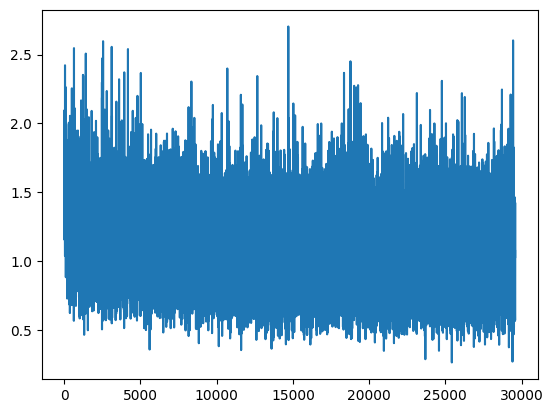

In [25]:
plt.plot(train_losses)

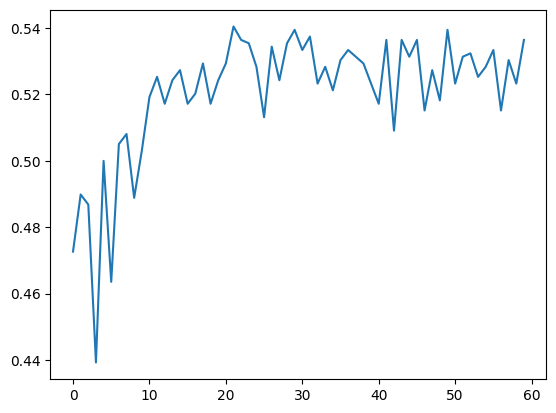

In [26]:
plt.plot(test_accuracy)

In [27]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 530/984 (0.5386)
{'acc_detail': tensor([0.6833, 0.7507, 0.4815, 0.0922], device='cuda:0'),
 'acc_unweighted': tensor(0.5019, device='cuda:0'),
 'acc_weighted': tensor(0.5386, device='cuda:0'),
 'f1s_detail': tensor([0.5945, 0.6045, 0.5794, 0.1496], device='cuda:0'),
 'f1s_unweighted': tensor(0.4820, device='cuda:0'),
 'f1s_weighted': tensor(0.5015, device='cuda:0'),
 'precision_detail': tensor([0.5261, 0.5059, 0.7273, 0.3958], device='cuda:0'),
 'recall_detail': tensor([0.6833, 0.7507, 0.4815, 0.0922], device='cuda:0'),
 'rocauc': tensor(0.7890, device='cuda:0'),
 'rocauc_detail': tensor([0.8260, 0.7414, 0.8633, 0.7253], device='cuda:0'),
 'uar': tensor(0.5019, device='cuda:0'),
 'wap': tensor(0.5360, device='cuda:0')}


tensor([[151,  60,   2,   8],
        [ 40, 256,  33,  12],
        [  5,  98, 104,   9],
        [ 91,  92,   4,  19]], device='cuda:0')

In [29]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap4_m13ser_best_22epoch.pt
Correct: 534/984 (0.5427)
{'acc_detail': tensor([0.6154, 0.7331, 0.5046, 0.1893], device='cuda:0'),
 'acc_unweighted': tensor(0.5106, device='cuda:0'),
 'acc_weighted': tensor(0.5427, device='cuda:0'),
 'f1s_detail': tensor([0.5862, 0.6031, 0.5813, 0.2600], device='cuda:0'),
 'f1s_unweighted': tensor(0.5077, device='cuda:0'),
 'f1s_weighted': tensor(0.5227, device='cuda:0'),
 'precision_detail': tensor([0.5597, 0.5123, 0.6855, 0.4149], device='cuda:0'),
 'recall_detail': tensor([0.6154, 0.7331, 0.5046, 0.1893], device='cuda:0'),
 'rocauc': tensor(0.7794, device='cuda:0'),
 'rocauc_detail': tensor([0.8168, 0.7297, 0.8480, 0.7230], device='cuda:0'),
 'uar': tensor(0.5106, device='cuda:0'),
 'wap': tensor(0.5406, device='cuda:0')}


tensor([[136,  55,   7,  23],
        [ 28, 250,  41,  22],
        [  5,  92, 109,  10],
        [ 74,  91,   2,  39]], device='cuda:0')

In [30]:
checkpoint_path = f'../models_iemocap4/iemocap4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


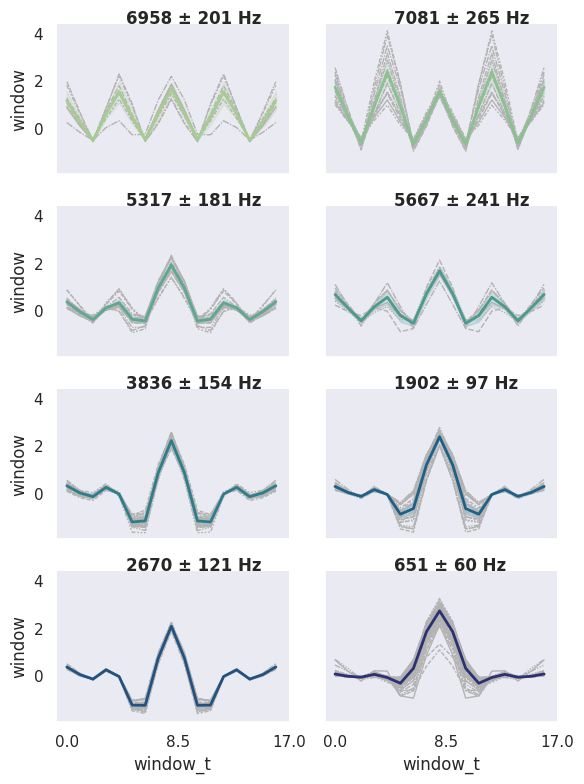

In [31]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


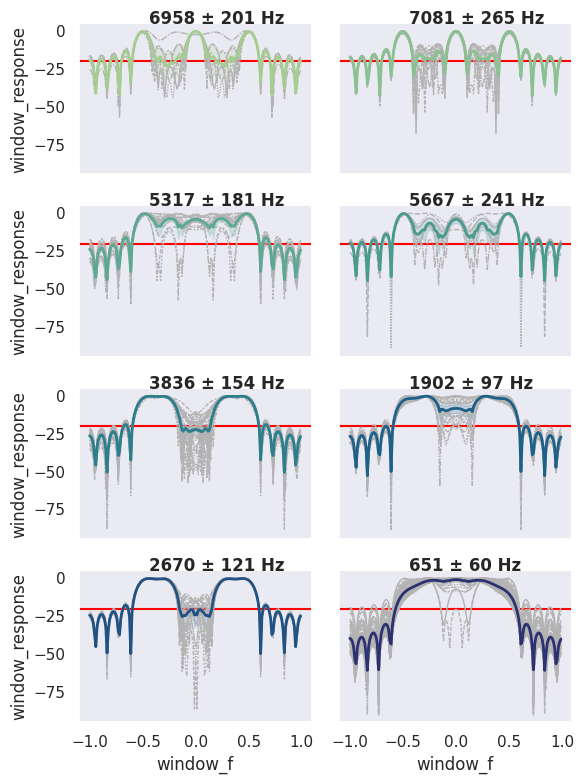

In [32]:
filtviz.visualize_filters(filter_domain='freq')

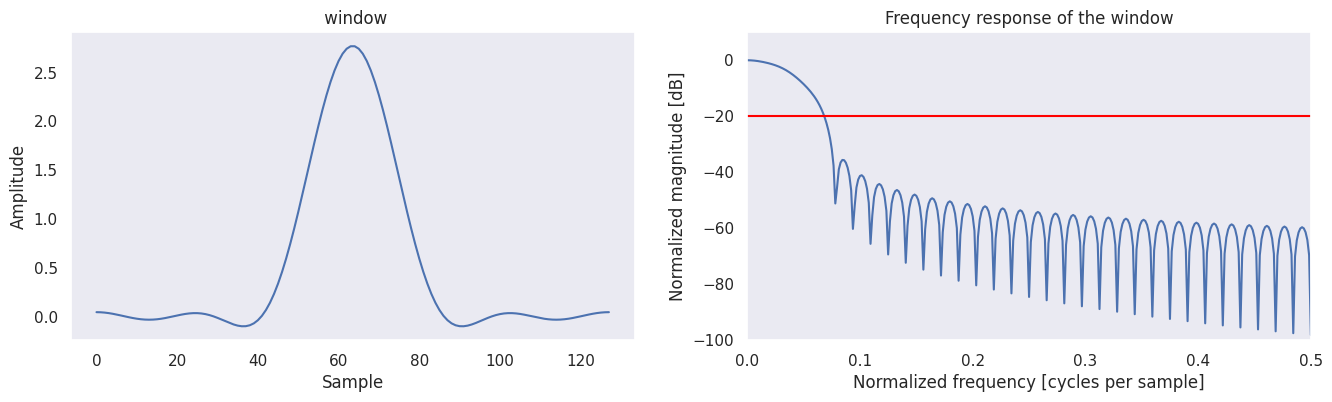

In [33]:
filtviz.visualize_one_window(n_out=10)

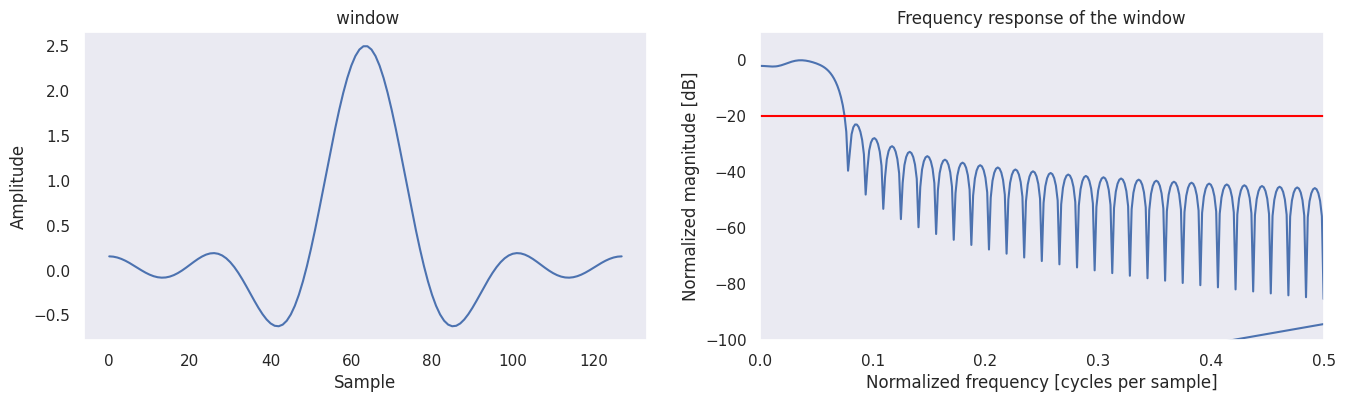

In [34]:
filtviz.visualize_one_window(n_out=30)

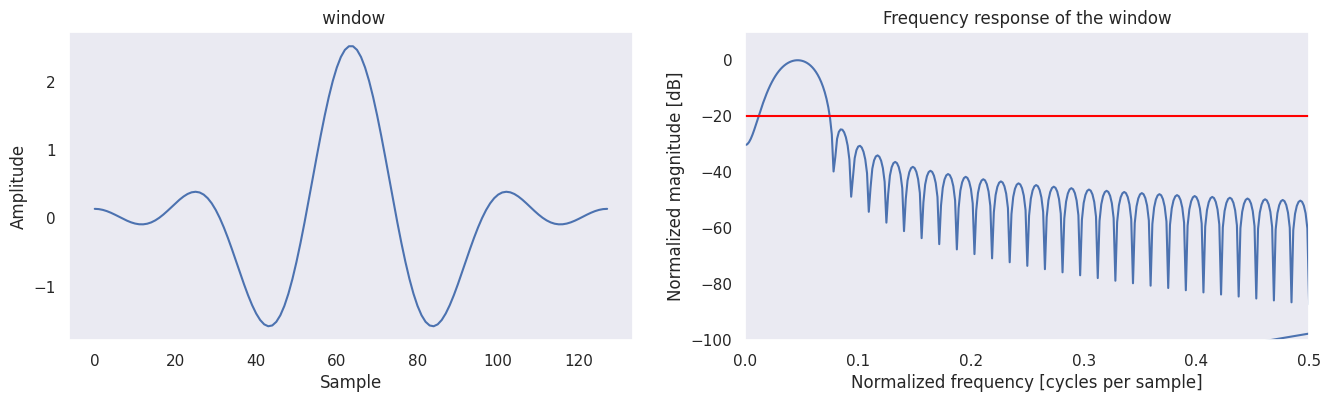

In [35]:
filtviz.visualize_one_window(n_out=50)

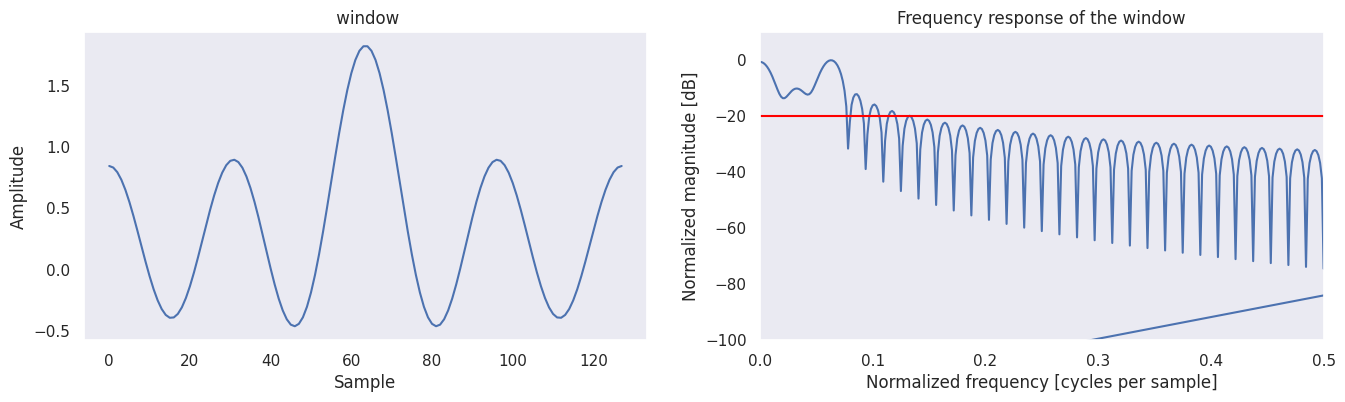

In [36]:
filtviz.visualize_one_window(n_out=60)

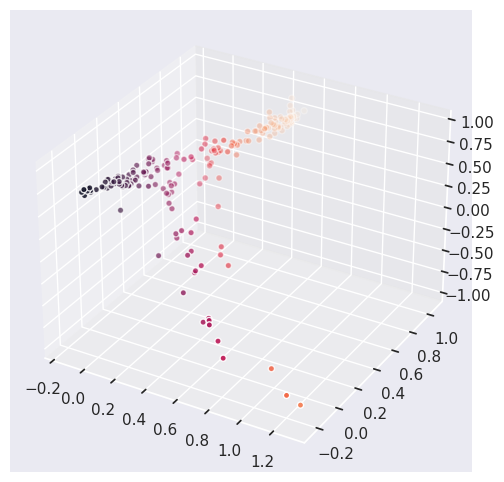

In [37]:
filtviz.visualize_window_params()

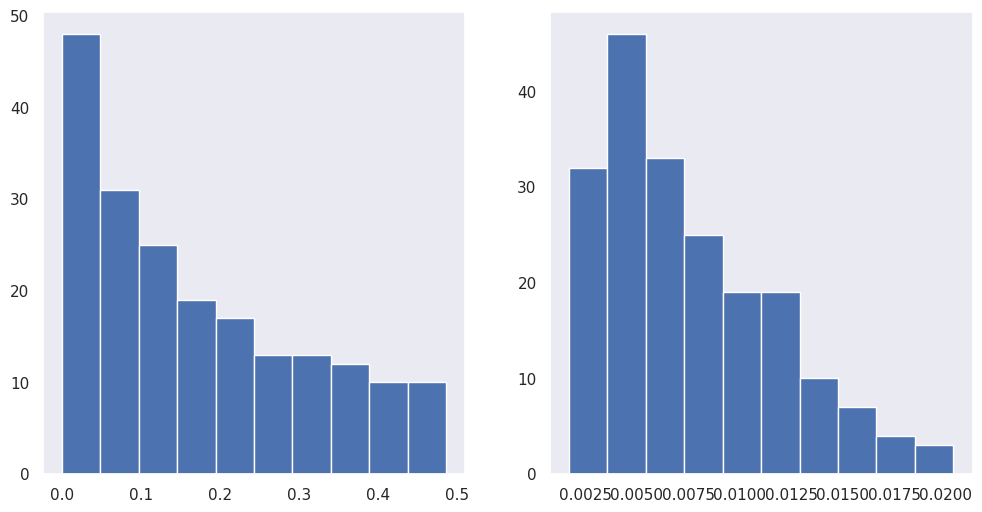

In [38]:
filtviz.visualize_bands()

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


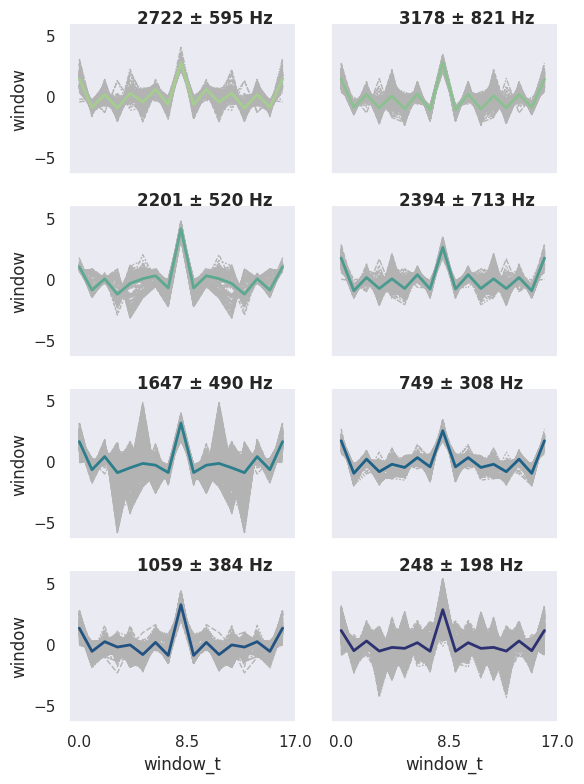

In [39]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


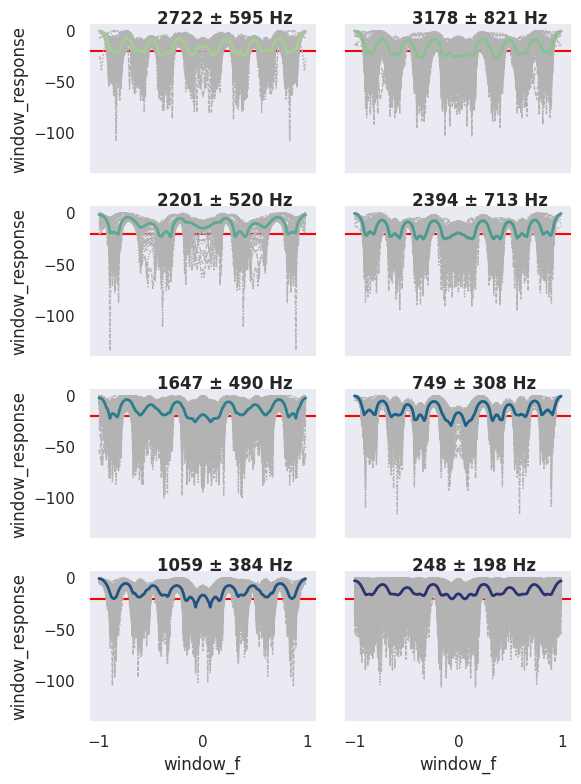

In [40]:
filtviz2.visualize_filters(filter_domain='freq')

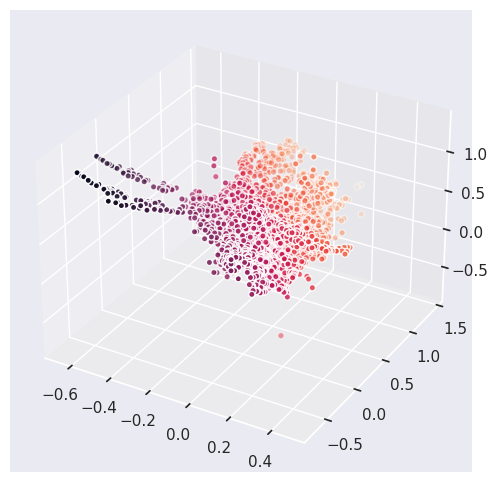

In [41]:
filtviz2.visualize_window_params()

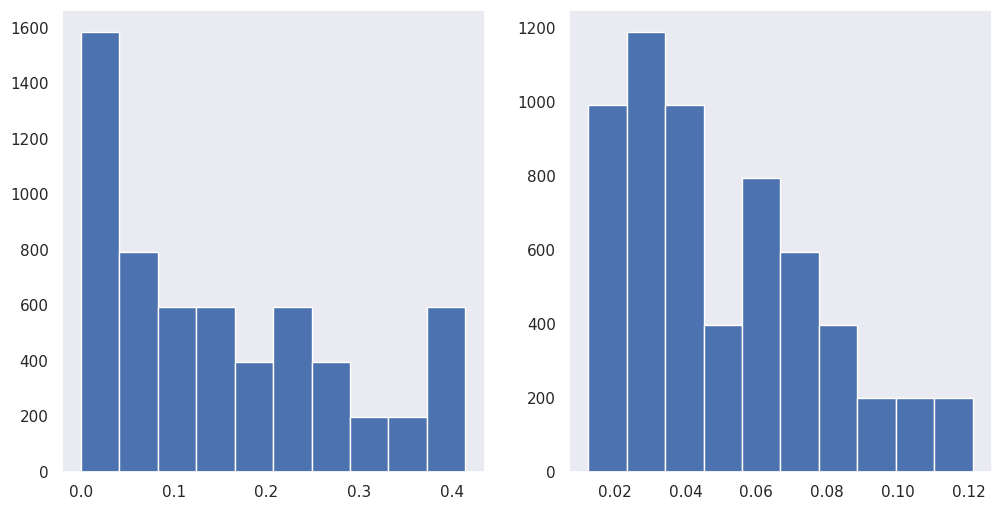

In [42]:
filtviz2.visualize_bands()

In [44]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 140

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(61, 201):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                            | 0.0016233766233766235/140 [00:00<19:32:52, 502.67s/it]

Train Epoch: 61 [0/3948 (0%)]	Loss: 1.583281
Mem before-during-after: 64561152 2764131840 69228032


  0%|                               | 0.06655844155844157/140 [00:13<8:21:23, 214.98s/it]

Train Epoch: 61 [320/3948 (8%)]	Loss: 0.889356
Mem before-during-after: 68282880 2767398400 68438528


  0%|                               | 0.13149350649350647/140 [00:26<8:14:09, 211.98s/it]

Train Epoch: 61 [640/3948 (16%)]	Loss: 0.500682
Mem before-during-after: 68611584 2766321664 68282880


  0%|                               | 0.19642857142857087/140 [00:39<8:12:34, 211.40s/it]

Train Epoch: 61 [960/3948 (24%)]	Loss: 0.960603
Mem before-during-after: 69133824 2767962112 68282880


  0%|                              | 0.26136363636363547/140 [00:52<10:12:12, 262.86s/it]

Train Epoch: 61 [1280/3948 (32%)]	Loss: 0.981559
Mem before-during-after: 68282880 2767040512 69133824


  0%|                                 | 0.326298701298701/140 [01:05<8:16:32, 213.30s/it]

Train Epoch: 61 [1600/3948 (41%)]	Loss: 1.041588
Mem before-during-after: 68282880 2767040512 69133824


  0%|                                | 0.3912337662337665/140 [01:19<8:14:54, 212.70s/it]

Train Epoch: 61 [1920/3948 (49%)]	Loss: 1.090727
Mem before-during-after: 68282880 2766992896 69133824


  0%|                                 | 0.456168831168832/140 [01:32<8:38:06, 222.77s/it]

Train Epoch: 61 [2240/3948 (57%)]	Loss: 0.917337
Mem before-during-after: 69133824 2767962112 68282880


  0%|                                | 0.5211038961038975/140 [01:44<8:05:10, 208.71s/it]

Train Epoch: 61 [2560/3948 (65%)]	Loss: 0.971193
Mem before-during-after: 68282880 2766992896 69133824


  0%|▏                                | 0.586038961038963/140 [01:57<8:09:10, 210.53s/it]

Train Epoch: 61 [2880/3948 (73%)]	Loss: 0.927693
Mem before-during-after: 69133824 2767316480 68558848


  0%|▏                               | 0.6509740259740285/140 [02:09<8:06:25, 209.45s/it]

Train Epoch: 61 [3200/3948 (81%)]	Loss: 1.218561
Mem before-during-after: 68282880 2767243264 68414976


  1%|▏                                | 0.715909090909094/140 [02:21<7:57:44, 205.80s/it]

Train Epoch: 61 [3520/3948 (89%)]	Loss: 1.027003
Mem before-during-after: 68611584 2766321664 68282880


  1%|▏                               | 0.7808441558441596/140 [02:34<7:59:36, 206.70s/it]

Train Epoch: 61 [3840/3948 (97%)]	Loss: 0.828095
Mem before-during-after: 68414976 2766321664 68282880


  1%|▏                               | 1.0000000000000056/140 [03:04<4:58:14, 128.74s/it]


Test Epoch: 61	Accuracy: 532/984 (54%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_61epoch.pt


  1%|▏                               | 1.0016233766233822/140 [03:04<6:01:04, 155.86s/it]

Train Epoch: 62 [0/3948 (0%)]	Loss: 1.817057
Mem before-during-after: 68181504 2767717888 68188672


  1%|▏                               | 1.0665584415584477/140 [03:17<8:04:58, 209.45s/it]

Train Epoch: 62 [320/3948 (8%)]	Loss: 1.153180
Mem before-during-after: 69133824 2767962112 68282880


  1%|▎                               | 1.1314935064935132/140 [03:29<8:04:00, 209.12s/it]

Train Epoch: 62 [640/3948 (16%)]	Loss: 1.219841
Mem before-during-after: 68414976 2766118912 68282880


  1%|▎                               | 1.1964285714285787/140 [03:42<7:59:51, 207.42s/it]

Train Epoch: 62 [960/3948 (24%)]	Loss: 1.206243
Mem before-during-after: 68414976 2766118912 68282880


  1%|▎                               | 1.2613636363636442/140 [03:54<8:10:36, 212.17s/it]

Train Epoch: 62 [1280/3948 (32%)]	Loss: 0.969409
Mem before-during-after: 68212224 2766071808 68235776


  1%|▎                               | 1.3262987012987097/140 [04:08<7:54:58, 205.51s/it]

Train Epoch: 62 [1600/3948 (41%)]	Loss: 0.999723
Mem before-during-after: 68282880 2766992896 69133824


  1%|▎                               | 1.3912337662337753/140 [04:20<8:03:59, 209.51s/it]

Train Epoch: 62 [1920/3948 (49%)]	Loss: 1.727321
Mem before-during-after: 69133824 2767962112 68282880


  1%|▎                               | 1.4561688311688408/140 [04:32<8:02:49, 209.10s/it]

Train Epoch: 62 [2240/3948 (57%)]	Loss: 0.861235
Mem before-during-after: 69060096 2766611968 68462080


  1%|▎                               | 1.5211038961039063/140 [04:45<8:10:13, 212.40s/it]

Train Epoch: 62 [2560/3948 (65%)]	Loss: 1.136160
Mem before-during-after: 68282880 2767040512 69157376


  1%|▎                               | 1.5860389610389718/140 [04:57<7:48:19, 203.01s/it]

Train Epoch: 62 [2880/3948 (73%)]	Loss: 1.049971
Mem before-during-after: 68438528 2748015616 68282880


  1%|▍                               | 1.6509740259740373/140 [05:10<8:08:54, 212.04s/it]

Train Epoch: 62 [3200/3948 (81%)]	Loss: 0.704619
Mem before-during-after: 68282880 2767283712 68438528


  1%|▍                               | 1.7159090909091028/140 [05:22<7:55:05, 206.14s/it]

Train Epoch: 62 [3520/3948 (89%)]	Loss: 0.703407
Mem before-during-after: 69157376 2750520320 68635136


  1%|▍                               | 1.7808441558441683/140 [05:34<7:51:40, 204.75s/it]

Train Epoch: 62 [3840/3948 (97%)]	Loss: 0.842578
Mem before-during-after: 68611584 2766321664 68282880


  1%|▍                                | 2.000000000000014/140 [06:04<5:09:05, 134.39s/it]


Test Epoch: 62	Accuracy: 520/984 (53%)



  1%|▍                               | 2.0016233766233906/140 [06:05<5:46:19, 150.57s/it]

Train Epoch: 63 [0/3948 (0%)]	Loss: 1.083628
Mem before-during-after: 68181504 2767717888 68188672


  1%|▍                               | 2.0665584415584473/140 [06:17<8:02:46, 210.00s/it]

Train Epoch: 63 [320/3948 (8%)]	Loss: 0.996900
Mem before-during-after: 68611584 2766321664 68282880


  2%|▌                                | 2.131493506493504/140 [06:29<7:53:48, 206.20s/it]

Train Epoch: 63 [640/3948 (16%)]	Loss: 1.629359
Mem before-during-after: 69133824 2766992896 68188672


  2%|▌                               | 2.1964285714285605/140 [06:41<7:50:13, 204.73s/it]

Train Epoch: 63 [960/3948 (24%)]	Loss: 0.792767
Mem before-during-after: 68414976 2766118912 68282880


  2%|▌                                | 2.261363636363617/140 [06:54<7:56:33, 207.59s/it]

Train Epoch: 63 [1280/3948 (32%)]	Loss: 0.995307
Mem before-during-after: 69133824 2767962112 68282880


  2%|▌                               | 2.3262987012986738/140 [07:06<7:53:51, 206.52s/it]

Train Epoch: 63 [1600/3948 (41%)]	Loss: 1.036024
Mem before-during-after: 68282880 2767040512 69133824


  2%|▌                               | 2.3912337662337304/140 [07:19<7:53:12, 206.33s/it]

Train Epoch: 63 [1920/3948 (49%)]	Loss: 0.498591
Mem before-during-after: 68611584 2749152256 68282880


  2%|▌                                | 2.456168831168787/140 [07:31<7:58:17, 208.64s/it]

Train Epoch: 63 [2240/3948 (57%)]	Loss: 0.865701
Mem before-during-after: 68282880 2767243264 68414976


  2%|▌                               | 2.5211038961038437/140 [07:43<7:48:30, 204.47s/it]

Train Epoch: 63 [2560/3948 (65%)]	Loss: 1.119410
Mem before-during-after: 69411328 2767153152 69114368


  2%|▌                               | 2.5860389610389003/140 [07:56<7:58:34, 208.97s/it]

Train Epoch: 63 [2880/3948 (73%)]	Loss: 1.462863
Mem before-during-after: 68282880 2767398400 68485632


  2%|▌                                | 2.650974025973957/140 [08:08<7:59:37, 209.52s/it]

Train Epoch: 63 [3200/3948 (81%)]	Loss: 1.279665
Mem before-during-after: 69204480 2767962112 68282880


  2%|▌                               | 2.7159090909090136/140 [08:21<7:53:22, 206.89s/it]

Train Epoch: 63 [3520/3948 (89%)]	Loss: 0.861580
Mem before-during-after: 68485632 2766118912 68235776


  2%|▋                                 | 2.78084415584407/140 [08:33<7:52:56, 206.80s/it]

Train Epoch: 63 [3840/3948 (97%)]	Loss: 0.928641
Mem before-during-after: 68485632 2766118912 68235776


  2%|▋                               | 2.9999999999998863/140 [09:03<4:52:29, 128.10s/it]


Test Epoch: 63	Accuracy: 521/984 (53%)



  2%|▋                               | 3.0016233766232627/140 [09:03<5:33:26, 146.03s/it]

Train Epoch: 64 [0/3948 (0%)]	Loss: 0.748363
Mem before-during-after: 68181504 2767717888 68188672


  2%|▋                               | 3.0665584415583194/140 [09:16<7:58:58, 209.87s/it]

Train Epoch: 64 [320/3948 (8%)]	Loss: 0.653649
Mem before-during-after: 68282880 2767040512 69133824


  2%|▋                                | 3.131493506493376/140 [09:28<8:00:22, 210.59s/it]

Train Epoch: 64 [640/3948 (16%)]	Loss: 0.710022
Mem before-during-after: 68282880 2748613632 68611584


  2%|▋                               | 3.1964285714284326/140 [09:41<7:56:01, 208.78s/it]

Train Epoch: 64 [960/3948 (24%)]	Loss: 0.693925
Mem before-during-after: 69133824 2767962112 68282880


  2%|▋                               | 3.2613636363634892/140 [09:53<7:57:52, 209.69s/it]

Train Epoch: 64 [1280/3948 (32%)]	Loss: 0.836908
Mem before-during-after: 68414976 2766321664 68282880


  2%|▊                                | 3.326298701298546/140 [10:06<7:50:10, 206.41s/it]

Train Epoch: 64 [1600/3948 (41%)]	Loss: 1.163866
Mem before-during-after: 68282880 2767040512 69133824


  2%|▊                               | 3.3912337662336025/140 [10:18<7:45:50, 204.61s/it]

Train Epoch: 64 [1920/3948 (49%)]	Loss: 0.832903
Mem before-during-after: 68611584 2766321664 68282880


  2%|▊                                | 3.456168831168659/140 [10:30<7:47:50, 205.58s/it]

Train Epoch: 64 [2240/3948 (57%)]	Loss: 1.081922
Mem before-during-after: 68282880 2748613632 68611584


  3%|▊                               | 3.5211038961037158/140 [10:43<7:56:47, 209.61s/it]

Train Epoch: 64 [2560/3948 (65%)]	Loss: 1.979429
Mem before-during-after: 68611584 2766321664 68282880


  3%|▊                               | 3.5860389610387724/140 [10:55<7:53:44, 208.37s/it]

Train Epoch: 64 [2880/3948 (73%)]	Loss: 1.801194
Mem before-during-after: 68611584 2766321664 68282880


  3%|▊                                | 3.650974025973829/140 [11:08<8:08:37, 215.02s/it]

Train Epoch: 64 [3200/3948 (81%)]	Loss: 0.683048
Mem before-during-after: 68282880 2766992896 69133824


  3%|▊                               | 3.7159090909088857/140 [11:20<7:55:11, 209.21s/it]

Train Epoch: 64 [3520/3948 (89%)]	Loss: 1.442934
Mem before-during-after: 69133824 2749464576 68611584


  3%|▊                               | 3.7808441558439423/140 [11:33<7:46:40, 205.56s/it]

Train Epoch: 64 [3840/3948 (97%)]	Loss: 1.325263
Mem before-during-after: 68282880 2748613632 68611584


  3%|▉                               | 3.9999999999997584/140 [12:03<4:53:29, 129.48s/it]


Test Epoch: 64	Accuracy: 521/984 (53%)



  3%|▉                                | 4.001623376623135/140 [12:03<5:50:43, 154.73s/it]

Train Epoch: 65 [0/3948 (0%)]	Loss: 1.399201
Mem before-during-after: 68181504 2767717888 68188672


  3%|▉                               | 4.0665584415581915/140 [12:15<7:49:22, 207.18s/it]

Train Epoch: 65 [320/3948 (8%)]	Loss: 0.905571
Mem before-during-after: 68282880 2748613632 68611584


  3%|▉                                | 4.131493506493248/140 [12:28<8:09:20, 216.10s/it]

Train Epoch: 65 [640/3948 (16%)]	Loss: 0.997647
Mem before-during-after: 69133824 2767962112 68282880


  3%|▉                                | 4.196428571428305/140 [12:40<7:48:34, 207.02s/it]

Train Epoch: 65 [960/3948 (24%)]	Loss: 1.722459
Mem before-during-after: 68282880 2767040512 69133824


  3%|█                                | 4.261363636363361/140 [12:53<7:56:27, 210.60s/it]

Train Epoch: 65 [1280/3948 (32%)]	Loss: 0.938711
Mem before-during-after: 68282880 2767040512 69133824


  3%|█                                | 4.326298701298418/140 [13:05<7:54:20, 209.77s/it]

Train Epoch: 65 [1600/3948 (41%)]	Loss: 0.961871
Mem before-during-after: 68414976 2766118912 68282880


  3%|█                                | 4.391233766233475/140 [13:17<7:50:29, 208.17s/it]

Train Epoch: 65 [1920/3948 (49%)]	Loss: 1.229360
Mem before-during-after: 68611584 2766321664 68282880


  3%|█                                | 4.456168831168531/140 [13:31<8:11:30, 217.57s/it]

Train Epoch: 65 [2240/3948 (57%)]	Loss: 0.795657
Mem before-during-after: 68414976 2767230464 68472832


  3%|█                                | 4.521103896103588/140 [13:43<8:02:31, 213.69s/it]

Train Epoch: 65 [2560/3948 (65%)]	Loss: 0.997305
Mem before-during-after: 68635136 2766321664 68282880


  3%|█                               | 4.5860389610386445/140 [13:56<7:42:38, 204.99s/it]

Train Epoch: 65 [2880/3948 (73%)]	Loss: 1.122288
Mem before-during-after: 68438528 2766524416 68282880


  3%|█                                | 4.650974025973701/140 [14:09<7:50:44, 208.68s/it]

Train Epoch: 65 [3200/3948 (81%)]	Loss: 0.808132
Mem before-during-after: 68282880 2767040512 69157376


  3%|█                                | 4.715909090908758/140 [14:21<7:45:15, 206.35s/it]

Train Epoch: 65 [3520/3948 (89%)]	Loss: 1.024630
Mem before-during-after: 69157376 2767962112 68282880


  3%|█▏                               | 4.780844155843814/140 [14:33<7:42:44, 205.33s/it]

Train Epoch: 65 [3840/3948 (97%)]	Loss: 0.872823
Mem before-during-after: 68282880 2767398400 68438528


  4%|█▏                              | 4.9999999999996305/140 [15:04<4:54:03, 130.70s/it]


Test Epoch: 65	Accuracy: 533/984 (54%)

saved model: ../models_iemocap4/iemocap4_m13ser_best_65epoch.pt


  4%|█▏                               | 5.001623376623007/140 [15:04<5:34:27, 148.65s/it]

Train Epoch: 66 [0/3948 (0%)]	Loss: 0.898806
Mem before-during-after: 68322816 2749922816 68682240


  4%|█▏                               | 5.066558441558064/140 [15:17<7:41:14, 205.10s/it]

Train Epoch: 66 [320/3948 (8%)]	Loss: 1.089398
Mem before-during-after: 69157376 2750520320 68635136


  4%|█▏                                | 5.13149350649312/140 [15:29<8:18:33, 221.80s/it]

Train Epoch: 66 [640/3948 (16%)]	Loss: 1.040812
Mem before-during-after: 68282880 2767040512 69157376


  4%|█▏                               | 5.196428571428177/140 [15:42<7:50:39, 209.49s/it]

Train Epoch: 66 [960/3948 (24%)]	Loss: 0.827628
Mem before-during-after: 68282880 2328952832 68635136


  4%|█▏                              | 5.2613636363632335/140 [15:55<7:45:38, 207.35s/it]

Train Epoch: 66 [1280/3948 (32%)]	Loss: 0.975384
Mem before-during-after: 68282880 2748613632 68635136


  4%|█▎                                | 5.32629870129829/140 [16:07<7:47:35, 208.32s/it]

Train Epoch: 66 [1600/3948 (41%)]	Loss: 1.532121
Mem before-during-after: 68438528 2766118912 68282880


  4%|█▎                               | 5.391233766233347/140 [16:20<7:41:58, 205.92s/it]

Train Epoch: 66 [1920/3948 (49%)]	Loss: 0.856255
Mem before-during-after: 68282880 2766993408 69157376


  4%|█▎                               | 5.456168831168403/140 [16:32<7:46:35, 208.07s/it]

Train Epoch: 66 [2240/3948 (57%)]	Loss: 0.842039
Mem before-during-after: 68635136 2766321664 68282880


  4%|█▎                                | 5.52110389610346/140 [16:45<7:53:00, 211.04s/it]

Train Epoch: 66 [2560/3948 (65%)]	Loss: 0.397614
Mem before-during-after: 68282880 2767243264 68438528


  4%|█▎                               | 5.586038961038517/140 [16:58<7:50:40, 210.10s/it]

Train Epoch: 66 [2880/3948 (73%)]	Loss: 1.309323
Mem before-during-after: 68635136 2766524416 68282880


  4%|█▎                               | 5.650974025973573/140 [17:10<7:46:58, 208.55s/it]

Train Epoch: 66 [3200/3948 (81%)]	Loss: 1.082673
Mem before-during-after: 68282880 2767040512 69157376


  4%|█▍                                | 5.71590909090863/140 [17:23<8:05:40, 217.00s/it]

Train Epoch: 66 [3520/3948 (89%)]	Loss: 1.058077
Mem before-during-after: 68282880 2767040512 69157376


  4%|█▎                              | 5.7808441558436865/140 [17:35<7:40:55, 206.05s/it]

Train Epoch: 66 [3840/3948 (97%)]	Loss: 0.951112
Mem before-during-after: 68282880 2748613632 68635136


  4%|█▍                               | 5.999999999999503/140 [18:06<5:03:05, 135.71s/it]


Test Epoch: 66	Accuracy: 511/984 (52%)



  4%|█▍                               | 6.001623376622879/140 [18:06<5:42:32, 153.38s/it]

Train Epoch: 67 [0/3948 (0%)]	Loss: 0.902689
Mem before-during-after: 68322816 2767764992 69204480


  4%|█▍                               | 6.066558441557936/140 [18:19<7:41:10, 206.60s/it]

Train Epoch: 67 [320/3948 (8%)]	Loss: 1.019048
Mem before-during-after: 69157376 2767962112 68282880


  4%|█▍                               | 6.131493506492992/140 [18:31<7:44:30, 208.19s/it]

Train Epoch: 67 [640/3948 (16%)]	Loss: 1.273441
Mem before-during-after: 68635136 2766321664 68282880


  4%|█▍                               | 6.196428571428049/140 [18:44<7:48:11, 209.95s/it]

Train Epoch: 67 [960/3948 (24%)]	Loss: 0.778921
Mem before-during-after: 68449280 2766118912 68188672


  4%|█▍                               | 6.261363636363106/140 [18:56<7:44:31, 208.40s/it]

Train Epoch: 67 [1280/3948 (32%)]	Loss: 1.204785
Mem before-during-after: 69133824 2767962112 68282880


  5%|█▍                               | 6.326298701298162/140 [19:09<7:36:57, 205.11s/it]

Train Epoch: 67 [1600/3948 (41%)]	Loss: 0.792965
Mem before-during-after: 68611584 2766321664 68282880


  5%|█▌                               | 6.391233766233219/140 [19:21<7:38:49, 206.04s/it]

Train Epoch: 67 [1920/3948 (49%)]	Loss: 0.847923
Mem before-during-after: 68282880 2748613632 68611584


  5%|█▍                              | 6.4561688311682754/140 [19:34<7:59:07, 215.26s/it]

Train Epoch: 67 [2240/3948 (57%)]	Loss: 1.244189
Mem before-during-after: 68282880 2767243264 68414976


  5%|█▌                               | 6.521103896103332/140 [19:47<8:01:01, 216.23s/it]

Train Epoch: 67 [2560/3948 (65%)]	Loss: 1.218253
Mem before-during-after: 69133824 2749464576 68611584


  5%|█▌                               | 6.586038961038389/140 [20:00<8:15:06, 222.67s/it]

Train Epoch: 67 [2880/3948 (73%)]	Loss: 1.027202
Mem before-during-after: 68282880 2767040512 69157376


  5%|█▌                               | 6.650974025973445/140 [20:12<7:57:35, 214.89s/it]

Train Epoch: 67 [3200/3948 (81%)]	Loss: 0.950689
Mem before-during-after: 68635136 2766321664 68282880


  5%|█▌                               | 6.715909090908502/140 [20:25<7:54:16, 213.50s/it]

Train Epoch: 67 [3520/3948 (89%)]	Loss: 0.661535
Mem before-during-after: 68282880 2767040512 69157376


  5%|█▌                               | 6.780844155843559/140 [20:38<7:58:59, 215.73s/it]

Train Epoch: 67 [3840/3948 (97%)]	Loss: 1.347184
Mem before-during-after: 68282880 2748613632 68635136


  5%|█▋                               | 6.999999999999375/140 [21:08<4:44:50, 128.50s/it]


Test Epoch: 67	Accuracy: 517/984 (52%)



  5%|█▋                               | 7.001623376622751/140 [21:09<5:29:08, 148.48s/it]

Train Epoch: 68 [0/3948 (0%)]	Loss: 1.060268
Mem before-during-after: 68322816 2767764992 69204480


  5%|█▋                               | 7.066558441557808/140 [21:21<7:43:26, 209.18s/it]

Train Epoch: 68 [320/3948 (8%)]	Loss: 0.772065
Mem before-during-after: 68438528 2766118912 68282880


  5%|█▋                               | 7.131493506492864/140 [21:34<7:43:09, 209.15s/it]

Train Epoch: 68 [640/3948 (16%)]	Loss: 0.631311
Mem before-during-after: 69157376 2767962112 68282880


  5%|█▋                               | 7.196428571427921/140 [21:46<7:44:37, 209.92s/it]

Train Epoch: 68 [960/3948 (24%)]	Loss: 0.817393
Mem before-during-after: 68282880 2767040512 69157376


  5%|█▋                               | 7.261363636362978/140 [21:59<7:47:14, 211.20s/it]

Train Epoch: 68 [1280/3948 (32%)]	Loss: 1.023961
Mem before-during-after: 68282880 2766993408 69157376


  5%|█▋                               | 7.326298701298034/140 [22:12<7:35:30, 205.99s/it]

Train Epoch: 68 [1600/3948 (41%)]	Loss: 0.690642
Mem before-during-after: 68438528 2766118912 68282880


  5%|█▋                               | 7.391233766233091/140 [22:24<7:32:38, 204.80s/it]

Train Epoch: 68 [1920/3948 (49%)]	Loss: 0.886133
Mem before-during-after: 68282880 2748613632 68635136


  5%|█▋                              | 7.4561688311681475/140 [22:37<7:40:55, 208.65s/it]

Train Epoch: 68 [2240/3948 (57%)]	Loss: 1.231948
Mem before-during-after: 68472832 2767219712 68414976


  5%|█▊                               | 7.521103896103204/140 [22:49<7:36:17, 206.65s/it]

Train Epoch: 68 [2560/3948 (65%)]	Loss: 1.045081
Mem before-during-after: 69157376 2767962112 68282880


  5%|█▊                               | 7.586038961038261/140 [23:02<8:09:02, 221.59s/it]

Train Epoch: 68 [2880/3948 (73%)]	Loss: 0.859273
Mem before-during-after: 69157376 2767962112 68282880


  5%|█▊                               | 7.650974025973317/140 [23:15<7:36:53, 207.13s/it]

Train Epoch: 68 [3200/3948 (81%)]	Loss: 1.141320
Mem before-during-after: 68438528 2766321664 68282880


  6%|█▊                               | 7.715909090908374/140 [23:28<7:35:13, 206.47s/it]

Train Epoch: 68 [3520/3948 (89%)]	Loss: 1.148854
Mem before-during-after: 68282880 2748613632 68635136


  6%|█▊                               | 7.780844155843431/140 [23:40<8:22:39, 228.10s/it]

Train Epoch: 68 [3840/3948 (97%)]	Loss: 0.959766
Mem before-during-after: 69204480 2767962112 68282880


  6%|█▉                               | 7.999999999999247/140 [24:11<4:51:51, 132.66s/it]


Test Epoch: 68	Accuracy: 521/984 (53%)



  6%|█▉                               | 8.001623376622623/140 [24:11<5:28:39, 149.39s/it]

Train Epoch: 69 [0/3948 (0%)]	Loss: 0.961329
Mem before-during-after: 68181504 2767741440 69180928


  6%|█▉                                | 8.06655844155768/140 [24:23<7:37:05, 207.87s/it]

Train Epoch: 69 [320/3948 (8%)]	Loss: 1.220711
Mem before-during-after: 69133824 2767962112 68282880


  6%|█▉                               | 8.131493506492737/140 [24:36<7:35:34, 207.28s/it]

Train Epoch: 69 [640/3948 (16%)]	Loss: 1.264399
Mem before-during-after: 68414976 2766118912 68282880


  6%|█▉                               | 8.196428571427793/140 [24:48<7:32:50, 206.15s/it]

Train Epoch: 69 [960/3948 (24%)]	Loss: 0.874602
Mem before-during-after: 68282880 2767040512 69133824


  6%|██                                | 8.26136363636285/140 [25:00<7:30:07, 205.01s/it]

Train Epoch: 69 [1280/3948 (32%)]	Loss: 1.400454
Mem before-during-after: 68282880 2767040512 69133824


  6%|█▉                               | 8.326298701297906/140 [25:13<7:26:10, 203.31s/it]

Train Epoch: 69 [1600/3948 (41%)]	Loss: 1.608065
Mem before-during-after: 69157376 2748613632 68635136


  6%|█▉                               | 8.391233766232963/140 [25:25<7:23:24, 202.15s/it]

Train Epoch: 69 [1920/3948 (49%)]	Loss: 0.598396
Mem before-during-after: 68188672 2747700736 68496384


  6%|██                                | 8.45616883116802/140 [25:37<7:43:51, 211.58s/it]

Train Epoch: 69 [2240/3948 (57%)]	Loss: 0.889738
Mem before-during-after: 68641280 2767689216 68641280


  6%|██                               | 8.521103896103076/140 [25:50<7:38:28, 209.22s/it]

Train Epoch: 69 [2560/3948 (65%)]	Loss: 0.771220
Mem before-during-after: 68641280 2767689216 68641280


  6%|██                               | 8.586038961038133/140 [26:02<7:36:38, 208.49s/it]

Train Epoch: 69 [2880/3948 (73%)]	Loss: 1.001623
Mem before-during-after: 69382656 2767689216 68641280


  6%|██                                | 8.65097402597319/140 [26:14<7:22:51, 202.30s/it]

Train Epoch: 69 [3200/3948 (81%)]	Loss: 0.803238
Mem before-during-after: 68641280 2767534080 68641280


  6%|██                               | 8.715909090908246/140 [26:26<7:38:14, 209.43s/it]

Train Epoch: 69 [3520/3948 (89%)]	Loss: 1.011857
Mem before-during-after: 68641280 2767534080 68641280


  6%|██                               | 8.780844155843303/140 [26:39<7:29:23, 205.48s/it]

Train Epoch: 69 [3840/3948 (97%)]	Loss: 0.986391
Mem before-during-after: 68989440 2767534080 68641280


  6%|██                               | 8.999999999999119/140 [27:09<4:44:30, 130.31s/it]


Test Epoch: 69	Accuracy: 526/984 (53%)



  6%|██                               | 9.001623376622495/140 [27:09<5:24:39, 148.70s/it]

Train Epoch: 70 [0/3948 (0%)]	Loss: 0.931309
Mem before-during-after: 68181504 2767717888 68188672


  6%|██▏                              | 9.066558441557552/140 [27:22<7:30:38, 206.50s/it]

Train Epoch: 70 [320/3948 (8%)]	Loss: 0.787725
Mem before-during-after: 69133824 2767962112 68282880


  7%|██▏                              | 9.131493506492609/140 [27:34<7:36:28, 209.28s/it]

Train Epoch: 70 [640/3948 (16%)]	Loss: 0.683247
Mem before-during-after: 69180928 2767016960 68259328


  7%|██▏                              | 9.196428571427665/140 [27:46<7:37:37, 209.91s/it]

Train Epoch: 70 [960/3948 (24%)]	Loss: 1.071758
Mem before-during-after: 69157376 2766992896 68212224


  7%|██▏                              | 9.261363636362722/140 [27:59<7:34:48, 208.72s/it]

Train Epoch: 70 [1280/3948 (32%)]	Loss: 1.156301
Mem before-during-after: 68611584 2766321664 68282880


  7%|██▏                              | 9.326298701297778/140 [28:11<7:56:17, 218.70s/it]

Train Epoch: 70 [1600/3948 (41%)]	Loss: 1.225098
Mem before-during-after: 69133824 2749464576 68611584


  7%|██▏                              | 9.391233766232835/140 [28:24<7:23:44, 203.85s/it]

Train Epoch: 70 [1920/3948 (49%)]	Loss: 1.819159
Mem before-during-after: 68414976 2748015616 68282880


  7%|██▏                              | 9.456168831167892/140 [28:36<7:34:33, 208.93s/it]

Train Epoch: 70 [2240/3948 (57%)]	Loss: 0.948543
Mem before-during-after: 69407232 2767446016 69407232


  7%|██▏                              | 9.521103896102948/140 [28:48<7:32:39, 208.15s/it]

Train Epoch: 70 [2560/3948 (65%)]	Loss: 1.025532
Mem before-during-after: 68282880 2767398400 68438528


  7%|██▎                              | 9.586038961038005/140 [29:01<7:29:51, 206.97s/it]

Train Epoch: 70 [2880/3948 (73%)]	Loss: 0.559709
Mem before-during-after: 68282880 2767398400 68438528


  7%|██▎                              | 9.650974025973062/140 [29:13<7:33:02, 208.53s/it]

Train Epoch: 70 [3200/3948 (81%)]	Loss: 1.067703
Mem before-during-after: 68282880 2766564864 68438528


  7%|██▎                              | 9.715909090908118/140 [29:26<7:25:57, 205.38s/it]

Train Epoch: 70 [3520/3948 (89%)]	Loss: 0.595510
Mem before-during-after: 68282880 2748613632 68635136


  7%|██▎                              | 9.780844155843175/140 [29:38<7:18:29, 202.04s/it]

Train Epoch: 70 [3840/3948 (97%)]	Loss: 1.091408
Mem before-during-after: 68641280 2767689216 68688384


  7%|██▎                              | 9.999999999998991/140 [30:08<4:41:02, 129.71s/it]


Test Epoch: 70	Accuracy: 509/984 (52%)



  7%|██▎                             | 10.001623376622367/140 [30:08<5:21:39, 148.46s/it]

Train Epoch: 71 [0/3948 (0%)]	Loss: 1.359374
Mem before-during-after: 68181504 2767717888 68188672


  7%|██▎                             | 10.066558441557424/140 [30:21<7:27:18, 206.55s/it]

Train Epoch: 71 [320/3948 (8%)]	Loss: 0.996609
Mem before-during-after: 69133824 2767962112 68282880


  7%|██▍                              | 10.13149350649248/140 [30:33<7:34:15, 209.87s/it]

Train Epoch: 71 [640/3948 (16%)]	Loss: 1.360773
Mem before-during-after: 69157376 2767962112 68282880


  7%|██▎                             | 10.196428571427537/140 [30:46<7:42:55, 213.98s/it]

Train Epoch: 71 [960/3948 (24%)]	Loss: 0.863662
Mem before-during-after: 68282880 2748613632 68611584


  7%|██▎                             | 10.261363636362594/140 [30:58<7:38:31, 212.05s/it]

Train Epoch: 71 [1280/3948 (32%)]	Loss: 1.081369
Mem before-during-after: 69133824 2767962112 68282880


  7%|██▍                              | 10.32629870129765/140 [31:10<7:28:44, 207.64s/it]

Train Epoch: 71 [1600/3948 (41%)]	Loss: 0.768655
Mem before-during-after: 68282880 2767040512 69133824


  7%|██▍                             | 10.391233766232707/140 [31:23<7:30:12, 208.42s/it]

Train Epoch: 71 [1920/3948 (49%)]	Loss: 1.394070
Mem before-during-after: 69180928 2767040512 68212224


  7%|██▍                             | 10.456168831167764/140 [31:35<7:28:34, 207.77s/it]

Train Epoch: 71 [2240/3948 (57%)]	Loss: 0.873714
Mem before-during-after: 69133824 2767962112 68282880


  8%|██▍                              | 10.52110389610282/140 [31:48<7:27:55, 207.57s/it]

Train Epoch: 71 [2560/3948 (65%)]	Loss: 0.750956
Mem before-during-after: 68282880 2748613632 68611584


  8%|██▍                             | 10.586038961037877/140 [32:00<7:24:50, 206.24s/it]

Train Epoch: 71 [2880/3948 (73%)]	Loss: 1.144774
Mem before-during-after: 68282880 2767243264 68485632


  8%|██▍                             | 10.650974025972934/140 [32:12<7:24:22, 206.13s/it]

Train Epoch: 71 [3200/3948 (81%)]	Loss: 1.125322
Mem before-during-after: 68472832 2767219712 68414976


  8%|██▌                              | 10.71590909090799/140 [32:25<7:26:00, 206.99s/it]

Train Epoch: 71 [3520/3948 (89%)]	Loss: 1.371729
Mem before-during-after: 69133824 2767962112 68282880


  8%|██▍                             | 10.780844155843047/140 [32:37<7:27:41, 207.88s/it]

Train Epoch: 71 [3840/3948 (97%)]	Loss: 1.447224
Mem before-during-after: 68462080 2766368768 68329984


  8%|██▌                             | 10.999999999998863/140 [33:07<4:40:11, 130.33s/it]


Test Epoch: 71	Accuracy: 530/984 (54%)



  8%|██▌                              | 11.00162337662224/140 [33:08<5:18:28, 148.13s/it]

Train Epoch: 72 [0/3948 (0%)]	Loss: 0.959131
Mem before-during-after: 68181504 2767717888 68188672


  8%|██▌                             | 11.066558441557296/140 [33:20<7:27:09, 208.09s/it]

Train Epoch: 72 [320/3948 (8%)]	Loss: 1.008031
Mem before-during-after: 68188672 2766024704 68188672


  8%|██▌                             | 11.131493506492353/140 [33:32<7:21:31, 205.57s/it]

Train Epoch: 72 [640/3948 (16%)]	Loss: 0.899521
Mem before-during-after: 68282880 2767243264 68414976


  8%|██▋                              | 11.19642857142741/140 [33:45<7:22:42, 206.23s/it]

Train Epoch: 72 [960/3948 (24%)]	Loss: 0.865170
Mem before-during-after: 68282880 2767040512 69133824


  8%|██▌                             | 11.261363636362466/140 [33:57<7:24:32, 207.18s/it]

Train Epoch: 72 [1280/3948 (32%)]	Loss: 1.559077
Mem before-during-after: 68282880 2767040512 69133824


  8%|██▌                             | 11.326298701297523/140 [34:09<7:20:37, 205.46s/it]

Train Epoch: 72 [1600/3948 (41%)]	Loss: 0.981677
Mem before-during-after: 69133824 2767962112 68282880


  8%|██▋                              | 11.39123376623258/140 [34:22<7:28:35, 209.29s/it]

Train Epoch: 72 [1920/3948 (49%)]	Loss: 1.135811
Mem before-during-after: 68282880 2767040512 69133824


  8%|██▌                             | 11.456168831167636/140 [34:34<7:23:06, 206.83s/it]

Train Epoch: 72 [2240/3948 (57%)]	Loss: 0.970638
Mem before-during-after: 68611584 2766321664 68282880


  8%|██▋                             | 11.521103896102693/140 [34:47<7:41:04, 215.33s/it]

Train Epoch: 72 [2560/3948 (65%)]	Loss: 1.118476
Mem before-during-after: 68282880 2767243264 68414976


  8%|██▋                              | 11.58603896103775/140 [34:59<7:28:28, 209.55s/it]

Train Epoch: 72 [2880/3948 (73%)]	Loss: 0.733215
Mem before-during-after: 69133824 2767962112 68282880


  8%|██▋                             | 11.650974025972806/140 [35:12<7:22:14, 206.73s/it]

Train Epoch: 72 [3200/3948 (81%)]	Loss: 1.352430
Mem before-during-after: 68611584 2766321664 68282880


  8%|██▋                             | 11.715909090907862/140 [35:24<7:24:22, 207.84s/it]

Train Epoch: 72 [3520/3948 (89%)]	Loss: 1.455698
Mem before-during-after: 69133824 2767962112 68282880


  8%|██▋                             | 11.780844155842919/140 [35:36<7:26:21, 208.87s/it]

Train Epoch: 72 [3840/3948 (97%)]	Loss: 1.717221
Mem before-during-after: 68282880 2767040512 69133824


  9%|██▋                             | 11.999999999998735/140 [36:06<4:38:37, 130.60s/it]


Test Epoch: 72	Accuracy: 518/984 (52%)



  9%|██▋                             | 12.001623376622112/140 [36:07<5:22:45, 151.29s/it]

Train Epoch: 73 [0/3948 (0%)]	Loss: 1.637341
Mem before-during-after: 68181504 2767741440 69180928


  9%|██▊                             | 12.066558441557168/140 [36:19<7:26:09, 209.25s/it]

Train Epoch: 73 [320/3948 (8%)]	Loss: 0.777361
Mem before-during-after: 68282880 2766992896 69133824


  9%|██▊                             | 12.131493506492225/140 [36:31<7:15:39, 204.42s/it]

Train Epoch: 73 [640/3948 (16%)]	Loss: 1.037107
Mem before-during-after: 68472832 2748637696 68658688


  9%|██▊                             | 12.196428571427282/140 [36:44<7:37:20, 214.71s/it]

Train Epoch: 73 [960/3948 (24%)]	Loss: 1.003173
Mem before-during-after: 69133824 2767962112 68282880


  9%|██▊                             | 12.261363636362338/140 [36:57<7:26:08, 209.55s/it]

Train Epoch: 73 [1280/3948 (32%)]	Loss: 0.844156
Mem before-during-after: 68282880 2766993408 69157376


  9%|██▊                             | 12.326298701297395/140 [37:09<7:35:55, 214.26s/it]

Train Epoch: 73 [1600/3948 (41%)]	Loss: 0.779719
Mem before-during-after: 68635136 2766321664 68282880


  9%|██▊                             | 12.391233766232451/140 [37:22<7:59:41, 225.54s/it]

Train Epoch: 73 [1920/3948 (49%)]	Loss: 1.372629
Mem before-during-after: 68282880 2748613632 68635136


  9%|██▊                             | 12.456168831167508/140 [37:35<7:40:46, 216.76s/it]

Train Epoch: 73 [2240/3948 (57%)]	Loss: 1.211817
Mem before-during-after: 69566976 2767740928 69024256


  9%|██▊                             | 12.521103896102565/140 [37:48<7:35:35, 214.43s/it]

Train Epoch: 73 [2560/3948 (65%)]	Loss: 0.631120
Mem before-during-after: 68282880 2767243264 68438528


  9%|██▉                             | 12.586038961037621/140 [38:01<7:21:08, 207.74s/it]

Train Epoch: 73 [2880/3948 (73%)]	Loss: 1.036911
Mem before-during-after: 68438528 2766321664 68282880


  9%|██▉                             | 12.650974025972678/140 [38:14<7:39:04, 216.29s/it]

Train Epoch: 73 [3200/3948 (81%)]	Loss: 0.941376
Mem before-during-after: 69157376 2767962112 68282880


  9%|██▉                             | 12.715909090907735/140 [38:26<7:16:00, 205.53s/it]

Train Epoch: 73 [3520/3948 (89%)]	Loss: 0.717581
Mem before-during-after: 69157376 2767962112 68282880


  9%|██▉                             | 12.780844155842791/140 [38:39<7:16:19, 205.78s/it]

Train Epoch: 73 [3840/3948 (97%)]	Loss: 0.716981
Mem before-during-after: 69180928 2767016960 68259328


  9%|██▉                             | 12.999999999998607/140 [39:09<4:37:06, 130.92s/it]


Test Epoch: 73	Accuracy: 519/984 (53%)



  9%|██▉                             | 13.001623376621984/140 [39:09<5:24:27, 153.29s/it]

Train Epoch: 74 [0/3948 (0%)]	Loss: 1.023596
Mem before-during-after: 68181504 2767741440 69180928


  9%|███                              | 13.06655844155704/140 [39:21<7:11:17, 203.86s/it]

Train Epoch: 74 [320/3948 (8%)]	Loss: 0.694490
Mem before-during-after: 68282880 2767040512 69157376


  9%|███                             | 13.131493506492097/140 [39:34<7:09:20, 203.05s/it]

Train Epoch: 74 [640/3948 (16%)]	Loss: 1.054389
Mem before-during-after: 68282880 2767040512 69204480


  9%|███                             | 13.196428571427154/140 [39:46<7:15:17, 205.97s/it]

Train Epoch: 74 [960/3948 (24%)]	Loss: 1.140872
Mem before-during-after: 69204480 2767962112 68282880


  9%|███▏                             | 13.26136363636221/140 [39:58<7:10:39, 203.88s/it]

Train Epoch: 74 [1280/3948 (32%)]	Loss: 1.016333
Mem before-during-after: 68682240 2766321664 68282880


 10%|███                             | 13.326298701297267/140 [40:11<7:13:26, 205.30s/it]

Train Epoch: 74 [1600/3948 (41%)]	Loss: 0.643331
Mem before-during-after: 69204480 2767962112 68282880


 10%|███                             | 13.391233766232324/140 [40:23<7:11:21, 204.42s/it]

Train Epoch: 74 [1920/3948 (49%)]	Loss: 0.922379
Mem before-during-after: 68282880 2767243264 68485632


 10%|███▏                             | 13.45616883116738/140 [40:35<7:09:14, 203.52s/it]

Train Epoch: 74 [2240/3948 (57%)]	Loss: 0.988190
Mem before-during-after: 68485632 2766321664 68282880


 10%|███                             | 13.521103896102437/140 [40:47<7:14:51, 206.29s/it]

Train Epoch: 74 [2560/3948 (65%)]	Loss: 1.304329
Mem before-during-after: 69204480 2767962112 68282880


 10%|███                             | 13.586038961037493/140 [41:00<7:14:04, 206.02s/it]

Train Epoch: 74 [2880/3948 (73%)]	Loss: 0.543657
Mem before-during-after: 68282880 2767040512 69204480


 10%|███▏                             | 13.65097402597255/140 [41:12<7:11:19, 204.83s/it]

Train Epoch: 74 [3200/3948 (81%)]	Loss: 0.780039
Mem before-during-after: 68282880 2767243264 68485632


 10%|███▏                            | 13.715909090907607/140 [41:24<7:11:11, 204.87s/it]

Train Epoch: 74 [3520/3948 (89%)]	Loss: 1.140380
Mem before-during-after: 68282880 2748613632 68682240


 10%|███▏                            | 13.780844155842663/140 [41:36<7:06:58, 202.97s/it]

Train Epoch: 74 [3840/3948 (97%)]	Loss: 1.309018
Mem before-during-after: 68235776 2767040512 69204480


 10%|███▎                             | 13.99999999999848/140 [42:06<4:32:52, 129.94s/it]


Test Epoch: 74	Accuracy: 529/984 (54%)



 10%|███▏                            | 14.001623376621856/140 [42:06<5:17:30, 151.20s/it]

Train Epoch: 75 [0/3948 (0%)]	Loss: 0.809967
Mem before-during-after: 68181504 2767764992 69251584


 10%|███▏                            | 14.066558441556912/140 [42:18<7:17:32, 208.46s/it]

Train Epoch: 75 [320/3948 (8%)]	Loss: 0.864095
Mem before-during-after: 69157376 2767962112 68282880


 10%|███▎                             | 14.13149350649197/140 [42:31<7:11:52, 205.87s/it]

Train Epoch: 75 [640/3948 (16%)]	Loss: 0.563101
Mem before-during-after: 68485632 2767148032 68235776


 10%|███▏                            | 14.196428571427026/140 [42:43<7:11:17, 205.70s/it]

Train Epoch: 75 [960/3948 (24%)]	Loss: 1.450617
Mem before-during-after: 69204480 2767962112 68282880


 10%|███▎                            | 14.261363636362082/140 [42:55<7:16:34, 208.32s/it]

Train Epoch: 75 [1280/3948 (32%)]	Loss: 1.135320
Mem before-during-after: 68282880 2767040512 69204480


 10%|███▎                            | 14.326298701297139/140 [43:08<7:14:21, 207.38s/it]

Train Epoch: 75 [1600/3948 (41%)]	Loss: 1.055588
Mem before-during-after: 68282880 2747838976 68259328


 10%|███▎                            | 14.391233766232196/140 [43:20<7:12:51, 206.76s/it]

Train Epoch: 75 [1920/3948 (49%)]	Loss: 0.862560
Mem before-during-after: 69157376 2766992896 68212224


 10%|███▎                            | 14.456168831167252/140 [43:32<7:17:21, 209.02s/it]

Train Epoch: 75 [2240/3948 (57%)]	Loss: 0.623124
Mem before-during-after: 69133824 2749464576 68611584


 10%|███▎                            | 14.521103896102309/140 [43:45<7:08:44, 205.01s/it]

Train Epoch: 75 [2560/3948 (65%)]	Loss: 1.576949
Mem before-during-after: 68282880 2767398400 68414976


 10%|███▎                            | 14.586038961037366/140 [43:57<7:13:50, 207.55s/it]

Train Epoch: 75 [2880/3948 (73%)]	Loss: 0.821811
Mem before-during-after: 69133824 2767962112 68282880


 10%|███▎                            | 14.650974025972422/140 [44:09<7:00:05, 201.08s/it]

Train Epoch: 75 [3200/3948 (81%)]	Loss: 1.409127
Mem before-during-after: 68282880 2747838976 68188672


 11%|███▎                            | 14.715909090907479/140 [44:22<7:22:31, 211.93s/it]

Train Epoch: 75 [3520/3948 (89%)]	Loss: 1.250487
Mem before-during-after: 68414976 2766118912 68282880


 11%|███▍                            | 14.780844155842535/140 [44:34<7:12:12, 207.10s/it]

Train Epoch: 75 [3840/3948 (97%)]	Loss: 0.859327
Mem before-during-after: 68282880 2767040512 69133824


 11%|███▍                            | 14.999999999998352/140 [45:06<4:43:56, 136.29s/it]


Test Epoch: 75	Accuracy: 523/984 (53%)



 11%|███▍                            | 15.001623376621728/140 [45:06<5:24:05, 155.57s/it]

Train Epoch: 76 [0/3948 (0%)]	Loss: 1.047901
Mem before-during-after: 68181504 2767741440 69180928


 11%|███▍                            | 15.066558441556785/140 [45:19<7:22:45, 212.64s/it]

Train Epoch: 76 [320/3948 (8%)]	Loss: 1.552714
Mem before-during-after: 69133824 2767962112 69204480


 11%|███▍                            | 15.131493506491841/140 [45:32<7:40:32, 221.29s/it]

Train Epoch: 76 [640/3948 (16%)]	Loss: 0.806024
Mem before-during-after: 69157376 2767962112 68282880


 11%|███▍                            | 15.196428571426898/140 [45:44<7:11:45, 207.57s/it]

Train Epoch: 76 [960/3948 (24%)]	Loss: 0.722628
Mem before-during-after: 69157376 2767266816 68414976


 11%|███▍                            | 15.261363636361954/140 [45:57<7:03:55, 203.91s/it]

Train Epoch: 76 [1280/3948 (32%)]	Loss: 1.019031
Mem before-during-after: 68282880 2767398400 68414976


 11%|███▌                            | 15.326298701297011/140 [46:09<7:02:44, 203.45s/it]

Train Epoch: 76 [1600/3948 (41%)]	Loss: 1.350832
Mem before-during-after: 68414976 2748015616 68282880


 11%|███▌                            | 15.391233766232068/140 [46:21<7:06:09, 205.19s/it]

Train Epoch: 76 [1920/3948 (49%)]	Loss: 1.005072
Mem before-during-after: 69180928 2768009216 68329984


 11%|███▌                            | 15.456168831167124/140 [46:33<7:06:58, 205.70s/it]

Train Epoch: 76 [2240/3948 (57%)]	Loss: 1.233502
Mem before-during-after: 68472832 2766321664 68438528


 11%|███▌                            | 15.521103896102181/140 [46:46<7:09:18, 206.93s/it]

Train Epoch: 76 [2560/3948 (65%)]	Loss: 1.444347
Mem before-during-after: 68282880 2766564864 68438528


 11%|███▌                            | 15.586038961037238/140 [46:58<7:03:20, 204.16s/it]

Train Epoch: 76 [2880/3948 (73%)]	Loss: 1.616044
Mem before-during-after: 68438528 2766118912 68282880


 11%|███▌                            | 15.650974025972294/140 [47:10<7:05:12, 205.17s/it]

Train Epoch: 76 [3200/3948 (81%)]	Loss: 1.138766
Mem before-during-after: 68438528 2768170496 68438528


 11%|███▋                             | 15.71590909090735/140 [47:22<7:03:58, 204.68s/it]

Train Epoch: 76 [3520/3948 (89%)]	Loss: 1.241827
Mem before-during-after: 68282880 2767398400 68438528


 11%|███▌                            | 15.780844155842408/140 [47:35<7:09:03, 207.24s/it]

Train Epoch: 76 [3840/3948 (97%)]	Loss: 1.053275
Mem before-during-after: 68282880 2767398400 68438528


 11%|███▋                            | 15.999999999998224/140 [48:05<4:34:03, 132.61s/it]


Test Epoch: 76	Accuracy: 527/984 (53%)



 11%|███▋                            | 16.001623376621602/140 [48:05<5:13:19, 151.61s/it]

Train Epoch: 77 [0/3948 (0%)]	Loss: 1.093523
Mem before-during-after: 68181504 2767741440 69180928


 11%|███▊                             | 16.06655844155673/140 [48:17<7:05:25, 205.96s/it]

Train Epoch: 77 [320/3948 (8%)]	Loss: 0.976818
Mem before-during-after: 68438528 2748015616 68282880


 12%|███▋                            | 16.131493506491857/140 [48:30<7:02:18, 204.56s/it]

Train Epoch: 77 [640/3948 (16%)]	Loss: 0.808635
Mem before-during-after: 69157376 2767962112 68282880


 12%|███▋                            | 16.196428571426985/140 [48:42<7:03:06, 205.05s/it]

Train Epoch: 77 [960/3948 (24%)]	Loss: 0.798505
Mem before-during-after: 69157376 2767962112 68282880


 12%|███▋                            | 16.261363636362113/140 [48:54<7:05:34, 206.36s/it]

Train Epoch: 77 [1280/3948 (32%)]	Loss: 0.799183
Mem before-during-after: 69157376 2767962112 68282880


 12%|███▊                             | 16.32629870129724/140 [49:06<7:02:36, 205.03s/it]

Train Epoch: 77 [1600/3948 (41%)]	Loss: 1.132816
Mem before-during-after: 68438528 2766118912 68282880


 12%|███▋                            | 16.391233766232368/140 [49:19<7:05:17, 206.43s/it]

Train Epoch: 77 [1920/3948 (49%)]	Loss: 0.672517
Mem before-during-after: 68635136 2766321664 68282880


 12%|███▊                            | 16.456168831167496/140 [49:31<7:10:44, 209.20s/it]

Train Epoch: 77 [2240/3948 (57%)]	Loss: 0.510831
Mem before-during-after: 68438528 2766118912 68282880


 12%|███▊                            | 16.521103896102623/140 [49:43<7:12:50, 210.32s/it]

Train Epoch: 77 [2560/3948 (65%)]	Loss: 1.112095
Mem before-during-after: 68438528 2766118912 68282880


 12%|███▉                             | 16.58603896103775/140 [49:56<7:02:40, 205.49s/it]

Train Epoch: 77 [2880/3948 (73%)]	Loss: 1.042354
Mem before-during-after: 68635136 2766524416 68282880


 12%|███▉                             | 16.65097402597288/140 [50:08<6:59:24, 204.01s/it]

Train Epoch: 77 [3200/3948 (81%)]	Loss: 1.540893
Mem before-during-after: 68282880 2748613632 68635136


 12%|███▊                            | 16.715909090908006/140 [50:20<7:06:39, 207.65s/it]

Train Epoch: 77 [3520/3948 (89%)]	Loss: 1.016850
Mem before-during-after: 68282880 2767243264 68438528


 12%|███▊                            | 16.780844155843134/140 [50:33<7:25:03, 216.72s/it]

Train Epoch: 77 [3840/3948 (97%)]	Loss: 1.219285
Mem before-during-after: 68282880 2767040512 69157376


 12%|████                             | 16.99999999999919/140 [51:03<4:36:34, 134.91s/it]


Test Epoch: 77	Accuracy: 530/984 (54%)



 12%|███▉                            | 17.001623376622568/140 [51:03<5:15:45, 154.03s/it]

Train Epoch: 78 [0/3948 (0%)]	Loss: 0.954261
Mem before-during-after: 68181504 2767764992 69251584


 12%|███▉                            | 17.066558441557696/140 [51:16<6:58:06, 204.06s/it]

Train Epoch: 78 [320/3948 (8%)]	Loss: 1.134571
Mem before-during-after: 68282880 2748613632 68635136


 12%|███▉                            | 17.131493506492824/140 [51:28<7:08:56, 209.46s/it]

Train Epoch: 78 [640/3948 (16%)]	Loss: 0.966523
Mem before-during-after: 68282880 2767398400 68438528


 12%|████                             | 17.19642857142795/140 [51:40<7:03:49, 207.08s/it]

Train Epoch: 78 [960/3948 (24%)]	Loss: 0.842075
Mem before-during-after: 68438528 2766993408 69157376


 12%|████                             | 17.26136363636308/140 [51:53<6:58:44, 204.70s/it]

Train Epoch: 78 [1280/3948 (32%)]	Loss: 0.869891
Mem before-during-after: 68438528 2766321664 68282880


 12%|███▉                            | 17.326298701298207/140 [52:05<7:04:09, 207.45s/it]

Train Epoch: 78 [1600/3948 (41%)]	Loss: 0.891990
Mem before-during-after: 68438528 2766321664 68282880


 12%|███▉                            | 17.391233766233334/140 [52:17<7:12:36, 211.70s/it]

Train Epoch: 78 [1920/3948 (49%)]	Loss: 2.398054
Mem before-during-after: 68438528 2766564864 68438528


 12%|███▉                            | 17.456168831168462/140 [52:30<7:03:33, 207.39s/it]

Train Epoch: 78 [2240/3948 (57%)]	Loss: 0.902135
Mem before-during-after: 68438528 2766564864 68438528


 13%|████▏                            | 17.52110389610359/140 [52:42<6:56:12, 203.90s/it]

Train Epoch: 78 [2560/3948 (65%)]	Loss: 0.819438
Mem before-during-after: 68282880 2766564864 68438528


 13%|████                            | 17.586038961038717/140 [52:54<7:01:06, 206.40s/it]

Train Epoch: 78 [2880/3948 (73%)]	Loss: 1.341176
Mem before-during-after: 68641280 2768721408 68688384


 13%|████                            | 17.650974025973845/140 [53:06<7:02:13, 207.06s/it]

Train Epoch: 78 [3200/3948 (81%)]	Loss: 0.694857
Mem before-during-after: 68688384 2766970368 68641280


 13%|████                            | 17.715909090908973/140 [53:19<6:56:08, 204.18s/it]

Train Epoch: 78 [3520/3948 (89%)]	Loss: 0.846552
Mem before-during-after: 68895744 2766970368 68641280


 13%|████▎                             | 17.7808441558441/140 [53:31<6:59:06, 205.75s/it]

Train Epoch: 78 [3840/3948 (97%)]	Loss: 0.474303
Mem before-during-after: 68641280 2768721408 68688384


 13%|████                            | 18.000000000000156/140 [54:02<4:38:29, 136.96s/it]


Test Epoch: 78	Accuracy: 513/984 (52%)



 13%|████                            | 18.001623376623535/140 [54:03<5:11:47, 153.34s/it]

Train Epoch: 79 [0/3948 (0%)]	Loss: 1.498516
Mem before-during-after: 68181504 2767717888 68188672


 13%|████▏                           | 18.066558441558662/140 [54:15<6:59:27, 206.40s/it]

Train Epoch: 79 [320/3948 (8%)]	Loss: 0.401095
Mem before-during-after: 68438528 2766118912 68282880


 13%|████▎                            | 18.13149350649379/140 [54:27<6:58:58, 206.28s/it]

Train Epoch: 79 [640/3948 (16%)]	Loss: 0.618292
Mem before-during-after: 68438528 2766118912 68282880


 13%|████▏                           | 18.196428571428918/140 [54:40<7:00:55, 207.34s/it]

Train Epoch: 79 [960/3948 (24%)]	Loss: 0.537681
Mem before-during-after: 69157376 2767962112 68282880


 13%|████▏                           | 18.261363636364045/140 [54:52<7:02:52, 208.42s/it]

Train Epoch: 79 [1280/3948 (32%)]	Loss: 1.001296
Mem before-during-after: 68438528 2766118912 68282880


 13%|████▏                           | 18.326298701299173/140 [55:05<7:01:59, 208.09s/it]

Train Epoch: 79 [1600/3948 (41%)]	Loss: 0.782034
Mem before-during-after: 69157376 2767962112 68282880


 13%|████▍                             | 18.3912337662343/140 [55:17<6:56:53, 205.69s/it]

Train Epoch: 79 [1920/3948 (49%)]	Loss: 1.382138
Mem before-during-after: 69157376 2767962112 68282880


 13%|████▎                            | 18.45616883116943/140 [55:30<7:04:35, 209.60s/it]

Train Epoch: 79 [2240/3948 (57%)]	Loss: 1.181571
Mem before-during-after: 68282880 2767040512 69157376


 13%|████▏                           | 18.521103896104556/140 [55:42<6:59:47, 207.34s/it]

Train Epoch: 79 [2560/3948 (65%)]	Loss: 0.842196
Mem before-during-after: 68635136 2766321664 68282880


 13%|████▏                           | 18.586038961039684/140 [55:55<7:08:31, 211.76s/it]

Train Epoch: 79 [2880/3948 (73%)]	Loss: 0.868631
Mem before-during-after: 69157376 2750520320 68635136


 13%|████▍                            | 18.65097402597481/140 [56:08<7:14:08, 214.66s/it]

Train Epoch: 79 [3200/3948 (81%)]	Loss: 0.674545
Mem before-during-after: 69157376 2767962112 68282880


 13%|████▍                            | 18.71590909090994/140 [56:20<7:05:36, 210.55s/it]

Train Epoch: 79 [3520/3948 (89%)]	Loss: 1.762905
Mem before-during-after: 68438528 2766564864 68438528


 13%|████▎                           | 18.780844155845067/140 [56:33<6:56:35, 206.20s/it]

Train Epoch: 79 [3840/3948 (97%)]	Loss: 0.860922
Mem before-during-after: 68688384 2767689216 68688384


 14%|████▎                           | 19.000000000001123/140 [57:03<4:48:02, 142.83s/it]


Test Epoch: 79	Accuracy: 528/984 (53%)



 14%|████▌                             | 19.0016233766245/140 [57:04<5:20:22, 158.87s/it]

Train Epoch: 80 [0/3948 (0%)]	Loss: 1.481764
Mem before-during-after: 68181504 2767717888 68188672


 14%|████▍                            | 19.06655844155963/140 [57:17<6:54:39, 205.73s/it]

Train Epoch: 80 [320/3948 (8%)]	Loss: 0.825434
Mem before-during-after: 69150208 2767978496 69220864


 14%|████▎                           | 19.131493506494756/140 [57:29<7:05:25, 211.18s/it]

Train Epoch: 80 [640/3948 (16%)]	Loss: 0.972673
Mem before-during-after: 68472832 2767219712 68414976


 14%|████▍                           | 19.196428571429884/140 [57:42<7:20:02, 218.56s/it]

Train Epoch: 80 [960/3948 (24%)]	Loss: 1.184588
Mem before-during-after: 68282880 2767283712 68438528


 14%|████▌                            | 19.26136363636501/140 [57:55<6:53:33, 205.51s/it]

Train Epoch: 80 [1280/3948 (32%)]	Loss: 1.007185
Mem before-during-after: 68282880 2748613632 68635136


 14%|████▌                            | 19.32629870130014/140 [58:07<6:52:01, 204.87s/it]

Train Epoch: 80 [1600/3948 (41%)]	Loss: 0.707542
Mem before-during-after: 68438528 2766564864 68282880


 14%|████▍                           | 19.391233766235267/140 [58:20<6:47:40, 202.80s/it]

Train Epoch: 80 [1920/3948 (49%)]	Loss: 1.041269
Mem before-during-after: 69036544 2749416448 68282880


 14%|████▍                           | 19.456168831170395/140 [58:32<7:15:10, 216.60s/it]

Train Epoch: 80 [2240/3948 (57%)]	Loss: 1.028019
Mem before-during-after: 68438528 2766564864 68282880


 14%|████▍                           | 19.521103896105522/140 [58:45<7:05:37, 211.97s/it]

Train Epoch: 80 [2560/3948 (65%)]	Loss: 0.843462
Mem before-during-after: 68282880 2766564864 68438528


 14%|████▌                            | 19.58603896104065/140 [58:57<6:53:42, 206.14s/it]

Train Epoch: 80 [2880/3948 (73%)]	Loss: 0.983955
Mem before-during-after: 68282880 2767398400 68438528


 14%|████▍                           | 19.650974025975778/140 [59:10<6:53:21, 206.08s/it]

Train Epoch: 80 [3200/3948 (81%)]	Loss: 1.308743
Mem before-during-after: 68282880 2766564864 68485632


 14%|████▌                           | 19.715909090910905/140 [59:22<7:26:43, 222.84s/it]

Train Epoch: 80 [3520/3948 (89%)]	Loss: 1.047787
Mem before-during-after: 68282880 2766564864 68485632


 14%|████▌                           | 19.780844155846033/140 [59:35<7:11:29, 215.36s/it]

Train Epoch: 80 [3840/3948 (97%)]	Loss: 0.680398
Mem before-during-after: 68282880 2766564864 68485632


 14%|████▍                          | 20.00000000000209/140 [1:00:06<4:29:46, 134.89s/it]


Test Epoch: 80	Accuracy: 516/984 (52%)



 14%|████▎                         | 20.001623376625467/140 [1:00:06<5:07:39, 153.83s/it]

Train Epoch: 81 [0/3948 (0%)]	Loss: 0.895043
Mem before-during-after: 68181504 2767717888 68188672


 14%|████▎                         | 20.066558441560595/140 [1:00:18<7:04:43, 212.48s/it]

Train Epoch: 81 [320/3948 (8%)]	Loss: 1.023565
Mem before-during-after: 68188672 2767087616 69157376


 14%|████▎                         | 20.131493506495723/140 [1:00:31<6:57:53, 209.17s/it]

Train Epoch: 81 [640/3948 (16%)]	Loss: 0.755110
Mem before-during-after: 69133824 2767962112 68282880


 14%|████▍                          | 20.19642857143085/140 [1:00:44<7:34:47, 227.77s/it]

Train Epoch: 81 [960/3948 (24%)]	Loss: 1.030807
Mem before-during-after: 68414976 2748015616 68282880


 14%|████▎                         | 20.199675324677607/140 [1:00:45<6:00:17, 180.45s/it]


KeyboardInterrupt: 

In [45]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap4_m13ser_best_65epoch.pt
Correct: 533/984 (0.5417)
{'acc_detail': tensor([0.4977, 0.7742, 0.4722, 0.2767], device='cuda:0'),
 'acc_unweighted': tensor(0.5052, device='cuda:0'),
 'acc_weighted': tensor(0.5417, device='cuda:0'),
 'f1s_detail': tensor([0.5473, 0.6118, 0.5746, 0.3276], device='cuda:0'),
 'f1s_unweighted': tensor(0.5153, device='cuda:0'),
 'f1s_weighted': tensor(0.5297, device='cuda:0'),
 'precision_detail': tensor([0.6077, 0.5057, 0.7338, 0.4014], device='cuda:0'),
 'recall_detail': tensor([0.4977, 0.7742, 0.4722, 0.2767], device='cuda:0'),
 'rocauc': tensor(0.7879, device='cuda:0'),
 'rocauc_detail': tensor([0.8250, 0.7402, 0.8633, 0.7230], device='cuda:0'),
 'uar': tensor(0.5052, device='cuda:0'),
 'wap': tensor(0.5569, device='cuda:0')}


tensor([[110,  62,   2,  47],
        [ 17, 264,  31,  29],
        [  3, 102, 102,   9],
        [ 51,  94,   4,  57]], device='cuda:0')

In [46]:
epoch_idx = 80
checkpoint_path = f'../models_iemocap4/iemocap4_m13ser_{epoch_idx}epoch.ckpt'
torch.save({
    'epoch': 80,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

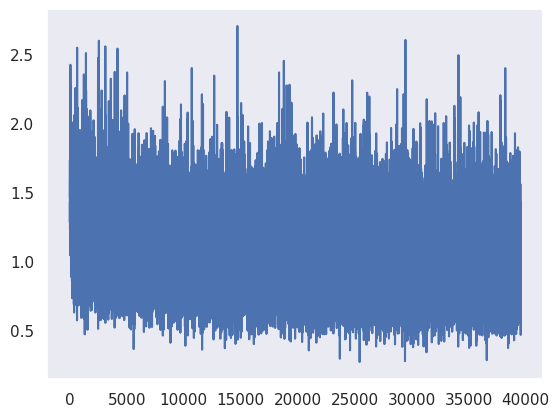

In [47]:
plt.plot(train_losses)

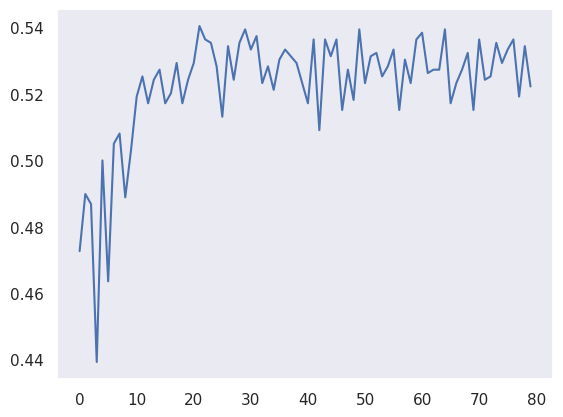

In [48]:
plt.plot(test_accuracy)